In [1]:
%%time
!pip install langchain setfit==1.0.3 sentence-transformers==2.3.1 transformers==4.39.0 langchain-openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.2/974.2 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 94.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

# **Redes Neuronales para PLN - Práctica Final**
## Notebook 4 - DL Models: contextuales, basados en Transformers y LLMs
### Alumno: Alvarez Lacasa, Lucas Alfredo

En esta notebook, nos enfocaremos en el uso de Transformers y modelos contextuales para el procesamiento del lenguaje natural. En este caso, los aplicaremos para la tarea de hate-speech detection con la que venimos trabajando.

Más concretamente, abordaremos temáticas muy similares a la de las Notebooks 2 y 3, sólo que explorando ahora modelos más complejos y potentes.

# Imports globales

Los imports son declarados en esta primera sección de la notebook

In [2]:
import abc
import bz2
import csv
import datetime
import gzip
import itertools
import os
import random
import re
import time
from dataclasses import dataclass, field, asdict
from enum import Enum
from typing import cast

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from datasets import Dataset
from langchain_core.messages import AIMessage
from langchain_core.messages import BaseMessage
from langchain_core.messages import HumanMessage
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_openai import ChatOpenAI
from sentence_transformers import SentenceTransformer
from setfit import SetFitModel, Trainer, TrainingArguments
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from transformers import EarlyStoppingCallback
from transformers import PreTrainedModel, AutoModelForSequenceClassification, PreTrainedTokenizer, \
    ZeroShotClassificationPipeline

# Funciones y clases auxiliares

Definiré un conjunto de funciones y clases utilitarias para evitar duplicación de código, haciendo que la notebook sea más mantenible y sencilla de volver a ejecutar. Creo que en general se trata de una buena práctica sobre todo en notebooks largas para poder aislar ejecución de código de forma de que sea menos probable cometer errores.

La gran mayoría de funciones y clases utilitarias (sin importar para qué sección del índice correspondan) serán listadas aquí por una cuestión de simplicidad y de poder re-cargar la notebook más fácilmente mientras desarrollo.

In [3]:
"""
=========================
Route resolution class

EDIT THIS CLASS depending on where you will be running this notebook!
=========================
"""

COLAB_BASE_MOUNT_POINT: str = "/content/drive"


@dataclass
class RouteConfig:
    notebook_name: str
    run_in_colab: bool = False
    # TODO: Change this to your base Colab path!!! =========>
    colab_base_mount_point: str = COLAB_BASE_MOUNT_POINT
    colab_practice_base_dir: str = f"{COLAB_BASE_MOUNT_POINT}/My Drive/UNED/master_nlp/RedesNeuronalesNLP/Practica_Final/challenge"
    local_practice_base_dir: str = "/home/lucas/Desktop/Personal/master_nlp/RedesNeuronalesNLP/Practica_Final/challenge"
    # ======================================================>
    dataset_rel_folder_path: str = os.path.join("data", "dataset", "OffendES")
    dataset_train_file_name: str = "train.csv"
    dataset_test_file_name: str = "test.csv"
    exp_output_rel_folder_path: str = "experiment_output"


class RouteResolver:
    """ This object abstracts the retrieval of the files used in this notebook by only editing the RouteConfig class received """

    def __init__(self, route_config: RouteConfig) -> None:
        if route_config.run_in_colab:
            # Import and mount into the base mount path for Google Colab
            from google.colab import drive
            drive.mount(route_config.colab_base_mount_point)

        self._config: RouteConfig = route_config

        # Create experiment output folder for this notebook
        exp_output_notebook_folder: str = self.current_exp_output_folder()
        if not os.path.isdir(exp_output_notebook_folder):
            print(f"Experiment output folder for this notebook does not exist. Creating...")
            os.mkdir(exp_output_notebook_folder)

    def base_folder_path(self) -> str:
        """Returns the base path depending if you're running in Colab or not"""
        return self._config.colab_practice_base_dir if self._config.run_in_colab else self._config.local_practice_base_dir

    def get_datasets_folder(self) -> str:
        """Returns the dataset folder"""
        return os.path.join(self.base_folder_path(), self._config.dataset_rel_folder_path)

    def get_training_dataset_path(self) -> str:
        """Returns path to the original training dataset file."""
        return os.path.join(self.get_datasets_folder(), self._config.dataset_train_file_name)

    def get_testing_dataset_path(self) -> str:
        """Returns path to the original test dataset file."""
        return os.path.join(self.get_datasets_folder(), self._config.dataset_test_file_name)

    def get_exp_output_folder(self) -> str:
        """Returns the path to the experiment outputs folder"""
        return os.path.join(self.base_folder_path(), self._config.exp_output_rel_folder_path)

    def get_exp_output_notebook_folder(self, flow_number: int) -> str:
        """Given flow number if returns the experiment output folder for it"""
        notebook_name: str = f"PracticaFinal_AlvarezLacasaLucas_{str(flow_number)}"
        exp_output_notebook_folder: str = os.path.join(self.get_exp_output_folder(), notebook_name)
        validate_condition(condition=os.path.isdir(exp_output_notebook_folder),
                           msg=f"Can't find experiment output for flow: {notebook_name}")
        return exp_output_notebook_folder

    def current_exp_output_folder(self) -> str:
        """Returns experiment output folder for current notebook being ran"""
        return os.path.join(self.get_exp_output_folder(), self._config.notebook_name)

    def dump_registered_paths(self) -> None:
        running_env: str = "COLAB" if self._config.run_in_colab else "LOCAL"
        print("Registered application paths ========")
        print(f"Running environment: {running_env}")
        print(f"Experiment output for this notebook is located in: {self.current_exp_output_folder()}")
        print(f"Original Training dataset file is located in: {self.get_training_dataset_path()}")
        print(f"Original Test dataset file is located in: {self.get_testing_dataset_path()}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
"""
=========================================
General utility functions
=========================================
"""


class ExtendedEnum(Enum):
    """
    Extended class of enum with some utility methods
    """

    @classmethod
    def options(cls) -> list[Enum]:
        return list(cls)

    @classmethod
    def values(cls) -> list[str]:
        return [e.value for e in cls.options()]


def validate_condition(condition: bool, msg: str, exc_type: type[Exception] = ValueError) -> None:
    """
    If condition is not met, it will raise a ValueError with the arguments provided
    :param condition: condition to validate
    :param msg: string to display in the error
    :param exc_type: type of exception we want to raise. ValueError by default
    :return: ValueError in case condition is not met, None otherwise
    """
    if not condition:
        raise exc_type(msg)


def fopen(filename, mode='rt', encoding='utf-8', **kwargs):
    """Wrapper for built-in open() to handle .gz and .bz2 files transparently.
    Opens file with utf-8 encoding by default."""
    if re.search("\.gz$", filename) is not None:
        _fopen = gzip.open
        if 'b' not in mode and 't' not in mode:
            mode = mode + 't'  # 'rb' is the default for gzip and bz2
    elif re.search("\.bz2$", filename) is not None:
        _fopen = bz2.open
        if 'b' not in mode and 't' not in mode:
            mode = mode + 't'
    else:
        _fopen = open
    if 'b' in mode:
        return _fopen(filename, mode=mode, **kwargs)
    else:
        return _fopen(filename, mode=mode, encoding=encoding, **kwargs)


class HateSpeechConfig:
    """ Helper class to manage labels info for our datasets """

    def __init__(self):
        self.labels: list[str] = ["NO", "NOM", "OFP", "OFG"]
        self.binary_labels: list[str] = ["no_hate", "hate"]
        self._label2binlabel: dict[str, str] = {
            "NO": "no_hate",
            "NOM": "no_hate",
            "OFP": "hate",
            "OFG": "hate"
        }

    def map_to_binary_label(self, label: str) -> str:
        """Maps fine-grained label to binary label"""
        return self._label2binlabel[label]

    def map_to_label_index(self, label: str) -> int:
        if label in self.labels:
            return self.labels.index(label)
        return self.binary_labels.index(label)

    def labels2index(self, binary: bool = False) -> dict[str, int]:
        proper_list: list[str] = self.labels if not binary else self.binary_labels
        return {l: idx for idx, l in enumerate(proper_list)}

    def random_hate_speech_label(self, labels: list[str] | None = None) -> str:
        """
        Randomly takes an element from a list
        Typically used for models that have more options than "hate" or "no_hate"
        '"""
        # List of possible outcomes
        options: list[str] = list(self.labels) if not labels else labels
        # Randomly select one of the outcomes
        return random.choice(options)


def create_dir_if_not_exists(folder: str) -> None:
    # Create a directory if it does not exist already
    if not os.path.isdir(folder):
        os.mkdir(folder)

<>:36: DeprecationWarning: invalid escape sequence '\.'
<>:40: DeprecationWarning: invalid escape sequence '\.'
<>:36: DeprecationWarning: invalid escape sequence '\.'
<>:40: DeprecationWarning: invalid escape sequence '\.'
<ipython-input-4-610fa393a219>:36: DeprecationWarning: invalid escape sequence '\.'
  if re.search("\.gz$", filename) is not None:
<ipython-input-4-610fa393a219>:40: DeprecationWarning: invalid escape sequence '\.'
  elif re.search("\.bz2$", filename) is not None:


In [5]:
"""
===========================
Visualization functions
===========================
"""


def plot_confusion_matrix(
        cm: any,
        classes: list[str],
        normalize: bool = False,
        title: str = "Confusion matrix",
        cmap: any = "Blues",
        figsize: tuple[int, int] = (10, 10),
) -> None:
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    cm: confusion_matrix from scikit_learn.metrics
    classes: array with the classes
    title: the title to put on the chart
    cmap: the color palette to use
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black"
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title(title)
    plt.grid(False)
    plt.show()

In [6]:
"""
=========================================
Training and validation
=========================================
"""


@dataclass
class ParametersInfo:
    trainable_params: int
    non_trainable_params: int
    total_params: int
    size_mb: float


class ClassifMetricsCalculator:
    """ Utility class to compute classification metrics """

    def __init__(self, true_labels: list[str], pred_labels: list[str], label2idx: dict[str, int] | None = None) -> None:
        self._true_labels: list[str] = true_labels
        self._pred_labels: list[str] = pred_labels
        self._label2idx, self._idx2label = self._initialize_mappings(label2idx)

    def plot_confusion_matrix(
            self,
            title: str = "Classification confusion matrix",
            figsize: tuple[int, int] = (7, 5),
    ) -> None:
        """Takes care of generating and plotting confusion matrix based on predictions and goals"""
        all_labels: list[str] = list(self._label2idx.keys())
        cm = confusion_matrix(y_true=self._true_labels, y_pred=self._pred_labels, labels=all_labels)
        plot_confusion_matrix(
            cm,
            classes=all_labels,
            title=title,
            figsize=figsize,
        )

    def get_classification_report(self) -> tuple[str, dict]:
        """Print the classification report as a summary to visualize"""
        common_params: dict = {
            "y_true": [self._label2idx[g] for g in self._true_labels],
            "y_pred": [self._label2idx[p] for p in self._pred_labels],
            "digits": 4,
            "labels": list(self._idx2label.keys()),
            "target_names": list(self._idx2label.values())
        }
        report_str: str = classification_report(**common_params, output_dict=False)
        report_dict: dict = classification_report(**common_params, output_dict=True)
        return report_str, report_dict

    def _initialize_mappings(self, label2idx: dict[str, int] | None) -> tuple[dict[str, int], dict[int, str]]:
        """Initialize the mapping dictionaries, to guarantee that labels will be sorted in some way when reporting"""
        if label2idx is not None:
            idx2label: dict[int, str] = {v: k for k, v in label2idx.items()}
            return label2idx, idx2label

        # Not provided, use what we have in the predictions
        all_labels: list[str] = sorted(set(self._true_labels))
        label2idx_final: dict[str, int] = (
            {l: idx for idx, l in enumerate(all_labels)} if label2idx is None else label2idx
        )
        idx2label = {v: k for k, v in label2idx_final.items()}

        return label2idx_final, idx2label

In [7]:


"""
=========================
Runnables/Trainers
=========================
"""
# TODO: complete here with your credentials!
OPEN_AI_KEY = "your-own-credentials"
HUGGINGFACE_INF_PRO_API_KEY = "your-own-credentials"


@dataclass
class InferenceItem:
    id: int | str
    prompt: str


@dataclass
class InferenceResult(InferenceItem):
    response: str
    probas: float | list[float] = field(default_factory=list)


class OpenAIModel(ExtendedEnum):
    # See all options here: # https://platform.openai.com/docs/models/gpt-4
    GPT_35_TURBO: str = "gpt-3.5-turbo"
    GPT_4: str = "gpt-4"


@dataclass
class RunnerBaseConfig(abc.ABC):
    cadence: float = 0.5  # Number of seconds to wait in between requests
    model_name: str = ""
    api_token: str = ""


@dataclass
class OpenAIConfig(RunnerBaseConfig):
    model_name: str = OpenAIModel.GPT_35_TURBO.value
    temperature: float = 0.0  # keep level of randomness for generation low
    max_tokens: int | None = 20

    def __post_init__(self) -> None:
        validate_condition(self.model_name in OpenAIModel.values(), msg=f"Invalid model_name: {self.model_name}")


class BaseRunner(abc.ABC):
    def __init__(self, config: RunnerBaseConfig) -> None:
        self._config = config

    def run(self, items: list[InferenceItem]) -> dict[int | str, InferenceResult]:
        """ Receives a list of elements to do inference, and returns a dictionary going from each item id to the result obtained """
        print(f"Starting inference for: {len(items)} items!")
        inf_res: dict[int, InferenceResult] = {}

        for item in tqdm(items):
            inf_res[item.id] = self._process(item)
            time.sleep(self._config.cadence)

        print("Inference done!.")
        return inf_res

    @abc.abstractmethod
    def _process(self, item: InferenceItem) -> InferenceResult:
        """ Processes a single item """


class OpenAIRunner(BaseRunner):
    def __init__(self, config: OpenAIConfig):
        super().__init__(config)
        os.environ["OPENAI_API_KEY"] = config.api_token
        self._llm: ChatOpenAI = ChatOpenAI(model_name=config.model_name,
                                           temperature=config.temperature,
                                           max_tokens=config.max_tokens)

    def _process(self, item: InferenceItem) -> InferenceResult:
        llm_response: AIMessage = self._llm(self.wrap_in_chat_prompt(item.prompt))
        return InferenceResult(id=item.id, prompt=item.prompt, response=llm_response.content)

    @staticmethod
    def wrap_in_chat_prompt(prompt: str) -> list[BaseMessage]:
        """Prompt is already built, so it will only wrap it"""
        prompt_template: ChatPromptTemplate = ChatPromptTemplate.from_messages([HumanMessage(prompt)])
        return cast(list[BaseMessage], prompt_template.format_messages())


@dataclass
class ZeroShotClassificationConfig(RunnerBaseConfig):
    device: str = "cuda"
    multi_label: bool = False
    labels: list[str] = field(default_factory=lambda: HateSpeechConfig().labels)


class ZeroShotClassificationRunner(BaseRunner):
    """
    Downloads a Huggingface zero-shot model and executes the prediction for a given sentence, given a list of
    labels for the classification.
    """

    def __init__(self, config: ZeroShotClassificationConfig):
        super().__init__(config)
        self._config: ZeroShotClassificationConfig = config
        model_id: str = config.model_name
        few_show_classification_model: PreTrainedModel = AutoModelForSequenceClassification.from_pretrained(model_id)
        few_show_classification_model = few_show_classification_model.to(torch.device(config.device))
        few_show_classification_tokenizer: PreTrainedTokenizer = AutoTokenizer.from_pretrained(model_id)
        device_no: int | None = 0 if config.device == "cuda" else None
        self._model: ZeroShotClassificationPipeline = ZeroShotClassificationPipeline(
            model=few_show_classification_model,
            tokenizer=few_show_classification_tokenizer,
            device=device_no,
            multi_label=config.multi_label,
        )

    def _process(self, item: InferenceItem) -> InferenceResult:
        model_pred: dict = self._model([item.prompt], candidate_labels=self._config.labels)[0]
        max_proba_idx: int = model_pred["scores"].index(max(model_pred["scores"]))
        return InferenceResult(
            id=item.id,
            prompt=item.prompt,
            response=model_pred["labels"][max_proba_idx],
            probas=model_pred["scores"][max_proba_idx]
        )


@dataclass
class SetFitTrainingConfig:
    model: str = "sentence-transformers/all-MiniLM-L6-v2"
    metric: str = "accuracy"
    batch_size: int = 32
    num_iterations: int = 5  # number of positive and of negative text pairs to generate for contrastive learning
    num_epochs: int = 3  # epochs to use for contrastive learning
    labels: list[str] = field(default_factory=lambda: ["negative", "positive"])
    add_early_stopping: bool = True
    early_stopping_patience: int = 2
    balanced_class_weight: bool = False
    head_max_iter: int = 3000


@dataclass
class TrainingItem:
    id: int
    text: str
    label: str


@dataclass
class SetfitTrainerConfig:
    train_data: list[TrainingItem]
    val_data: list[TrainingItem]
    train_config: SetFitTrainingConfig
    positive_threshold_test: float | None = 0.5  # only used on test set if binary classification


class SetFitTrainer:
    def __init__(self, config: SetfitTrainerConfig):
        self._config = config
        train_config: SetFitTrainingConfig = config.train_config
        class_weight: str | None = "balanced" if config.train_config.balanced_class_weight else None

        model_body = SentenceTransformer(train_config.model)
        model_head = LogisticRegression(class_weight=class_weight,
                                        max_iter=config.train_config.head_max_iter)
        self._model = SetFitModel(model_body=model_body,
                                  model_head=model_head,
                                  labels=train_config.labels)

        print(f"Sentence transformer: {train_config.model} loaded!")

        args = TrainingArguments(
            batch_size=train_config.batch_size,
            num_epochs=train_config.num_epochs,
            num_iterations=train_config.num_iterations,
            save_strategy="epoch",
            evaluation_strategy="epoch",
            load_best_model_at_end=True
        )
        callbacks = [EarlyStoppingCallback(
            early_stopping_patience=train_config.early_stopping_patience)] if train_config.add_early_stopping else []

        print(f"Loading datasets...")
        dataset_train = self._prepare_dataset(config.train_data)
        print(f"Number of samples in training set: {len(dataset_train)}")
        dataset_val = self._prepare_dataset(config.val_data)
        print(f"Number of samples in validation set: {len(dataset_val)}")

        self._trainer = Trainer(
            model=self._model,
            args=args,
            train_dataset=dataset_train,
            eval_dataset=dataset_val,
            metric="accuracy",
            callbacks=callbacks
        )
        print("Trainer successfully loaded!. All ready.")

    def _prepare_dataset(self, data: list[TrainingItem]) -> Dataset:
        relabelled_dataset = [{"text": item.text,
                               "label": item.label} for item in data]
        return Dataset.from_list(relabelled_dataset)

    def train(self) -> None:
        print("Starting model training...")
        curr_datetime = datetime.datetime.now()
        self._trainer.train()
        total_time = datetime.datetime.now() - curr_datetime
        print(f"Finished model training. Took {total_time} seconds")

    def eval(self) -> None:
        print("Starting evaluation...")
        val_metric = self._trainer.evaluate()
        val_res_txt = (
            f"{str(list(val_metric.keys())[0]).title()} on validation set: " f"{round(list(val_metric.values())[0], 4)}"
        )
        print(val_res_txt)

    def inference(self, items: list[TrainingItem]) -> dict[int, InferenceResult]:
        print("Starting to do inference over trained model...")
        inf_res: dict[int, InferenceResult] = {}

        # pass them al together so it can batch
        all_texts: list[str] = [t.text for t in items]
        all_preds: list[str] = self._model.predict(all_texts)  # we could use predic_proba as well

        for pred, item in zip(all_preds, items):
            inf_res[item.id] = InferenceResult(id=item.id, prompt=item.text, response=pred)
        print("Inference done!.")
        return inf_res

    @property
    def model(self):
        return self._model


class InferenceResultsPrinter(abc.ABC):
    @abc.abstractmethod
    def print(self, results: list[InferenceResult], true_labels: list[str], output_file: str) -> None:
        """ Writes results to output file """


class InferenceResultsTSVPrinter(InferenceResultsPrinter):
    def print(self, results: list[InferenceResult], true_labels: list[str], output_file: str) -> None:
        with fopen(output_file, "w") as f_out:
            tsv_writer = csv.writer(f_out, delimiter="\t")
            tsv_writer.writerow(["id", "prompt", "pred_label", "true_label", "match"])
            for item, true_label in zip(results, true_labels):
                match: str = "*" if item.response == true_label else ""
                tsv_writer.writerow([item.id, item.prompt, item.response, true_label, match])

# Resolución de rutas

Utilizaremos una clase `RouteResolver` para resolver las rutas, de forma de aislar esa información allí y poder modificarla en un único punto del notebook.

Verificar el output de la siguiente celda en caso de querer re-ejecutar la notebook para asegurarse de que las rutas apuntan al lugar correcto. Esta vez utilicé `run_in_colab=True` ya que necesité de la GPU para entrenar los modelos basados en Transformers. Es decir, gran parte de esta notebook fue testeada en `GoogleColab`.

In [8]:
# Routes
route_resolver: RouteResolver = RouteResolver(
    RouteConfig(run_in_colab=True, notebook_name="4_dl_approaches"))
route_resolver.dump_registered_paths()

Mounted at /content/drive
Registered application paths ========
Running environment: COLAB
Experiment output for this notebook is located in: /content/drive/My Drive/UNED/master_nlp/RedesNeuronalesNLP/Practica_Final/challenge/experiment_output/PracticaFinal_AlvarezLacasaLucas_4
Original Training dataset file is located in: /content/drive/My Drive/UNED/master_nlp/RedesNeuronalesNLP/Practica_Final/challenge/data/dataset/OffendES/train.csv
Original Test dataset file is located in: /content/drive/My Drive/UNED/master_nlp/RedesNeuronalesNLP/Practica_Final/challenge/data/dataset/OffendES/test.csv


# Punteros a datasets generados 1_data_exploration

Definiremos los paths a los datasets generados anteriormente, de forma de poder usarlos en esta notebook.

In [9]:
notebook1_output_folder: str = route_resolver.get_exp_output_notebook_folder(1)
flow_output_folder: str = route_resolver.get_exp_output_notebook_folder(4)

dataset_v1_folder: str = os.path.join(notebook1_output_folder, "v1")
dataset_v4_folder: str = os.path.join(notebook1_output_folder, "v4")
dataset_v7_folder: str = os.path.join(notebook1_output_folder, "v7")

orig_test_set_file_path: str = route_resolver.get_testing_dataset_path()
v1_test_set_file_path: str = os.path.join(dataset_v1_folder, "test.csv")
v4_test_set_file_path: str = os.path.join(dataset_v4_folder, "test.csv")

orig_test_set_df: pd.DataFrame = pd.read_csv(orig_test_set_file_path, quotechar='"', header=0, sep=",")
v1_test_set_df: pd.DataFrame = pd.read_csv(v1_test_set_file_path, quotechar='"', header=0, sep=",")
v4_test_set_df: pd.DataFrame = pd.read_csv(v4_test_set_file_path, quotechar='"', header=0, sep=",")

# The original test set doesn't have the label_binary column, so i'll add it
hs_config: HateSpeechConfig = HateSpeechConfig()
orig_test_set_df["label_binary"] = orig_test_set_df["label"].map(hs_config.map_to_binary_label)

## Baseline (zero-shot)

Al igual que en la práctica anterior, comenzaré utilizando Large Language Models (LLMs) con esquema zero-shot. En función de los resultados podemos optar por probar con un esquema few-shot luego.

Algo interesante es que pasaré el test set en diversas versiones, también para corroborar qué tan disruptivo ha sido el cleanup que fuimos haciendo. Principalmente probaré con el test set original y luego con el cleanup hecho en `v1`.

La idea para estos casos será la de usar el modelo sólo para hacer inferencia sobre nuestro test set y entonces computar las métricas que reportamos normalmente.


### Clasificadores con LLMs
Me parece interesante ver qué performance podemos alcanzar con un esquema zero-shot donde hacemos uso de los State of the Art LLMs.

Es cierto que dependiendo el modelo, deberemos utilizar prompts con delimitadores diferentes y que también podríamos optimizar la prompt tanto como queramos. Esta tarea es un poco más compleja que la que realizamos en prácticas anteriores, no sólo porque la clasificación es multi-class si no además porque el contenido de la información está en español.

#### GPT 3.5 turbo

Comenzaremos haciendo uso de este modelo a través de la API de [OpenAI](https://openai.com/blog/openai-api).

Nos creamos una pequeña clase para hacer este procedimiento con este u otros modelos ofrecidos por esta librería fácilmente. El input a la clase será el listado de los prompts a ejecutar, y el output para este caso, será la respuesta generada por el modelo para cada uno de ellos (idealmente, `NO`, `NOM`, `OFP`, `OFG`).

Una buena práctica que suele usarse en la industria es la de pedir previamente al LLM que genere la prompt para la tarea en cuestión a realizar, de forma de ver cómo estructurar correctamente la información en la misma. Me basaré en este approach para tener una base sobre cómo estructurar la información y luego manualmente la iré modificando (a prueba y error viendo los resultados que obtengo en la UI de ChatGPT).

Realicé algunas pruebas de prompts en la UI de ChatGPT, y una que parece funcionar bastante bien para este caso es la mostrada a continuación. Explícitamente indiqué como parte de la prompt que sólo devuelva el label asocido al review. Notar que esto en LLMs más pequeños u open source no necesariamente va a suceder, y probablemente nos requiera implementar algún tipo de parser para mapear el output del LLM a alguna de las categorías de clasificación válidas que tenemos.

In [ ]:
prompt_str: str = """
Classify the text in Spanish surrounded by triple backticks into one of these four categories for hate-speech detection. Provide only the corresponding label for your answer:
- OFP: Offensive, the target is a person.
- OFG: Offensive, the target is a group of people or a collective.
- NOM: Not offensive, though with inappropriate or insulting language.
- NO: Not offensive.

```
{comment}
```
"""

prompt_template: PromptTemplate = PromptTemplate.from_template(prompt_str)
labels: list[str] = ["NO", "NOM", "OFP", "OFG"]

##### Original test set (no cleanup) - SUBSET

Comenzaremos primero eligiendo un subset de elementos, como para mirarlos manualmente y ver la calidad de las anotaciones.

In [ ]:
items: list[InferenceItem] = []
samples2goals: dict[str, str] = {}

for label in labels:
    samples_for_class = orig_test_set_df[orig_test_set_df["label"] == label].sample(n=15)
    label_samples: dict[str, str] = {r["comment"]: r["label"] for _idx, r in samples_for_class.iterrows()}
    samples2goals = {**samples2goals, **label_samples}
    items.extend([InferenceItem(id=r["comment"], prompt=prompt_template.format(comment=r["comment"])) for _idx, r in
                  samples_for_class.iterrows()])

openai_runner: OpenAIRunner = OpenAIRunner(config=OpenAIConfig(api_token=OPEN_AI_KEY))
result: dict[int | str, InferenceResult] = openai_runner.run(items=items)

Starting inference for: 60 items!


100%|██████████| 60/60 [00:55<00:00,  1.09it/s]

Inference done!.


In [ ]:
data_for_df: list[dict] = []
for res in result.values():
    res_dict: dict = asdict(res)
    res_dict["goal"] = samples2goals[res.id]
    res_dict.pop("probas")
    data_for_df.append(res_dict)

res_df: pd.DataFrame = pd.DataFrame(data_for_df)
res_df["match"] = ["*" if r["response"] == r["goal"] else "" for _idx, r in res_df.iterrows()]
orig_test_set_sample_file_path: str = os.path.join(flow_output_folder, "aux_chatgpt_orig_test_set_subset.tsv")
res_df.to_csv(orig_test_set_sample_file_path, sep="\t", index=False)
res_df[["id", "response", "goal"]]

id response goal
0   Hey, déjame decirte que te sigo desde que reto...       NO   NO
1   Al ver tu cambio por instagram me ENAMORO en s...       NO   NO
2   No me interesa una mierda lo que contas pero m...      NOM   NO
3   Partido nuevo, fresco y con un esquema distint...       NO   NO
4   "Miare solo la promociono y ya está"... Si cla...      OFP   NO
5   Eso es un pulpo de verdad?   Parece una mezcla...      NOM   NO
6   No sé porque, pero la nueva nariz te hace ver ...       NO   NO
7   Tenía miedo de ver este video pero ha valido l...       NO   NO
8   Me causa mucho toque que la silla esté de lado...       NO   NO
9   Soy el único que cree que ella podría hacer li...      OFP   NO
10  no sólo las gordas sufren, por mucho que cuest...       NO   NO
11  Nmms si los platanos individuales se venden as...       NO   NO
12  Yo me muero si alguien me borra las listas de ...       NO   NO
13  Y la cabeza de atrás me parecía que movía los ...      NOM   NO
14  La mía, para la fecha de tu niña hace 15 años....      NOM   NO
15                 ESQUE TE PUTO AMO JAJAJAJAJAJAJJAJ      OFP  NOM
16  en realidad bn es bien, buenas noches seria bn...      NOM  NOM
17                            Verga Dalas y entonces😂      OFP  NOM
18  Jajajaja tu imagen está más manchada que caca ...      NOM  NOM
19  No me creo lo k vi xddddd el puto naruto con e...      OFP  NOM
20  Todos en final de 2019:2020 Seguro que será un...      OFP  NOM
21  Tía no sé que coño hablas pero me haces reír a...      NOM  NOM
22                          Haz intros de trap cabron      NOM  NOM
23    noooooooooooooo yt me desactivo la puta campana      NOM  NOM
24  Hoy he tenido un día de mierda y me acabas de ...      NOM  NOM
25     DIOSS ESTI CONOCE A LOVELY PEACHES PUTO FAN <3      OFP  NOM
26          Wimichu deja la cerveza toma zumitos coño      OFP  NOM
27          para auron esto es una mierda de tik tock      OFP  NOM
28                    Ni foto por aquí, ni mierda ...      NOM  NOM
29                    De puta madre el video, un capo      NOM  NOM
30          Te veo más delgada .... gorda traicionera      OFP  OFP
31                                       Guarra t amo      OFP  OFP
32                     Pinche loca vete ala cárcel🖕🖕🖕      OFP  OFP
33  Vete al diablo y en el infierno que te quemes ...      OFP  OFP
34  que patética la niña, esta robando contenido q...      OFP  OFP
35  Ya fuiste  olvidada jajajaja gamer con tetaa f...      OFP  OFP
36                             Vaya mierda de persona      OFP  OFP
37  Windy es lamentablemente patética tienes toda ...      OFP  OFP
38  El panochudo quiere creer que badadun esta atr...      OFG  OFP
39                                             ratera      NOM  OFP
40                 Dalas pendejo🖕🏽 me cagas ala verga      OFP  OFP
41                                           Loca mmv      NOM  OFP
42                                             Fea xd      NOM  OFP
43  Que gorda  está la Windy... parece que quiere ...      OFP  OFP
44                                      turbo Cobarde      OFP  OFP
45  Me da lástima que haya tanto idiota de 13 años...      OFP  OFG
46  Yo leyendo los comentarios bien puercos de la ...      OFG  OFG
47  Que mala serie Elite, no me gusta nada, están ...      NOM  OFG
48  la amistad de kimberli y kenia era como la de ...      NOM  OFG
49  increible a lo que puede llegar la gente estan...      OFP  OFG
50  Que rabia, Dalas dejalos quietos son unos retr...      OFP  OFG
51  Habla sobre los putos fascistas de mierda! Ser...      OFG  OFG
52  La gente está mal de la cabeza...Lo peor es te...      OFG  OFG
53                                  Que mongolos 🤣🤣🤣🤣      OFP  OFG
54  No hace falta poner que son estúpidos porque  ...      OFP  OFG
55                          Pinche gente enferma 😂😂😝😝      OFG  OFG
56                      Jajaja qué gente de mierda 😂😂      OFG  OFG
57  Que esa familia ya se vaya a la puta carcel y ...      OFP  OFG
58  Unos niñatos. Que no tienen ni puta

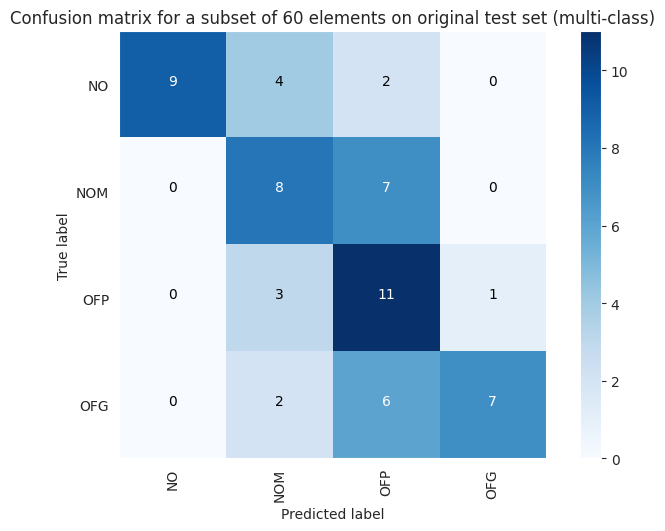

              precision    recall  f1-score   support

          NO     1.0000    0.6000    0.7500        15
         NOM     0.4706    0.5333    0.5000        15
         OFP     0.4231    0.7333    0.5366        15
         OFG     0.8750    0.4667    0.6087        15

    accuracy                         0.5833        60
   macro avg     0.6922    0.5833    0.5988        60
weighted avg     0.6922    0.5833    0.5988        60



In [ ]:
labels2idx: dict[str, int] = {l: idx for idx, l in enumerate(labels)}
report: ClassifMetricsCalculator = ClassifMetricsCalculator(true_labels=list(res_df["goal"]),
                                                            pred_labels=list(res_df["response"]), label2idx=labels2idx)
report.plot_confusion_matrix(title="Confusion matrix for a subset of 60 elements on original test set (multi-class)")
print(report.get_classification_report()[0])

Podemos ver como a diferencia de la práctica anterior donde ChatGPT tenía una performance excelente, en este caso no la tiene para un subset que sacamos de 15 ejemplos por clase.

Para entender por qué, miraré esos ejemplos donde no hay match e intentaré ver quien está en lo cierto (si el anotador o ChatGPT).

In [ ]:
res_df[(res_df["match"] == "") & (res_df["goal"] == "NO")][["id", "response", "goal", "match"]]

id response goal match
2   No me interesa una mierda lo que contas pero m...      NOM   NO      
4   "Miare solo la promociono y ya está"... Si cla...      OFP   NO      
5   Eso es un pulpo de verdad?   Parece una mezcla...      NOM   NO      
9   Soy el único que cree que ella podría hacer li...      OFP   NO      
13  Y la cabeza de atrás me parecía que movía los ...      NOM   NO      
14  La mía, para la fecha de tu niña hace 15 años....      NOM   NO

Desde mi punto de vista:
- La primera está mal anotada (debería ser "NOM").
- La segunda está bien anotada y mal predicha.
- La tercera está bien anotada y mal predicha.
- La cuarta está bien anotada y mal predicha.
- La quinta está bien anotada y mal predicha.
- La sexta está bien anotada y mal predicha.

In [ ]:
res_df[(res_df["match"] == "") & (res_df["goal"] == "NOM")][["id", "response", "goal", "match"]]

id response goal match
15                 ESQUE TE PUTO AMO JAJAJAJAJAJAJJAJ      OFP  NOM      
17                            Verga Dalas y entonces😂      OFP  NOM      
19  No me creo lo k vi xddddd el puto naruto con e...      OFP  NOM      
20  Todos en final de 2019:2020 Seguro que será un...      OFP  NOM      
25     DIOSS ESTI CONOCE A LOVELY PEACHES PUTO FAN <3      OFP  NOM      
26          Wimichu deja la cerveza toma zumitos coño      OFP  NOM      
27          para auron esto es una mierda de tik tock      OFP  NOM

Desde mi punto de vista:
- La primera está bien anotada y mal predicha (border-line).
- La segunda es muy dudosa, puede ser "OFP" como dice el modelo.
- La tercera está bien anotada y mal predicha (border-line).
- La cuarta está bien anotada y mal predicha.
- La quinta está bien anotada y mal predicha.
- La sexta está bien anotada y mal predicha.
- La séptima está bien anotada y mal predicha.


In [ ]:
res_df[(res_df["match"] == "") & (res_df["goal"] == "OFP")][["id", "response", "goal", "match"]]

id response goal match
38  El panochudo quiere creer que badadun esta atr...      OFG  OFP      
39                                             ratera      NOM  OFP      
41                                           Loca mmv      NOM  OFP      
42                                             Fea xd      NOM  OFP

Desde mi punto de vista:
- Todas están bien anotadas y mal predichas.


In [ ]:
res_df[(res_df["match"] == "") & (res_df["goal"] == "OFG")][["id", "response", "goal", "match"]]

id response goal match
45  Me da lástima que haya tanto idiota de 13 años...      OFP  OFG      
47  Que mala serie Elite, no me gusta nada, están ...      NOM  OFG      
48  la amistad de kimberli y kenia era como la de ...      NOM  OFG      
49  increible a lo que puede llegar la gente estan...      OFP  OFG      
50  Que rabia, Dalas dejalos quietos son unos retr...      OFP  OFG      
53                                  Que mongolos 🤣🤣🤣🤣      OFP  OFG      
54  No hace falta poner que son estúpidos porque  ...      OFP  OFG      
57  Que esa familia ya se vaya a la puta carcel y ...      OFP  OFG

Desde mi punto de vista:
- La primera está bien anotada y mal predicha.
- La segunda está bien predicha y mal anotada (es "NOM").
- La tercera está mal anotada y predicha (es "NO").
- La cuarta está bien anotada y mal predicha (es compleja esta para un modelo, porque "gente" refiere a grupo).
- La quinta está bien anotada y mal predicha.
- La sexta está bien anotada y mal predicha.
- La séptima está bien anotada y mal predicha.
- La octava está mal anotada y predicha (es "NOM").

Resumiendo, podemos ver que en líneas generales es el modelo quien se equivoca. Sin embargo, también es cierto que hay casos dudosos o inclusive mal anotados en el test set. Esto nos puede dar alguna pista de por qué los resultados que obtenemos también son malos.

##### V1 test set (light cleanup, no augmentation) - SUBSET

Repetiremos la misma prueba que antes, pero esta vez sobre un subset elegido de la versión `v1` de cleanup. La idea es ver qué tan disruptivo es el cleanup para nuestro modelo.

In [ ]:
items: list[InferenceItem] = []
samples2goals: dict[str, str] = {}

for label in labels:
    samples_for_class = v1_test_set_df[v1_test_set_df["label"] == label].sample(n=15)
    label_samples: dict[str, str] = {r["comment"]: r["label"] for _idx, r in samples_for_class.iterrows()}
    samples2goals = {**samples2goals, **label_samples}
    items.extend([InferenceItem(id=r["comment"], prompt=prompt_template.format(comment=r["comment"])) for _idx, r in
                  samples_for_class.iterrows()])

openai_runner: OpenAIRunner = OpenAIRunner(config=OpenAIConfig(api_token=OPEN_AI_KEY))
result: dict[int | str, InferenceResult] = openai_runner.run(items=items)

Starting inference for: 60 items!


100%|██████████| 60/60 [00:55<00:00,  1.09it/s]

Inference done!.


In [ ]:
data_for_df: list[dict] = []
for res in result.values():
    res_dict: dict = asdict(res)
    res_dict["goal"] = samples2goals[res.id]
    res_dict.pop("probas")
    data_for_df.append(res_dict)

res_df: pd.DataFrame = pd.DataFrame(data_for_df)
res_df["match"] = ["*" if r["response"] == r["goal"] else "" for _idx, r in res_df.iterrows()]
orig_test_set_sample_file_path: str = os.path.join(flow_output_folder, "aux_chatgpt_v1_test_set_subset.tsv")
res_df.to_csv(orig_test_set_sample_file_path, sep="\t", index=False)
res_df[["id", "response", "goal"]]

id response goal
0   io puedo demostrar inmortal caso ser humano in...      OFP   NO
1   pues gusta cantante británica samantha fox 20...      NOM   NO
2   realmente emocionado ver tanta felicidad junt ...       NO   NO
3   fácil windy odia ari amiga danyan cat peleas ...      OFG   NO
4   solo veo pambitontos comentarios insultando de...      OFP   NO
5   pedo allá angeles méxico nombre nota raíces...       NO   NO
6   dalas lizbeth está historia saberse si tal co...       NO   NO
7   dejemosle aserle burla cosas asi asi perdera v...      OFP   NO
8   ahora puedes dominar gastritis forma segura na...       NO   NO
9   veo javioliveira saben ser objetivos trata mia...      OFG   NO
10  cuál colmo dalas decirle gustan amigo viene d...      NOM   NO
11  muchísimas gracias maria video❤️ imaginas có...       NO   NO
12  windy quiero descarguen vídeo pueden tumbar c...      OFP   NO
13    bots only fa digo instagram esk parecido nombre      NOM   NO
14                                  uy murio estupido      OFP   NO
15                             pensaba mierda ironica      NOM  NOM
16  jooooooder muero envidia hermanooooooooooo jod...      OFP  NOM
17                              verga dalas entonces😂      NOM  NOM
18       minuto 3256 juan dios dijo puta panza jajaja      OFP  NOM
19  puedo tener más putoganas nueva aventura road...       NO  NOM
20  querida pringada ahora están leyendo historia...      NOM  NOM
21  serio todavia salis casa😵 aki bilbao estqmos p...      OFP  NOM
22                                 ke mierda xddddddd      NOM  NOM
23              tranquilo saldrá bien imbécil mente      NOM  NOM
24                                        puto amo ❤️      NOM  NOM
25  siguiente vídeo wishlist manager payasa fanfi...      NOM  NOM
26  qn coño tatuado saitama bronceado deforme pierna      NOM  NOM
27  dalas dónde está dalas joder perdió esencia...      OFP  NOM
28  nauter play decide puta vida decide puedes hac...      OFP  NOM
29                         mundo yendo mierda poquito      OFP  NOM
30                                      puta gordaaaa      OFP  OFP
31                                 pareces loca miare      OFP  OFP
32                                     mira fea joder      NOM  OFP
33       loca enserio quisiste suicidar suberia cosas      OFP  OFP
34                                  016 parezco tonta      NOM  OFP
35    favor hace amigo cazzu literal mujer hipócrita      OFP  OFP
36  critica gente haciendo ridiculo sigue pava hac...      OFG  OFP
37  bloqueas tweet gente madre caníbal ladrones p...      OFG  OFP
38  tio hipocrita wismichu sino yoni personaje k i...      OFP  OFP
39  saber q ibas ser gran youtuber convertiste basura      OFP  OFP
40                                         tonta hija      OFP  OFP
41  buscando víctimas dar más show verdad está ...      OFP  OFP
42  ashhhh cuándo va aprender sacandole provecho ...      OFP  OFP
43                            sigues siendo ridícula      NOM  OFP
44                                  maldita presumida      NOM  OFP
45  amistad kimberli kenia regina george gretchen ...      NOM  OFG
46  hace falta poner estúpidos gente almenos 2 gr...      OFP  OFG
47     qué cojones putos pambisitos comentarios xddd      OFP  OFG
48  parece bien hagas salga pelotas verdad follen ...      NOM  OFG
49  subnormales perfecto fanboy wismichu menos mor...      OFP  OFG
50                        malditas mentirosas youtube      OFG  OFG
51  gente está mal cabezalo peor tener tiempo lib...      OFG  OFG
52    ¿puede gente dejar loca totalmente necesario xd      OFG  OFG
53  logroentenderporque mayoría d comentarios má...      OFG  OFG
54  pambisita corazón siempre apoyaré sé algún...       NO  OFG
55                        jajaja qué gente mierda 😂😂      OFP  OFG
56  increible puede llegar gente estan bien enferm...      OFP  OFG
57                          pinche gente enferma 😂😂😝😝      OFG  OFG
58  da lástima idiota 13 años entiend

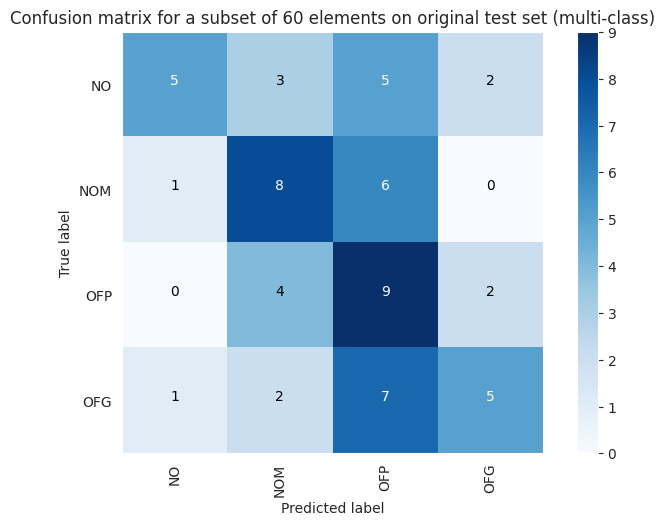

              precision    recall  f1-score   support

          NO     0.7143    0.3333    0.4545        15
         NOM     0.4706    0.5333    0.5000        15
         OFP     0.3333    0.6000    0.4286        15
         OFG     0.5556    0.3333    0.4167        15

    accuracy                         0.4500        60
   macro avg     0.5184    0.4500    0.4499        60
weighted avg     0.5184    0.4500    0.4499        60



In [ ]:
labels2idx: dict[str, int] = {l: idx for idx, l in enumerate(labels)}
report: ClassifMetricsCalculator = ClassifMetricsCalculator(true_labels=list(res_df["goal"]),
                                                            pred_labels=list(res_df["response"]), label2idx=labels2idx)
report.plot_confusion_matrix(title="Confusion matrix for a subset of 60 elements on original test set (multi-class)")
print(report.get_classification_report()[0])

Con estos resultados, vemos que la performance prácticamente no se degrada al realizar la limpieza propuesta por `v1`. Al menos para este subset de ejemplos.

In [ ]:
res_df[(res_df["match"] == "") & (res_df["goal"] == "NO")][["id", "response", "goal", "match"]]

id response goal match
0   io puedo demostrar inmortal caso ser humano in...      OFP   NO      
1   pues gusta cantante británica samantha fox 20...      NOM   NO      
3   fácil windy odia ari amiga danyan cat peleas ...      OFG   NO      
4   solo veo pambitontos comentarios insultando de...      OFP   NO      
7   dejemosle aserle burla cosas asi asi perdera v...      OFP   NO      
9   veo javioliveira saben ser objetivos trata mia...      OFG   NO      
10  cuál colmo dalas decirle gustan amigo viene d...      NOM   NO      
12  windy quiero descarguen vídeo pueden tumbar c...      OFP   NO      
13    bots only fa digo instagram esk parecido nombre      NOM   NO      
14                                  uy murio estupido      OFP   NO

Vemos que hay algunas mal anotadas, como la última, que claramente es "OFP".

In [ ]:
res_df[(res_df["match"] == "") & (res_df["goal"] == "NOM")][["id", "response", "goal", "match"]]

id response goal match
16  jooooooder muero envidia hermanooooooooooo jod...      OFP  NOM      
18       minuto 3256 juan dios dijo puta panza jajaja      OFP  NOM      
19  puedo tener más putoganas nueva aventura road...       NO  NOM      
21  serio todavia salis casa😵 aki bilbao estqmos p...      OFP  NOM      
27  dalas dónde está dalas joder perdió esencia...      OFP  NOM      
28  nauter play decide puta vida decide puedes hac...      OFP  NOM      
29                         mundo yendo mierda poquito      OFP  NOM

En este caso, la mayoría tiende a estar bien anotada. Notamos que se complejiza al haber hecho el cleanup entender muchas de esas frases.

In [ ]:
res_df[(res_df["match"] == "") & (res_df["goal"] == "OFP")][["id", "response", "goal", "match"]]

id response goal match
32                                     mira fea joder      NOM  OFP      
34                                  016 parezco tonta      NOM  OFP      
36  critica gente haciendo ridiculo sigue pava hac...      OFG  OFP      
37  bloqueas tweet gente madre caníbal ladrones p...      OFG  OFP      
43                            sigues siendo ridícula      NOM  OFP      
44                                  maldita presumida      NOM  OFP

En su mayoría, bien anotadas.

In [ ]:
res_df[(res_df["match"] == "") & (res_df["goal"] == "OFG")][["id", "response", "goal", "match"]]

id response goal match
45  amistad kimberli kenia regina george gretchen ...      NOM  OFG      
46  hace falta poner estúpidos gente almenos 2 gr...      OFP  OFG      
47     qué cojones putos pambisitos comentarios xddd      OFP  OFG      
48  parece bien hagas salga pelotas verdad follen ...      NOM  OFG      
49  subnormales perfecto fanboy wismichu menos mor...      OFP  OFG      
54  pambisita corazón siempre apoyaré sé algún...       NO  OFG      
55                        jajaja qué gente mierda 😂😂      OFP  OFG      
56  increible puede llegar gente estan bien enferm...      OFP  OFG      
58  da lástima idiota 13 años entienden situacio...      OFP  OFG      
59    qué hipócritas payasos razón enfin inútiles      OFP  OFG

En su mayoría, bien anotadas como "OFG".

Luego de haber revisado esto, nos damos cuenta de que más allá de que el cleanup no es muy disruptivo, y que limpiamos cosas como stopwords, cuesta un poco más determinar la clase exacta.

##### Evaluar contra todo el test set. Primero, el original

Repetiremos la misma prueba que antes, pero en vez de sobre un subset, sobre todos los elementos del test set.

Incluiremos métricas para la clasificación binaria en los dos casos: cuando pedimos al modelo que haga inferencia sobre las cuatro clases, y luego mapeamos a las clases de alto nivel, o directamente pidiendo al modelo que haga inferencia sobre las dos clases de discurso del odio.

**MULTI-CLASS**

In [ ]:
openai_runner: OpenAIRunner = OpenAIRunner(config=OpenAIConfig(api_token=OPEN_AI_KEY))

prompt_str: str = """
Classify the text in Spanish surrounded by triple backticks into one of these four categories for hate-speech detection. Provide only the corresponding label for your answer:
- OFP: Offensive, the target is a person.
- OFG: Offensive, the target is a group of people or a collective.
- NOM: Not offensive, though with inappropriate or insulting language.
- NO: Not offensive.

```
{comment}
```
"""
classif_prompt_template: PromptTemplate = PromptTemplate.from_template(prompt_str)

# Build inference items & pass them
inf_items: list[InferenceItem] = [
    InferenceItem(id=row["comment_id"], prompt=classif_prompt_template.format(comment=row["comment"])) for _idx, row in
    orig_test_set_df.iterrows()]
inf_res: dict[int, InferenceResult] = openai_runner.run(items=inf_items)

# Compute metrics on the test set
true_labels: list[str] = [row["label"] for _idx, row in orig_test_set_df.iterrows()]
pred_labels: list[str] = [r.response for r in inf_res.values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])

Starting inference for: 3342 items!


100%|██████████| 3342/3342 [52:21<00:00,  1.06it/s] 


Inference done!.
              precision    recall  f1-score   support

          NO     0.9864    0.4652    0.6322      2642
         NOM     0.1109    0.4575    0.1785       247
         OFG     0.1124    0.4651    0.1810        43
         OFP     0.3148    0.6902    0.4324       410

    accuracy                         0.4922      3342
   macro avg     0.3811    0.5195    0.3560      3342
weighted avg     0.8280    0.4922    0.5684      3342



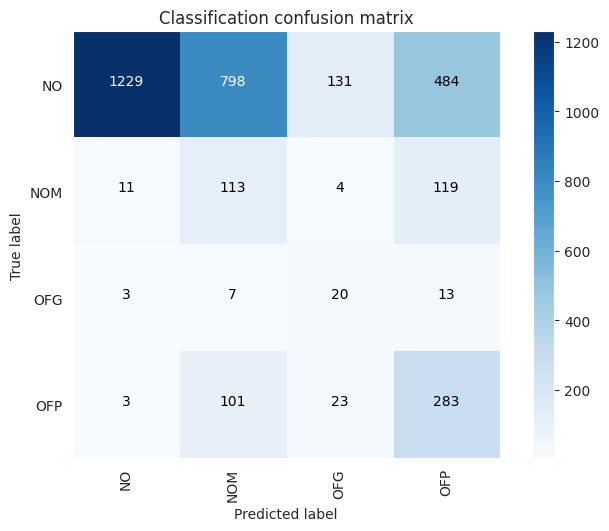

In [ ]:
metrics_calculator.plot_confusion_matrix()

In [ ]:
gpt35_tsv_file: str = os.path.join(flow_output_folder, "orig_test_set_chatgpt_classif_results.tsv")
InferenceResultsTSVPrinter().print(results=list(inf_res.values()), true_labels=true_labels, output_file=gpt35_tsv_file)

              precision    recall  f1-score   support

        hate     0.3148    0.7483    0.4431       453
     no_hate     0.9497    0.7445    0.8347      2889

    accuracy                         0.7451      3342
   macro avg     0.6322    0.7464    0.6389      3342
weighted avg     0.8636    0.7451    0.7816      3342



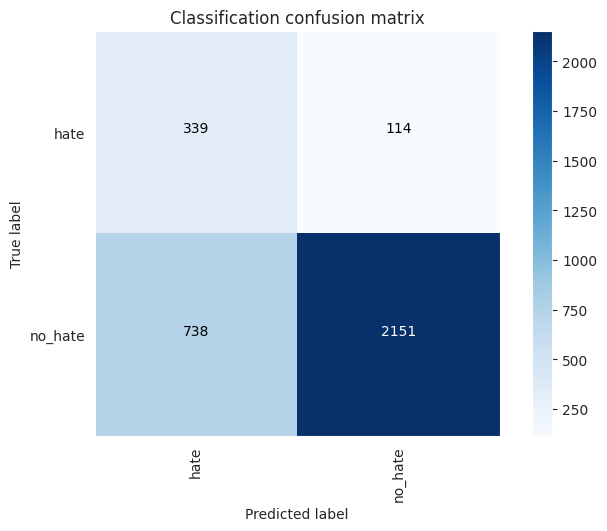

In [ ]:
# Compute binary metrics
gpt35_tsv_file: str = os.path.join(flow_output_folder, "orig_test_set_chatgpt_classif_results.tsv")
df_from_file = pd.read_csv(gpt35_tsv_file, quotechar='"', header=0, sep="\t")
hf_config: HateSpeechConfig = HateSpeechConfig()
y_true_binary: list[str] = [hf_config.map_to_binary_label(l) for l in df_from_file["true_label"]]
y_pred_binary: list[str] = [hf_config.map_to_binary_label(l) for l in df_from_file["pred_label"]]
metrics_calculator = ClassifMetricsCalculator(true_labels=y_true_binary, pred_labels=y_pred_binary)

print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

Las métricas obtenidas son: **35.60% de macro-f1 (multi-class) y 63.89% de macro-f1 (binary).**

Mirando los resultados, podemos ver que la performance es bastante pobre, inclusive sobre el test set original. Notamos que:
- `NO`: precision es alta y recall es bajo. Significa que el modelo cuando predice algo como esta clase, esa predicción suele ser correcta casi siempre. Sin embargo, deja pasar muchos samples pertenecientes a esta clase, que termina catalogando como de otra clase (bajo recall).
- `NOM`: precision y recall bajos. Precision es realmente muy bajo, con lo cual el modelo prácticamente siempre que predice algo como de esta clase, está equivocado. Esto puede indicarnos que las anotaciones quizás no estén tan bien calibradas, o que sean muy confusas con las dadas para las clases `OFP` u `OFG`. Mirando la matriz de confusión, podemos darnos cuenta de que una gran parte de los samples anotados como `NOM` son predichos por este modelo como `OFP`.
- `OFP`: precision muy baja, recall un poco mejor. Nuevamente, si vemos la matriz de confusión nos damos cuenta de que el modelo predice `NOM` para una gran cantidad de samples anotados como `OFP`.
- `OFG`: precision y recall bajos. Precision es realmente muy bajo (caso muy similar al de `NOM`). El modelo tiende a confudir esta clase con `OFP` y `NOM`.

Haciendo el análisis para el mapeo de estas labels a sus clases binarias, tenemos:
- `no_hate`: precision alta y recall no tan malo.
- `hate`: precision muy baja y recall no tan malo. En este caso, mirando la matriz de confusión, vemos que el modelo tiende a predecir muchas veces `hate`, para casos que son anotados como `no_hate`. Nuevamente, podríamos chequear esos casos para ver si fueron mal anotados o no.





**BINARY-CLASS**

Misma prueba que antes, pero pidiéndole al modelo que haga la clasificación sobre las clases de `hate` y `no_hate`. La idea es comparar la performance en ambos casos.

In [ ]:
openai_runner: OpenAIRunner = OpenAIRunner(config=OpenAIConfig(api_token=OPEN_AI_KEY))

prompt_str: str = """
Detect whether the text in Spanish surrounded by triple backticks contain hate speech or not. Answer only with "hate" or "no_hate".

```
{comment}
```
"""
classif_prompt_template: PromptTemplate = PromptTemplate.from_template(prompt_str)

# Build inference items & pass them
inf_items: list[InferenceItem] = [
    InferenceItem(id=row["comment_id"], prompt=classif_prompt_template.format(comment=row["comment"])) for _idx, row in
    orig_test_set_df.iterrows()]
inf_res: dict[int, InferenceResult] = openai_runner.run(items=inf_items)

# Compute metrics on the test set
true_labels: list[str] = [row["label_binary"] for _idx, row in orig_test_set_df.iterrows()]
pred_labels: list[str] = [r.response for r in inf_res.values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels,
                                              label2idx=hs_config.labels2index(binary=True))

              precision    recall  f1-score   support

     no_hate     0.9807    0.6507    0.7824      2889
        hate     0.2919    0.9183    0.4430       453

    accuracy                         0.6870      3342
   macro avg     0.6363    0.7845    0.6127      3342
weighted avg     0.8873    0.6870    0.7364      3342



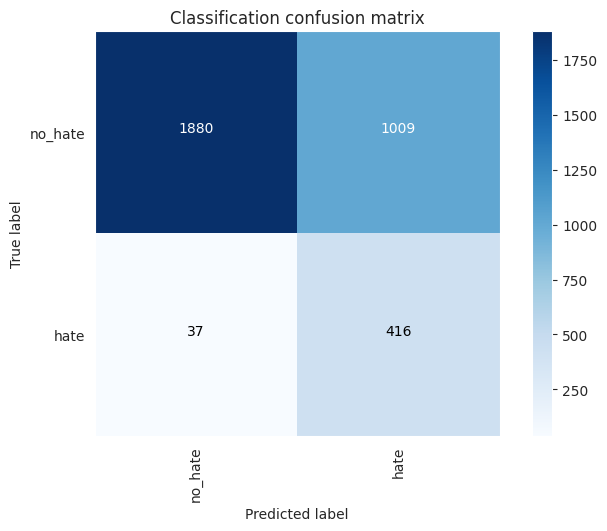

In [ ]:
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

In [ ]:
gpt35_tsv_file: str = os.path.join(flow_output_folder, "orig_test_set_chatgpt_classif_results_binary.tsv")
InferenceResultsTSVPrinter().print(results=list(inf_res.values()), true_labels=true_labels, output_file=gpt35_tsv_file)

La **macro-F1 para la tarea (binary classification) es del 61.27%**. Para nuestra sorpresa, la performance es ligeramente menor a la que obtuvimos cuando hicimos al modelo elegir entre cuatro labels. El motivo de esto puede deberse a las prompts que utilizamos en cada caso.

##### Evaluar contra todo el test set V1

**MULTI-CLASS**

In [ ]:
openai_runner: OpenAIRunner = OpenAIRunner(config=OpenAIConfig(api_token=OPEN_AI_KEY))

prompt_str: str = """
Classify the text in Spanish surrounded by triple backticks into one of these four categories for hate-speech detection. Provide only the corresponding label for your answer:
- OFP: Offensive, the target is a person.
- OFG: Offensive, the target is a group of people or a collective.
- NOM: Not offensive, though with inappropriate or insulting language.
- NO: Not offensive.

```
{comment}
```
"""
classif_prompt_template: PromptTemplate = PromptTemplate.from_template(prompt_str)

# Build inference items & pass them
inf_items: list[InferenceItem] = [
    InferenceItem(id=row["comment_id"], prompt=classif_prompt_template.format(comment=row["comment"])) for _idx, row in
    v1_test_set_df.iterrows()]
inf_res: dict[int, InferenceResult] = openai_runner.run(items=inf_items)

# Compute metrics on the test set
true_labels: list[str] = [row["label"] for _idx, row in v1_test_set_df.iterrows()]
pred_labels: list[str] = [r.response for r in inf_res.values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])

Starting inference for: 3336 items!


100%|██████████| 3336/3336 [51:09<00:00,  1.09it/s] 


Inference done!.
              precision    recall  f1-score   support

          NO     0.9871    0.3774    0.5460      2642
         NOM     0.1049    0.4211    0.1680       247
         OFG     0.0747    0.4186    0.1268        43
         OFP     0.2285    0.6188    0.3338       404

    accuracy                         0.4104      3336
   macro avg     0.3488    0.4590    0.2936      3336
weighted avg     0.8182    0.4104    0.4869      3336



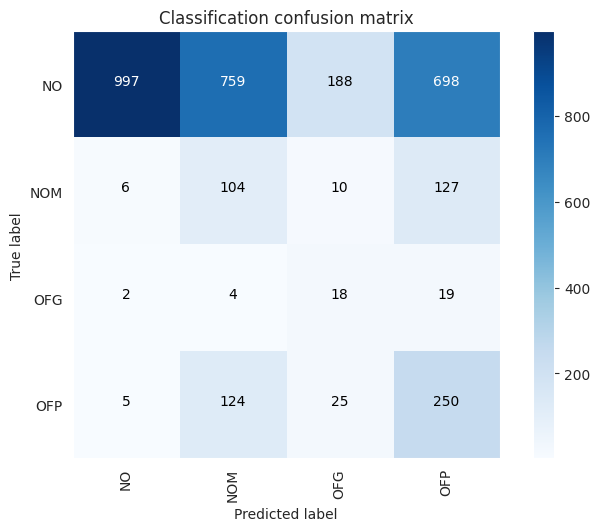

In [ ]:
metrics_calculator.plot_confusion_matrix()

In [ ]:
gpt35_tsv_file: str = os.path.join(flow_output_folder, "test_set_v1_chatgpt_classif_results.tsv")
InferenceResultsTSVPrinter().print(results=list(inf_res.values()), true_labels=true_labels, output_file=gpt35_tsv_file)

              precision    recall  f1-score   support

        hate     0.2337    0.6980    0.3502       447
     no_hate     0.9325    0.6459    0.7632      2889

    accuracy                         0.6529      3336
   macro avg     0.5831    0.6719    0.5567      3336
weighted avg     0.8389    0.6529    0.7078      3336



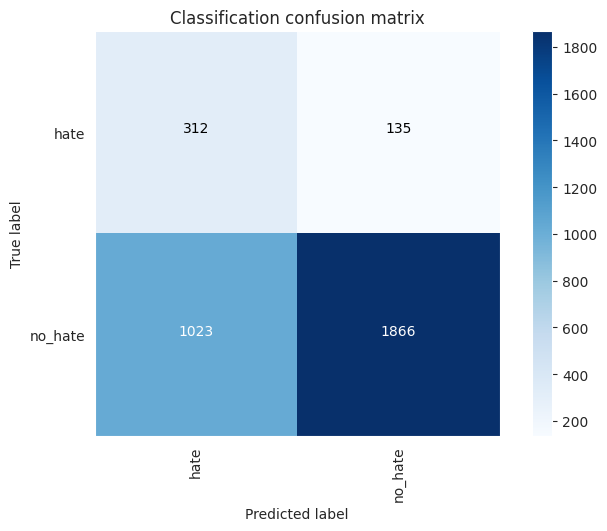

In [ ]:
# Compute binary metrics
gpt35_tsv_file: str = os.path.join(flow_output_folder, "test_set_v1_chatgpt_classif_results.tsv")
df_from_file = pd.read_csv(gpt35_tsv_file, quotechar='"', header=0, sep="\t")
hf_config: HateSpeechConfig = HateSpeechConfig()
y_true_binary: list[str] = [hf_config.map_to_binary_label(l) for l in df_from_file["true_label"]]
y_pred_binary: list[str] = [hf_config.map_to_binary_label(l) for l in df_from_file["pred_label"]]
metrics_calculator = ClassifMetricsCalculator(true_labels=y_true_binary, pred_labels=y_pred_binary)

print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

Las métricas obtenidas son: **29.36% de macro-f1 (multi-class) y 55.67% de macro-f1 (binary).**

Como podemos notar, el cleanup que estamos haciendo (si bien no es muy disruptivo), termina quitando información que hace que tengamos una performance más pobre a la que tenemos usando el test set sin ser alterado.

Más allá de esto, las patologías que observamos en las matrices de confusión en el reporte de clasificación son muy parecidas a las vistas con el test set original.

**BINARY-CLASS**

Repetimos la prueba anterior, pero pidiendo al modelo que elija sólo entre los labels binarios.

              precision    recall  f1-score   support

     no_hate     0.9658    0.7130    0.8204      2889
        hate     0.3109    0.8367    0.4533       447

    accuracy                         0.7296      3336
   macro avg     0.6383    0.7749    0.6369      3336
weighted avg     0.8780    0.7296    0.7712      3336



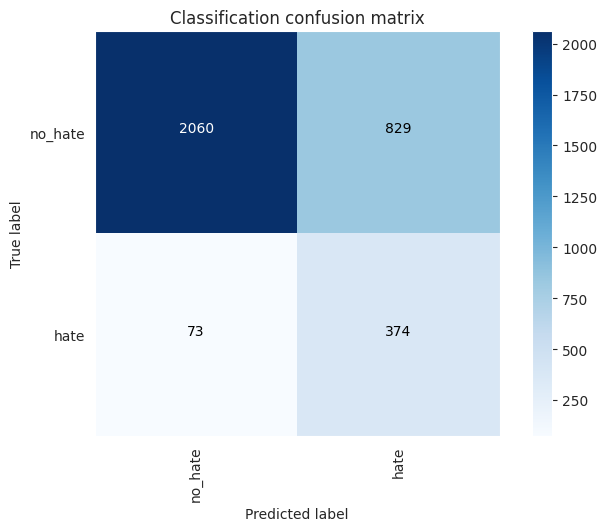

In [ ]:
openai_runner: OpenAIRunner = OpenAIRunner(config=OpenAIConfig(api_token=OPEN_AI_KEY))

prompt_str: str = """
Detect whether the text in Spanish surrounded by triple backticks contain hate speech or not. Answer only with "hate" or "no_hate".

```
{comment}
```
"""
classif_prompt_template: PromptTemplate = PromptTemplate.from_template(prompt_str)

# Build inference items & pass them
inf_items: list[InferenceItem] = [
    InferenceItem(id=row["comment_id"], prompt=classif_prompt_template.format(comment=row["comment"])) for _idx, row in
    v1_test_set_df.iterrows()]
inf_res: dict[int, InferenceResult] = openai_runner.run(items=inf_items)

# Compute metrics on the test set
true_labels: list[str] = [row["label_binary"] for _idx, row in v1_test_set_df.iterrows()]
pred_labels: list[str] = [r.response for r in inf_res.values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels,
                                              label2idx=hs_config.labels2index(binary=True))

print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

In [ ]:
gpt35_tsv_file: str = os.path.join(flow_output_folder, "test_set_v1_chatgpt_classif_results_binary.tsv")
InferenceResultsTSVPrinter().print(results=list(inf_res.values()), true_labels=true_labels, output_file=gpt35_tsv_file)

En este caso, vemos que sí que obtenemos mucha mejor performance al hacer la inferencia con las clases binarias que con todas las cuatro labels.

Por otro lado, podemos comprobar, dado que no hemos tenido ningún error en las predicciones, que el modelo siempre responde con las labels que le pedimos, lo cual es bastante esperable por ser ChatGPT.

_Comparando los resultados contra los obtenidos en flows anteriores con técnicas mucho más sencillas, vemos que en este caso ChatGPT se queda bastante por detŕás en performance zero-shot para esta tarea. Probablemente se deba a que los datos está en español y no en inglés._

#### GPT-4

A continuación, utilizando la misma prompt que antes, la pasaremos por [GPT-4](https://arxiv.org/abs/2303.08774), a ver si logramos mejorar los resultados de `GPT-3.5`.

##### Evaluar contra todo el test set. Primero, el original

Misma prueba que la que hicimos con ChatGPT, pero ahora con GPT-4.

**MULTI-CLASS**

Starting inference for: 3342 items!


100%|██████████| 3342/3342 [1:02:20<00:00,  1.12s/it]


Inference done!.
              precision    recall  f1-score   support

          NO     0.9828    0.7350    0.8411      2642
         NOM     0.2961    0.5466    0.3841       247
         OFG     0.2195    0.4186    0.2880        43
         OFP     0.4457    0.9000    0.5961       410

    accuracy                         0.7373      3342
   macro avg     0.4860    0.6501    0.5273      3342
weighted avg     0.8563    0.7373    0.7701      3342



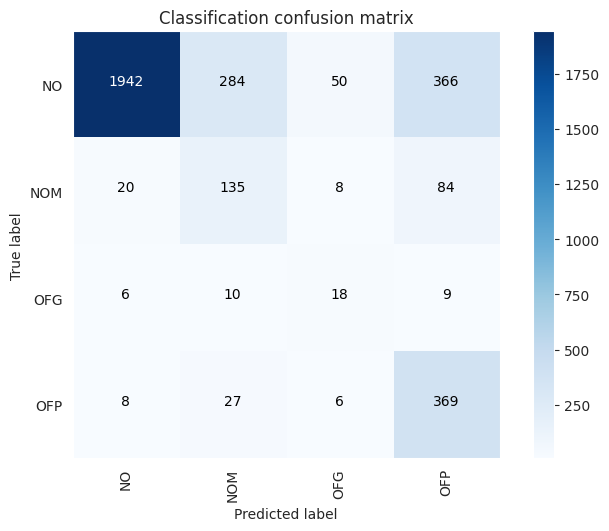

In [ ]:
openai_runner: OpenAIRunner = OpenAIRunner(
    config=OpenAIConfig(api_token=OPEN_AI_KEY, model_name=OpenAIModel.GPT_4.value))

prompt_str: str = """
Classify the text in Spanish surrounded by triple backticks into one of these four categories for hate-speech detection. Provide only the corresponding label for your answer:
- OFP: Offensive, the target is a person.
- OFG: Offensive, the target is a group of people or a collective.
- NOM: Not offensive, though with inappropriate or insulting language.
- NO: Not offensive.

```
{comment}
```
"""
classif_prompt_template: PromptTemplate = PromptTemplate.from_template(prompt_str)

# Build inference items & pass them
inf_items: list[InferenceItem] = [
    InferenceItem(id=row["comment_id"], prompt=classif_prompt_template.format(comment=row["comment"])) for _idx, row in
    orig_test_set_df.iterrows()]
inf_res: dict[int, InferenceResult] = openai_runner.run(items=inf_items)

# Compute metrics on the test set
true_labels: list[str] = [row["label"] for _idx, row in orig_test_set_df.iterrows()]
pred_labels: list[str] = [r.response for r in inf_res.values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

              precision    recall  f1-score   support

        hate     0.4418    0.8874    0.5899       453
     no_hate     0.9790    0.8242    0.8949      2889

    accuracy                         0.8327      3342
   macro avg     0.7104    0.8558    0.7424      3342
weighted avg     0.9062    0.8327    0.8536      3342



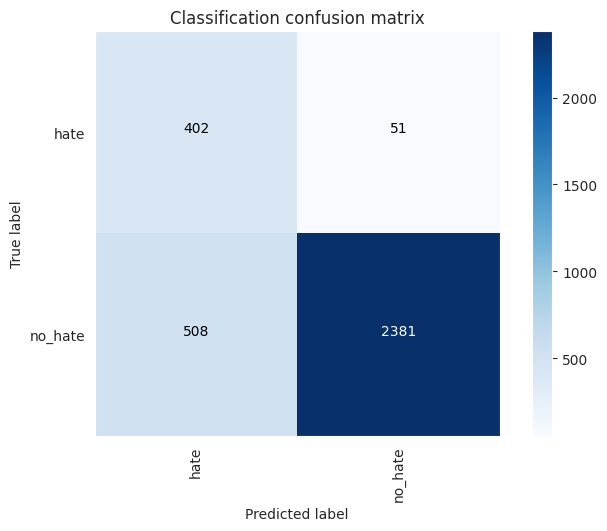

In [ ]:
hf_config: HateSpeechConfig = HateSpeechConfig()
y_true_binary: list[str] = [hf_config.map_to_binary_label(l) for l in true_labels]
y_pred_binary: list[str] = [hf_config.map_to_binary_label(l) for l in pred_labels]
metrics_calculator = ClassifMetricsCalculator(true_labels=y_true_binary, pred_labels=y_pred_binary)

print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

In [ ]:
gpt4_tsv_file: str = os.path.join(flow_output_folder, "orig_test_set_gpt4_classif_results.tsv")
InferenceResultsTSVPrinter().print(results=list(inf_res.values()), true_labels=true_labels, output_file=gpt4_tsv_file)

En este caso, obtenemos una **performance de 52.73% de macro-f1 (multi-class) y 74.4% macro-f1 (binary)**. Este performance es más similar a la obtenida por los modelos de ML pero aún bastante por debajo.

##### Evaluar contra todo el test set V1

**MULTI-CLASS**

In [ ]:
openai_runner: OpenAIRunner = OpenAIRunner(
    config=OpenAIConfig(api_token=OPEN_AI_KEY, model_name=OpenAIModel.GPT_4.value))

prompt_str: str = """
Classify the text in Spanish surrounded by triple backticks into one of these four categories for hate-speech detection. Provide only the corresponding label for your answer:
- OFP: Offensive, the target is a person.
- OFG: Offensive, the target is a group of people or a collective.
- NOM: Not offensive, though with inappropriate or insulting language.
- NO: Not offensive.

```
{comment}
```
"""
classif_prompt_template: PromptTemplate = PromptTemplate.from_template(prompt_str)

# Build inference items & pass them
inf_items: list[InferenceItem] = [
    InferenceItem(id=row["comment_id"], prompt=classif_prompt_template.format(comment=row["comment"])) for _idx, row in
    v1_test_set_df.iterrows()]
inf_res: dict[int, InferenceResult] = openai_runner.run(items=inf_items)

# Compute metrics on the test set
true_labels: list[str] = [row["label"] for _idx, row in v1_test_set_df.iterrows()]
pred_labels: list[str] = [r.response for r in inf_res.values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])

Starting inference for: 3336 items!


  0%|          | 0/3336 [00:00<?, ?it/s]/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(
100%|██████████| 3336/3336 [1:01:19<00:00,  1.10s/it]

Inference done!.
              precision    recall  f1-score   support

          NO     0.9693    0.7778    0.8631      2642
         NOM     0.2192    0.3887    0.2803       247
         OFG     0.1605    0.3023    0.2097        43
         OFP     0.4462    0.7698    0.5649       404

    accuracy                         0.7419      3336
   macro avg     0.4488    0.5597    0.4795      3336
weighted avg     0.8400    0.7419    0.7754      3336



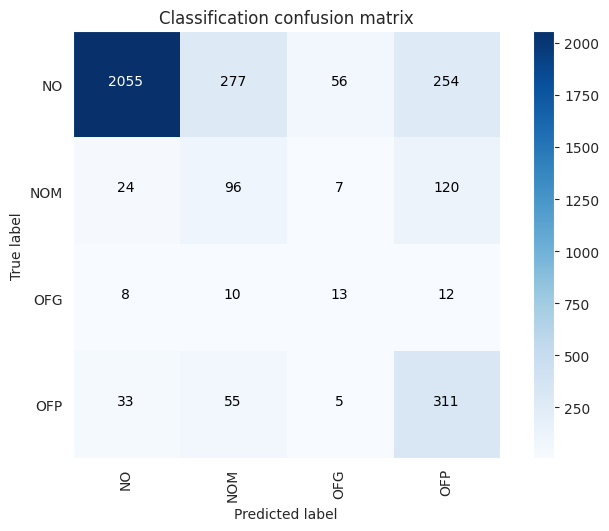

In [ ]:
metrics_calculator.plot_confusion_matrix()

              precision    recall  f1-score   support

        hate     0.4383    0.7629    0.5567       447
     no_hate     0.9586    0.8487    0.9003      2889

    accuracy                         0.8372      3336
   macro avg     0.6984    0.8058    0.7285      3336
weighted avg     0.8889    0.8372    0.8543      3336



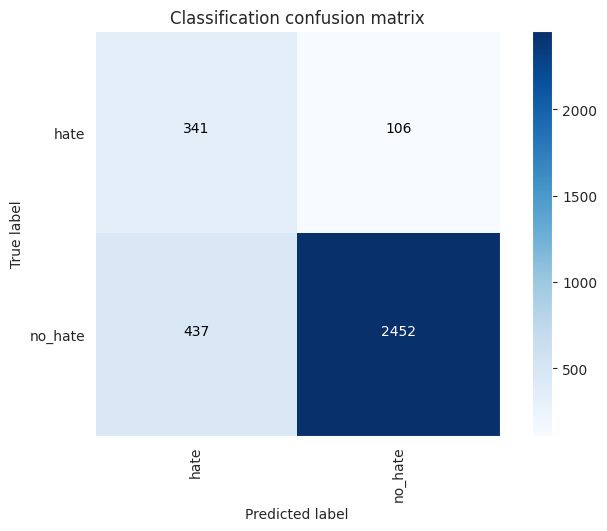

In [ ]:
hf_config: HateSpeechConfig = HateSpeechConfig()
y_true_binary: list[str] = [hf_config.map_to_binary_label(l) for l in true_labels]
y_pred_binary: list[str] = [hf_config.map_to_binary_label(l) for l in pred_labels]
metrics_calculator = ClassifMetricsCalculator(true_labels=y_true_binary, pred_labels=y_pred_binary)

print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

In [ ]:
gpt4_tsv_file: str = os.path.join(flow_output_folder, "test_set_v1_gpt4_classif_results.tsv")
InferenceResultsTSVPrinter().print(results=list(inf_res.values()), true_labels=true_labels, output_file=gpt4_tsv_file)

En este caso, obtenemos una performance de **47.95% de macro-f1 (multi-class) y 72.85% macro-f1 (binary)**. Los resultados son mejores a los obtenidos por ChatGPT, pero son mucho peores que los obtenidos con modelos mucho más simples como lo ML-based.

Nuevamente podemos notar que la performance se degrada para este modelo al recomputar las mismas métricas con el test set de `v1`.

##### Evaluar contra todo el test set V4

La performance obtenida en este caso y en el original, deberían ser bastante parecidas, porque el cleanup es muy light para esta configuración.

**MULTI-CLASS**

In [ ]:
openai_runner: OpenAIRunner = OpenAIRunner(
    config=OpenAIConfig(api_token=OPEN_AI_KEY, model_name=OpenAIModel.GPT_4.value))

prompt_str: str = """
Classify the text in Spanish surrounded by triple backticks into one of these four categories for hate-speech detection. Provide only the corresponding label for your answer:
- OFP: Offensive, the target is a person.
- OFG: Offensive, the target is a group of people or a collective.
- NOM: Not offensive, though with inappropriate or insulting language.
- NO: Not offensive.

```
{comment}
```
"""
classif_prompt_template: PromptTemplate = PromptTemplate.from_template(prompt_str)

# Build inference items & pass them
inf_items: list[InferenceItem] = [
    InferenceItem(id=row["comment_id"], prompt=classif_prompt_template.format(comment=row["comment"])) for _idx, row in
    v4_test_set_df.iterrows()]
inf_res: dict[int, InferenceResult] = openai_runner.run(items=inf_items)

# Compute metrics on the test set
true_labels: list[str] = [row["label"] for _idx, row in v4_test_set_df.iterrows()]
pred_labels: list[str] = [r.response for r in inf_res.values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])

Starting inference for: 3342 items!


100%|██████████| 3342/3342 [1:01:51<00:00,  1.11s/it]

Inference done!.
              precision    recall  f1-score   support

          NO     0.9810    0.7434    0.8458      2642
         NOM     0.2929    0.5182    0.3743       247
         OFG     0.2208    0.3953    0.2833        43
         OFP     0.4479    0.9024    0.5987       410

    accuracy                         0.7418      3342
   macro avg     0.4857    0.6398    0.5255      3342
weighted avg     0.8550    0.7418    0.7734      3342



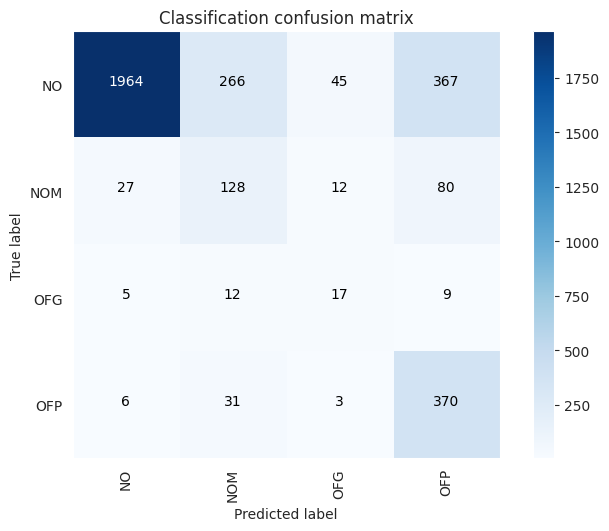

In [ ]:
metrics_calculator.plot_confusion_matrix()

              precision    recall  f1-score   support

        hate     0.4419    0.8808    0.5885       453
     no_hate     0.9779    0.8255    0.8953      2889

    accuracy                         0.8330      3342
   macro avg     0.7099    0.8532    0.7419      3342
weighted avg     0.9052    0.8330    0.8537      3342



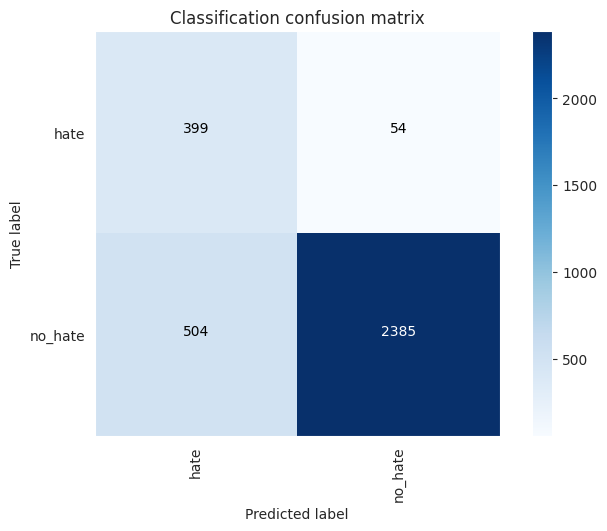

In [ ]:
hf_config: HateSpeechConfig = HateSpeechConfig()
y_true_binary: list[str] = [hf_config.map_to_binary_label(l) for l in true_labels]
y_pred_binary: list[str] = [hf_config.map_to_binary_label(l) for l in pred_labels]
metrics_calculator = ClassifMetricsCalculator(true_labels=y_true_binary, pred_labels=y_pred_binary)

print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

In [ ]:
gpt4_tsv_file: str = os.path.join(flow_output_folder, "test_set_v4_gpt4_classif_results.tsv")
InferenceResultsTSVPrinter().print(results=list(inf_res.values()), true_labels=true_labels, output_file=gpt4_tsv_file)

Para este caso, obtenemos una performance de **52.55% de macro-f1 (multi-class) y 74.19% de macro-f1 (binary)**. Vemos que esta performance es muy similar a la que obtenemos sobre el test set original. Es un poco lo esperado debido a lo light del cleanup que estmamos haciendo.

### Zero Shot Classification Pipeline

Considerando los resultados que venimos teniendo hasta el momento, cuesta creer que vamos a tener una performance superadora a través de los modelos de [Zero Shot Classification Pipeline](https://huggingface.co/tasks/zero-shot-classification) de HuggingFace. El idioma nos juega en contra, y por otro lado, ahora tenemos 4 labels sobre las que deberían ser capaces de distinguir en vez de sólo dos como teníamos en prácticas anteriores.

Sin embargo, podemos dejar listados los [modelos](https://huggingface.co/tasks/zero-shot-classification) que nos podrían servir, y realizar al menos una prueba con alguno de ellos para evaluar la tarea que tenemos **pero de forma binaria**. Para el caso multi-class, también podríamos probarlo, pero deberíamos poner los labels de forma de que sean un poco más descriptivos. Podríamos plantear algo así:
- `NO`: `no_hate`
- `NOM`: `no_hate_inappropriate_vocabulary`
- `OFP`: `individual_hate`
- `OFG`: `group_hate`

Este approach, utiliza un pre-trained language model y nos permite pasar tanto el comment como la lista de labels a utilizar, y entonces asignará una probabilidad a cada una de ellas.

Es muy importante elegir algún modelo que sea multilingual, porque obviamente nuestros datos están en español. Mirando el conjunto de los más populares, me inclinaré por probar [MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7](https://huggingface.co/MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7). Es muy importante también tener en cuenta que como es zeros-shot, el nombre que le pongamos a cada label marcará una gran diferencia en los resultados. Esto no será hiper-optimizado en este caso.

Hay más opciones posibles, que se pueden mostrar en la siguiente imagen:

![image](../resources/zero-shot-classification-alternatives.png)

In [ ]:
# Select some samples to test
zcs_labels: list[str] = ["no_hate", "no_hate_inappropriate_vocabulary", "individual_hate", "group_hate"]
samples: list[str] = []
for label in hs_config.labels:
    samples.extend(list(orig_test_set_df[orig_test_set_df["label"] == label]["comment"].sample(1)))

samples

['recien ahorita vi el video, lo veia como recomendado pero no lo  abri por que aqui pense que era eso mismo de marketing  me refiero a la imagen de video ajjaja por cierto  que buena intro estoy aqui despues de 6 dias xD',
 'Espero que este vídeo sea de coña. Espero que estés haciendo humor como siempre haces y el que me gusta. Todo lo que pasó en esa entrevistas fue coña pura y dura, para empezar, ¿cómo va a hablar mal de su lugar de origen? te creería si el chaval viviera en Andorra y hablase mal de su lugar de origen, pero el tío sigue viviendo ahí, cerca de su familia. así que no viene a cuento eso que dices, que dejó mal a su municipio. no tiene sentido eso. otra cosa, no por llevar una cruz colgando de la oreja es un cani, yo personalmente soy negro y vivo en Argentina (está mal visto un negro con arcillos) y ando con buenas amistades, la gente no me mira mal, me tratan como yo trato a la gente, etc. realmente soy tu fan, y no lo digo estilo wismichu diciendo que era pambisito, 

In [ ]:
# Test to make sure that code works
config = ZeroShotClassificationConfig(
    cadence=0,
    model_name="MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7",  # huggingface model id
    device="cpu",
    labels=zcs_labels
)
runner = ZeroShotClassificationRunner(config)
items: list[InferenceItem] = [InferenceItem(id=idx, prompt=s) for idx, s in enumerate(samples)]
test_res = runner.run(
    items=items)
test_res

Starting inference for: 4 items!


100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

Inference done!.


{0: InferenceResult(id=0, prompt='recien ahorita vi el video, lo veia como recomendado pero no lo  abri por que aqui pense que era eso mismo de marketing  me refiero a la imagen de video ajjaja por cierto  que buena intro estoy aqui despues de 6 dias xD', response='no_hate_inappropriate_vocabulary', probas=0.4995376169681549),
 1: InferenceResult(id=1, prompt='Espero que este vídeo sea de coña. Espero que estés haciendo humor como siempre haces y el que me gusta. Todo lo que pasó en esa entrevistas fue coña pura y dura, para empezar, ¿cómo va a hablar mal de su lugar de origen? te creería si el chaval viviera en Andorra y hablase mal de su lugar de origen, pero el tío sigue viviendo ahí, cerca de su familia. así que no viene a cuento eso que dices, que dejó mal a su municipio. no tiene sentido eso. otra cosa, no por llevar una cruz colgando de la oreja es un cani, yo personalmente soy negro y vivo en Argentina (está mal visto un negro con arcillos) y ando con buenas amistades, la gente

In [ ]:
hs_config.labels

['NO', 'NOM', 'OFP', 'OFG']

Leyendo las frases que tenemos, la realidad es que alguno de los resultados del modelo no están mal.

#### [MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7](https://huggingface.co/MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7)

Este modelo tiene 279M de parámetros.

Starting inference for: 3342 items!


100%|██████████| 3342/3342 [04:55<00:00, 11.31it/s]


Inference done!.
              precision    recall  f1-score   support

          NO     0.8606    0.2665    0.4069      2642
         NOM     0.0476    0.3198    0.0829       247
         OFG     0.0556    0.2791    0.0927        43
         OFP     0.3405    0.5390    0.4174       410

    accuracy                         0.3040      3342
   macro avg     0.3261    0.3511    0.2500      3342
weighted avg     0.7264    0.3040    0.3802      3342



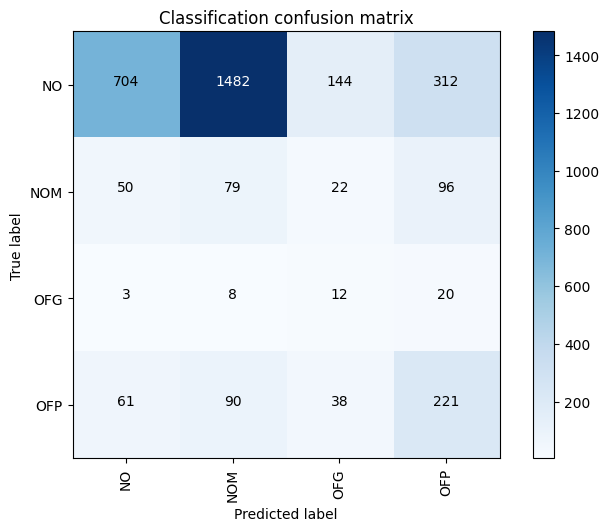

              precision    recall  f1-score   support

        hate     0.3364    0.6424    0.4416       453
     no_hate     0.9346    0.8013    0.8628      2889

    accuracy                         0.7798      3342
   macro avg     0.6355    0.7218    0.6522      3342
weighted avg     0.8535    0.7798    0.8057      3342



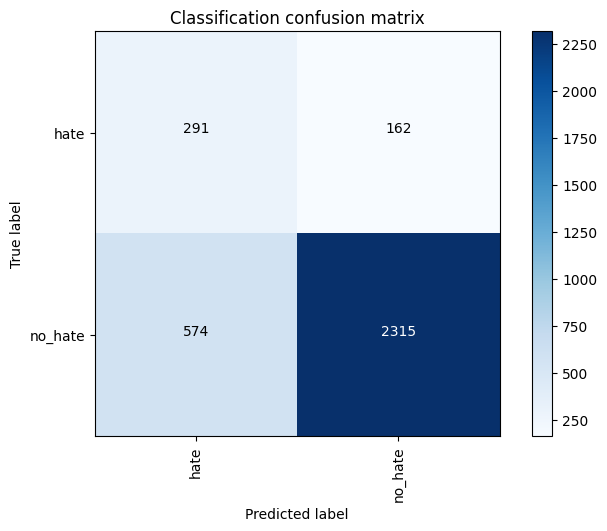

Done!


In [ ]:
# Run inference on dataset v4
zcs_labels: list[str] = ["no_hate", "no_hate_inappropriate_vocabulary", "individual_hate", "group_hate"]
zcs_to_labels: dict[str, str] = {
    "no_hate": "NO",
    "no_hate_inappropriate_vocabulary": "NOM",
    "individual_hate": "OFP",
    "group_hate": "OFG"
}

for dataset in [v4_test_set_df]:
    config = ZeroShotClassificationConfig(
        cadence=0,
        model_name="MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7",  # huggingface model id
        labels=zcs_labels
    )
    zscpip_runner = ZeroShotClassificationRunner(config)
    inf_items: list[InferenceItem] = [InferenceItem(id=row["comment_id"], prompt=row["comment"]) for _idx, row in
                                      dataset.iterrows()]
    inf_res: dict[int, InferenceResult] = zscpip_runner.run(items=inf_items)

    # Map back each result according to our mappings
    for v in inf_res.values():
        v.response = zcs_to_labels[v.response]

    # Multi-class performance  ====>
    true_labels: list[str] = [row["label"] for _idx, row in dataset.iterrows()]
    pred_labels: list[str] = [r.response for r in inf_res.values()]
    metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels, pred_labels=pred_labels)
    print(metrics_calculator.get_classification_report()[0])
    metrics_calculator.plot_confusion_matrix()

    # Binary performance ====>
    y_true_binary: list[str] = [hs_config.map_to_binary_label(l) for l in true_labels]
    y_pred_binary: list[str] = [hs_config.map_to_binary_label(l) for l in pred_labels]
    metrics_calculator = ClassifMetricsCalculator(true_labels=y_true_binary, pred_labels=y_pred_binary)
    print(metrics_calculator.get_classification_report()[0])
    metrics_calculator.plot_confusion_matrix()

    print("Done!")

Vemos que la performance es bastante mala como anticipábamos antes. Es muy complejo para el modelo hacer esta tarea de forma zero-shot, con datos en español y múltiples labels que podríamos seguir intentando optimizar.

La performance es del **25% de macro-f1 (multi-class) y 65.22% macro-f1 binary**.

Por lo que comentaba antes, esta es la única prueba que haré con la pipeline de Zero Shot Classification de HuggingFace.

### Hate Speech Detection con clasificadores pre-entrenados

Investigando un poco por HuggingFace, encontré algunos clasificadores pre-entrenados que podrían servirnos para probar su desempeño en esta tarea. El listado puede verse en [este link](https://huggingface.co/models?other=hate+speech) (notar que la mayoría de modelos allí presentes están pensados para inglés).

Nuevamente, nuestro caso es complejo, porque necesitamos modelos multilingual (o que estén entrenados en español) y que idealmente distingan las cuatro categorías que nosotros consideramos. En el peor de los casos, siempre podemos probar alguno sólo para la tarea binaria de clasificación como para reportar algún resultado

El listado propuesto para explorar es el siguiente:
- [Hate-speech-CNERG/dehatebert-mono-spanish](https://huggingface.co/Hate-speech-CNERG/dehatebert-mono-spanish) -> basado en BERT.
- [pysentimiento/robertuito-hate-speech](https://huggingface.co/pysentimiento/robertuito-hate-speech) -> basado en RoBERTa, fue entrenado con SemEval 2019 Task 5: HatEval (SubTask B) corpus. Este modelo es interesante porque tiene tres categorías, incluyendo `TR` que es para casos de hate que targetean un individuo (como nuestro `OFP`).
- [cardiffnlp/twitter-xlm-roberta-base-hate-spanish](https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-hate-spanish) -> versión fine-tuneada de [cardiffnlp/twitter-xlm-roberta-base](https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base) usando el dataset [HaterNet](https://zenodo.org/records/2592149) y el Spanish subset of [SemEval-2019 Task 5](https://aclanthology.org/S19-2007/).
- [piuba-bigdata/beto-contextualized-hate-speech](https://huggingface.co/piuba-bigdata/beto-contextualized-hate-speech) -> modelo que soporta muchas labels para hate speech contextualizado (como de racismo, política, mujeres, LGTBI, etc.)

Echando un rápido vistazo a los modelos más populares, podemos ver que casi todos ellos utilizan dos labels para la predicción: `["hate", "no_hate"]`. Por tanto, podemos evaluar la tarea de manera binaria únicamente.

Por popularidad, cantidad de descargas y similitud con nuestro caso, creo que tiene sentido probar `pysentimiento/robertuito-hate-speech`, de forma de poder al menos reportar algún resultado.

#### [pysentimiento/robertuito-hate-speech](https://huggingface.co/pysentimiento/robertuito-hate-speech)

Su [repositorio de GitHub](https://github.com/pysentimiento/pysentimiento) nos explica cómo podemos usarlo de forma sencilla. Como es una prueba muy adhoc, no la incluiré como parte de las pipelines de código que ya tengo.

De hecho, mirándolo en detalle vemos que es una librería interesante, porque también tienen un montón de funciones y de utilitarios para pre-procesar tweets por ejemplo. Podríamos haberlo considerado al definir nuestras reglas de cleanup.

In [ ]:
# !pip install pysentimiento

In [ ]:
from pysentimiento import create_analyzer
import transformers

transformers.logging.set_verbosity(transformers.logging.ERROR)

hate_speech_analyzer = create_analyzer(task="hate_speech", lang="es")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/956 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/435M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

AnalyzerOutput(output=[], probas={hateful: 0.020, targeted: 0.006, aggressive: 0.016})

This model is a multi-label classification algorithm, returning three different variables at the same time:

- Is the message hateful or not?
- Is the hateful message targeted at a specific person or a group?
- Is the hateful message aggressive?

In [ ]:
hate_speech_analyzer.predict("Esto es una mierda pero no es odio")

AnalyzerOutput(output=[], probas={hateful: 0.020, targeted: 0.006, aggressive: 0.016})

In [ ]:
hate_speech_analyzer.predict("Esto es odio porque los inmigrantes deben ser aniquilados")

AnalyzerOutput(output=['hateful', 'aggressive'], probas={hateful: 0.902, targeted: 0.009, aggressive: 0.539})

In [ ]:
hate_speech_analyzer.predict("Vaya guarra barata y de poca monta es Juana Pérez!")

AnalyzerOutput(output=['hateful', 'targeted', 'aggressive'], probas={hateful: 0.982, targeted: 0.982, aggressive: 0.964})

In [ ]:
hate_speech_analyzer.predict(["Esto es una mierda pero no es odio",
                              "Esto es odio porque los inmigrantes deben ser aniquilados",
                              "Vaya guarra barata y de poca monta es Juana Pérez!"])

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

[AnalyzerOutput(output=[], probas={hateful: 0.020, targeted: 0.006, aggressive: 0.016}),
 AnalyzerOutput(output=['hateful', 'aggressive'], probas={hateful: 0.902, targeted: 0.009, aggressive: 0.539}),
 AnalyzerOutput(output=['hateful', 'targeted', 'aggressive'], probas={hateful: 0.982, targeted: 0.982, aggressive: 0.964})]

Mirando esto, podemos sencillamente pasar nuestro test set por este analyzer y simplemente ver si `hateful` está presente en el output o no. Si lo está, catalogamos como `hate` y si no como `no_hate`.

Binary performance ============


Map:   0%|          | 0/3342 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

        hate     0.4654    0.3863    0.4222       453
     no_hate     0.9063    0.9304    0.9182      2889

    accuracy                         0.8567      3342
   macro avg     0.6858    0.6584    0.6702      3342
weighted avg     0.8465    0.8567    0.8510      3342



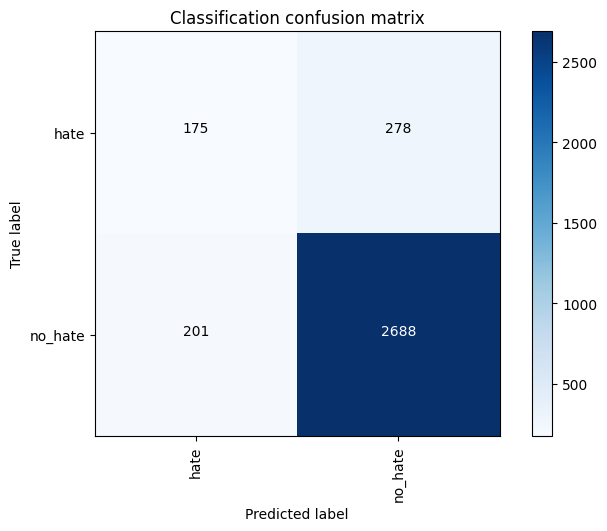

Done!


In [ ]:
for dataset in [v4_test_set_df]:
    comments: list[str] = [row["comment"] for _idx, row in dataset.iterrows()]

    # Binary performance performance  ====>
    print("Binary performance ============")
    true_labels: list[str] = [hs_config.map_to_binary_label(row["label"]) for _idx, row in dataset.iterrows()]
    analyzer_out: list = hate_speech_analyzer.predict(comments)

    pred_labels: list[str] = []
    for output in analyzer_out:
        label: str = "hate" if "hateful" in output.output else "no_hate"
        pred_labels.append(label)

    metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels, pred_labels=pred_labels)
    print(metrics_calculator.get_classification_report()[0])
    metrics_calculator.plot_confusion_matrix()
    print("Done!")

Quedé impresionado por la velocidad el modelo para hacer inferencia. Se nota que utiliza una arqitectura súper light. La performance no está mal la verdad, considerando que no fue entrenado en estos datos.

En este caso, obtenemos un **67.02% de macro-f1 para binary classification**.

Al igual que el resto de los modelos, tenemos siempre el mismo problema. El modelo suele hacerlo bien para `no_hate`, pero tiene baja precision y recall sobre `hate`.

## Entrenando un clasificador con nuestros datos

En este caso, haremos uso de nuestro dataset de reviews de entrenamiento para entrenar algunos modelos ya pre-entrenados (fine-tuning).


### Setfit Framework

Al igual que lo hice en la última práctica, optaré por utilizar [SetFit](https://github.com/huggingface/setfit) hacer fine-tuning de un sentence-transformer y poner una cabeza de clasificación al final de la arquictura.

Con este framework, podemos de manera bastante sencilla hacer un ligero fine tuning sobre alguno de los [SentenceTransformers](https://huggingface.co/models?library=sentence-transformers&sort=downloads) de HuggingFace, agregando una cabeza de clasificación para nuestro caso en particular con el conjunto de labels que queramos.

Esta tecnología la he empleado extensivamente en el trabajo y funciona muy bien inclusive con pocos datos labeleados de entrenameinto. Para este caso, haré uso de los que tenemos en el dataset de reviews y luego evaluaremos en el test set tal y como venimos haciendo hasta el momento.

Respecto a modelos, acá nuevamente tenemos que investigar sentence-transformers que funcionen bien para español, y que no sean excesivamente grandes, ya que de otra forma no nos alcanzará el hardware para hacer un fine-tuning. En [este link](https://www.sbert.net/examples/training/multilingual/README.html) tenemos un buen punto de partida.

En base a lo que investigué, estaŕia bueno explorar los siguientes modelos:
- [sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2) -> soporta 50 idiomas y mapea a un vector de 384 dimensiones. Tiene 118M de parámetros.
- [sentence-transformers/distiluse-base-multilingual-cased-v1](https://huggingface.co/sentence-transformers/distiluse-base-multilingual-cased-v1) -> soporta 14 idiomas y mapea a un vector de 512 dimensiones. Tiene 135M de parámetros.
- [sentence-transformers/LaBSE](https://huggingface.co/sentence-transformers/LaBSE) -> soporta más de 109 idiomas y mapea a un vector de 768 dimensiones. Lo he probado en el trabajo para intent classification y funciona muy bien. El downside que tiene es que es bastante más pesado que los dos anteriores, con lo cual puede ser que no podamos fine-tunearlo con SetFit. Tiene un total de 471M de parámetros.
- [BAAI/bge-m3](https://huggingface.co/BAAI/bge-m3) -> este modelo también lo hemos empleado en el trabajo para entrenar clasificadores multilingues, y siempre tuvo muy buena performance. Mapea a un vector de 1024 dimensiones, soporta más de 100 lenguajes y tiene alrededor de 600M de parámetros.

#### [sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2)

**Entrenando en v4**

Comenzaremos haciendo una prueba sobre `v4`, de una sola epoch para ver que podamos entrenar bien.

Notar que este dataset no tiene clases balanceadas.

In [ ]:
# Train for a single epoch to make sure it works
# Dataset is not balanced, for this test we don't care (we'll use a technique later)
v4_train_set_file_path: str = os.path.join(dataset_v4_folder, "train.csv")
v4_val_set_file_path: str = os.path.join(dataset_v4_folder, "val.csv")
v4_test_set_file_path: str = os.path.join(dataset_v4_folder, "test.csv")

setfit_train_df: pd.DataFrame = pd.read_csv(v4_train_set_file_path, quotechar='"', header=0, sep=",")
setfit_val_df: pd.DataFrame = pd.read_csv(v4_val_set_file_path, quotechar='"', header=0, sep=",")
setfit_test_df: pd.DataFrame = pd.read_csv(v4_test_set_file_path, quotechar='"', header=0, sep=",")

train_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                  _idx, row in setfit_train_df.iterrows()]
val_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                _idx, row in setfit_val_df.iterrows()]
test_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                 _idx, row in setfit_test_df.iterrows()]

config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        metric="accuracy",
        batch_size=16,
        num_iterations=2,
        num_epochs=1,
        add_early_stopping=False,
        early_stopping_patience=0
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...
Number of samples in training set: 10025
Number of samples in validation set: 3341


Map:   0%|          | 0/10025 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 40100
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 2507


  0%|          | 0/836 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 2507.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
***** Running evaluation *****


Finished model training. Took 0:10:41.761915 seconds
Starting evaluation...


Accuracy on validation set: 0.8578
Done!


MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...
Inference done!.
              precision    recall  f1-score   support

          NO     0.9248    0.9538    0.9391      2642
         NOM     0.6698    0.5830    0.6234       247
         OFG     0.5263    0.2326    0.3226        43
         OFP     0.6475    0.6049    0.6255       410

    accuracy                         0.8743      3342
   macro avg     0.6921    0.5936    0.6276      3342
weighted avg     0.8668    0.8743    0.8693      3342



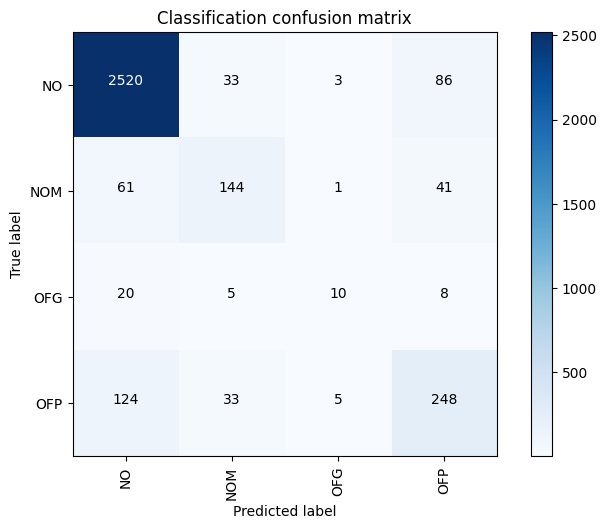


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.6741    0.5982    0.6339       453
     no_hate     0.9381    0.9547    0.9463      2889

    accuracy                         0.9063      3342
   macro avg     0.8061    0.7764    0.7901      3342
weighted avg     0.9023    0.9063    0.9040      3342



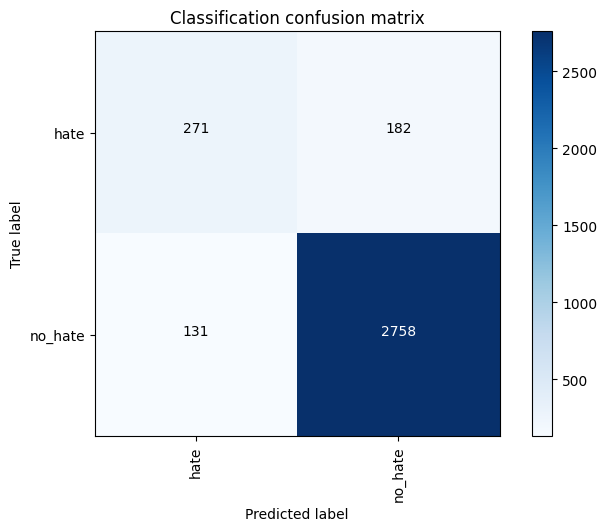

In [ ]:
print("MULTI-CLASS METRICS ===============================")
true_labels: list[str] = [t.label for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

print("\n BINARY-CLASS METRICS ===============================")
true_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in true_labels]
pred_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in pred_labels]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels_binary,
                                              pred_labels=pred_labels_binary)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()


Vemos que entrenando sobre `v4`, con una sola epoch, alcanzamos una performance de **62.76% de macro-f1 (multi-class) y 79.01% de macro-f1 (binary)**.

Repetiremos ahora la misma prueba pero balanceando el peso que cada sample tiene en la función de pérdida en función de su clase, tal y como probamos en `2_ml_baselines.ipynb`. Por lo que investigué, podemos setear la cabeza de clasificación de SetFit como `LogisticRegresssion` y pasarle el parámetro `class_weight="balanced"` tal y como hicimos antes. El código de cómo hacerse puede verse en la clase que utilizamos para entrenar.

In [ ]:
v4_train_set_file_path: str = os.path.join(dataset_v4_folder, "train.csv")
v4_val_set_file_path: str = os.path.join(dataset_v4_folder, "val.csv")
v4_test_set_file_path: str = os.path.join(dataset_v4_folder, "test.csv")

setfit_train_df: pd.DataFrame = pd.read_csv(v4_train_set_file_path, quotechar='"', header=0, sep=",")
setfit_val_df: pd.DataFrame = pd.read_csv(v4_val_set_file_path, quotechar='"', header=0, sep=",")
setfit_test_df: pd.DataFrame = pd.read_csv(v4_test_set_file_path, quotechar='"', header=0, sep=",")

train_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                  _idx, row in setfit_train_df.iterrows()]
val_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                _idx, row in setfit_val_df.iterrows()]
test_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                 _idx, row in setfit_test_df.iterrows()]

config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        metric="accuracy",
        batch_size=16,
        num_iterations=2,
        num_epochs=1,
        add_early_stopping=False,
        early_stopping_patience=0,
        balanced_class_weight=True  # here's the difference!
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...
Number of samples in training set: 10025
Number of samples in validation set: 3341


Map:   0%|          | 0/10025 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 40100
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 2507


  0%|          | 0/836 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 2507.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
***** Running evaluation *****


Finished model training. Took 0:11:56.490123 seconds
Starting evaluation...
Accuracy on validation set: 0.8423
Done!


MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Inference done!.
              precision    recall  f1-score   support

          NO     0.9450    0.9164    0.9304      2642
         NOM     0.5407    0.6721    0.5993       247
         OFG     0.1932    0.3953    0.2595        43
         OFP     0.5974    0.5610    0.5786       410

    accuracy                         0.8480      3342
   macro avg     0.5691    0.6362    0.5920      3342
weighted avg     0.8628    0.8480    0.8542      3342



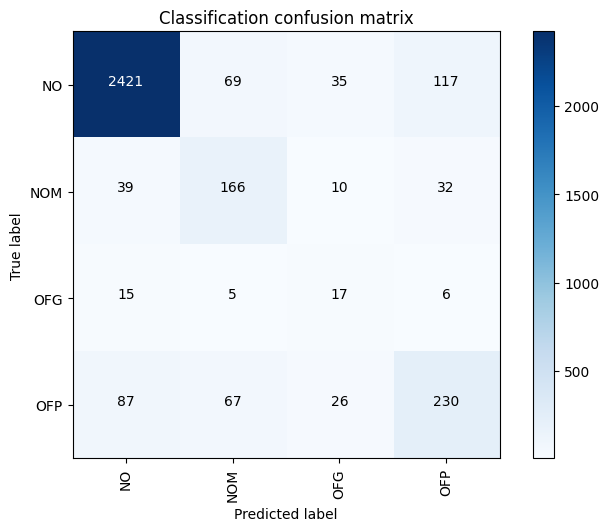


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.5899    0.6159    0.6026       453
     no_hate     0.9394    0.9328    0.9361      2889

    accuracy                         0.8899      3342
   macro avg     0.7646    0.7744    0.7693      3342
weighted avg     0.8920    0.8899    0.8909      3342



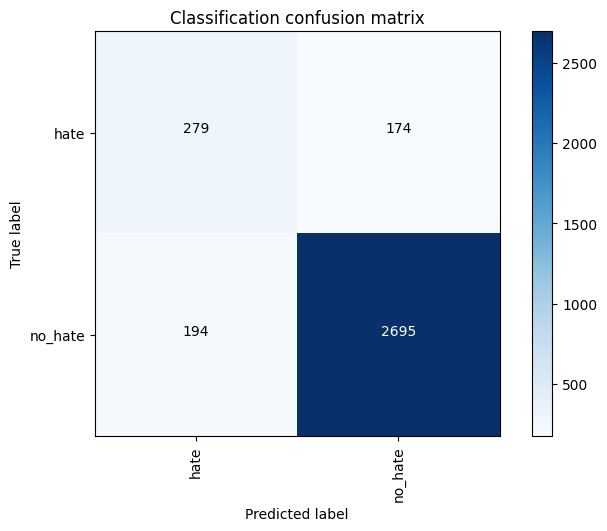

In [ ]:
print("MULTI-CLASS METRICS ===============================")
true_labels: list[str] = [t.label for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

print("\n BINARY-CLASS METRICS ===============================")
true_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in true_labels]
pred_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in pred_labels]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels_binary,
                                              pred_labels=pred_labels_binary)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

Aplicando esta técnica, **la performance que obtenemos es de 59.20% de macro-f1 (multi-class) y 76.93% de macro-f1 (binary)**. Esta performance es peor que la que obtuvimos cuando no aplicamos el class_weight sobre la cabeza de `LogisticRegression`, lo cual es un poco peculiar (hubiese esperado mejores resultados, no peores).

Sin embargo, por lo que estuve leyendo, hay personas que reportaron el mismo tipo de problemas (por ejemplo, en posts como [este](https://github.com/huggingface/setfit/issues/375)).

Algo que noté recień en este punto, es el warning que nos devuelve SetFIT respecto a la convergencia de la Logistic Regression head:

```
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
```

Una forma de típicamente resolver esto es incrementando el número máximo de iteraciones que podemos permitirle, así que lo modificaré dentro del mismo código donde creamos todo y repetiré la prueba.



In [ ]:
v4_train_set_file_path: str = os.path.join(dataset_v4_folder, "train.csv")
v4_val_set_file_path: str = os.path.join(dataset_v4_folder, "val.csv")
v4_test_set_file_path: str = os.path.join(dataset_v4_folder, "test.csv")

setfit_train_df: pd.DataFrame = pd.read_csv(v4_train_set_file_path, quotechar='"', header=0, sep=",")
setfit_val_df: pd.DataFrame = pd.read_csv(v4_val_set_file_path, quotechar='"', header=0, sep=",")
setfit_test_df: pd.DataFrame = pd.read_csv(v4_test_set_file_path, quotechar='"', header=0, sep=",")

train_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                  _idx, row in setfit_train_df.iterrows()]
val_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                _idx, row in setfit_val_df.iterrows()]
test_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                 _idx, row in setfit_test_df.iterrows()]

config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        metric="accuracy",
        batch_size=16,
        num_iterations=2,
        num_epochs=1,
        add_early_stopping=False,
        early_stopping_patience=0,
        balanced_class_weight=True,  # here's the difference!
        head_max_iter=3000
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...
Number of samples in training set: 10025
Number of samples in validation set: 3341


Map:   0%|          | 0/10025 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 40100
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 2507


  0%|          | 0/836 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 2507.
***** Running evaluation *****


Finished model training. Took 0:11:41.396388 seconds
Starting evaluation...
Accuracy on validation set: 0.842
Done!


MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...
Inference done!.
              precision    recall  f1-score   support

          NO     0.9435    0.9164    0.9297      2642
         NOM     0.5458    0.6761    0.6040       247
         OFG     0.2000    0.4186    0.2707        43
         OFP     0.5921    0.5488    0.5696       410

    accuracy                         0.8471      3342
   macro avg     0.5703    0.6400    0.5935      3342
weighted avg     0.8614    0.8471    0.8530      3342



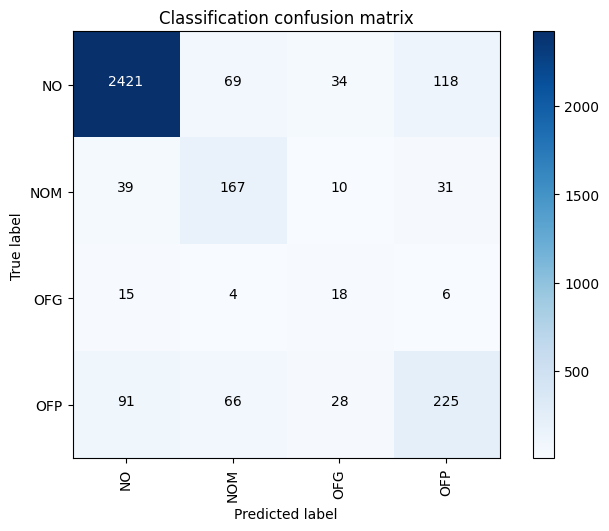


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.5894    0.6115    0.6002       453
     no_hate     0.9387    0.9332    0.9359      2889

    accuracy                         0.8896      3342
   macro avg     0.7640    0.7723    0.7681      3342
weighted avg     0.8914    0.8896    0.8904      3342



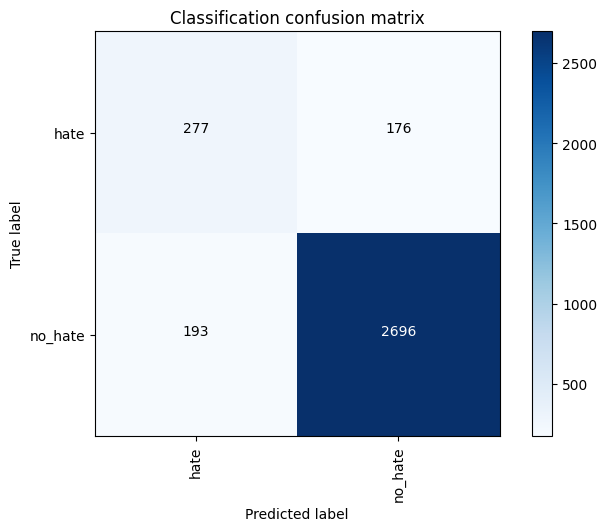

In [ ]:
print("MULTI-CLASS METRICS ===============================")
true_labels: list[str] = [t.label for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

print("\n BINARY-CLASS METRICS ===============================")
true_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in true_labels]
pred_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in pred_labels]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels_binary,
                                              pred_labels=pred_labels_binary)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

Vemos ahora que el warning ha desaparecido. Sin embargo, los resultados obtenidos son prácticamente los mismos que para el caso anterior. Sin embargo, me siento más cómodo sin que el warning ocurra.

Procederé a continuación a entrenar el modelo por algunas epochs adicionales, de forma de ver cómo performa. Usaré `EarlyStopping` para controlar y evitar que siga entrenando si la performance en validación comienza a empeorar.

In [ ]:
# Dataset is not balanced, won't apply any technique for this.
v4_train_set_file_path: str = os.path.join(dataset_v4_folder, "train.csv")
v4_val_set_file_path: str = os.path.join(dataset_v4_folder, "val.csv")
v4_test_set_file_path: str = os.path.join(dataset_v4_folder, "test.csv")

setfit_train_df: pd.DataFrame = pd.read_csv(v4_train_set_file_path, quotechar='"', header=0, sep=",")
setfit_val_df: pd.DataFrame = pd.read_csv(v4_val_set_file_path, quotechar='"', header=0, sep=",")
setfit_test_df: pd.DataFrame = pd.read_csv(v4_test_set_file_path, quotechar='"', header=0, sep=",")

train_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                  _idx, row in setfit_train_df.iterrows()]
val_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                _idx, row in setfit_val_df.iterrows()]
test_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                 _idx, row in setfit_test_df.iterrows()]

config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        metric="accuracy",
        batch_size=16,
        num_iterations=3,
        num_epochs=7,
        add_early_stopping=True,
        early_stopping_patience=2,
        balanced_class_weight=False
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...
Number of samples in training set: 10025
Number of samples in validation set: 3341


Map:   0%|          | 0/10025 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 60150
  Batch size = 16
  Num epochs = 7
  Total optimization steps = 26320


  0%|          | 0/1253 [00:00<?, ?it/s]

  0%|          | 0/1253 [00:00<?, ?it/s]

  0%|          | 0/1253 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 3760.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
***** Running evaluation *****


Finished model training. Took 0:34:03.662744 seconds
Starting evaluation...
Accuracy on validation set: 0.8626
Done!


MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...
Inference done!.
              precision    recall  f1-score   support

          NO     0.9220    0.9440    0.9329      2642
         NOM     0.5816    0.5628    0.5720       247
         OFG     0.3846    0.2326    0.2899        43
         OFP     0.6344    0.5756    0.6036       410

    accuracy                         0.8615      3342
   macro avg     0.6307    0.5787    0.5996      3342
weighted avg     0.8546    0.8615    0.8575      3342



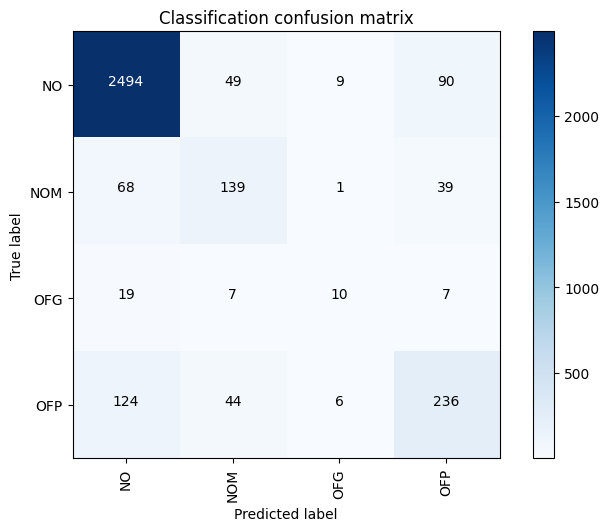


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.6508    0.5717    0.6087       453
     no_hate     0.9341    0.9519    0.9429      2889

    accuracy                         0.9004      3342
   macro avg     0.7924    0.7618    0.7758      3342
weighted avg     0.8957    0.9004    0.8976      3342



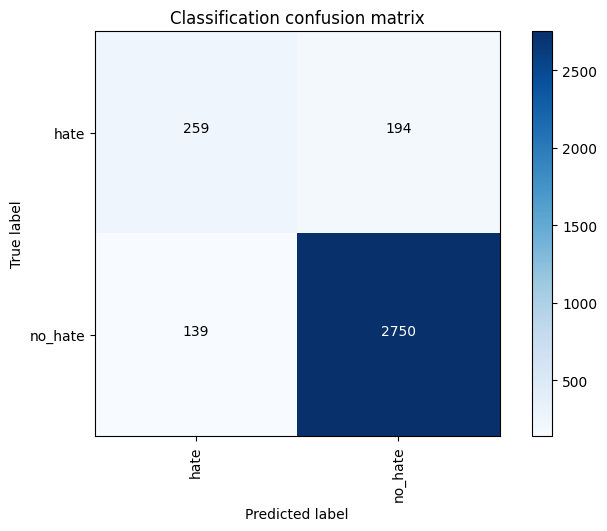

In [ ]:
print("MULTI-CLASS METRICS ===============================")
true_labels: list[str] = [t.label for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

print("\n BINARY-CLASS METRICS ===============================")
true_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in true_labels]
pred_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in pred_labels]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels_binary,
                                              pred_labels=pred_labels_binary)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

Entrenamos por más epochs, pero vemos que el modelo no mejora su performance. Por el contrario, la empeora. La embedding loss sube en vez de bajar, y los resultados son peores a cuando únicamente entrenábamos por una sola epoch.

Repetiré ahora lo mismo pero con la estrategia de balanceo a ver qué pasa.

In [ ]:
# Dataset is not balanced, but we're including it in the LogisticRegression head
v4_train_set_file_path: str = os.path.join(dataset_v4_folder, "train.csv")
v4_val_set_file_path: str = os.path.join(dataset_v4_folder, "val.csv")
v4_test_set_file_path: str = os.path.join(dataset_v4_folder, "test.csv")

setfit_train_df: pd.DataFrame = pd.read_csv(v4_train_set_file_path, quotechar='"', header=0, sep=",")
setfit_val_df: pd.DataFrame = pd.read_csv(v4_val_set_file_path, quotechar='"', header=0, sep=",")
setfit_test_df: pd.DataFrame = pd.read_csv(v4_test_set_file_path, quotechar='"', header=0, sep=",")

train_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                  _idx, row in setfit_train_df.iterrows()]
val_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                _idx, row in setfit_val_df.iterrows()]
test_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                 _idx, row in setfit_test_df.iterrows()]

config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        metric="accuracy",
        batch_size=16,
        num_iterations=3,
        num_epochs=7,
        add_early_stopping=True,
        early_stopping_patience=2,
        balanced_class_weight=True,
        head_max_iter=3000
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...
Number of samples in training set: 10025
Number of samples in validation set: 3341


Map:   0%|          | 0/10025 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 60150
  Batch size = 16
  Num epochs = 7
  Total optimization steps = 26320


  0%|          | 0/1253 [00:00<?, ?it/s]

  0%|          | 0/1253 [00:00<?, ?it/s]

  0%|          | 0/1253 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 3760.
***** Running evaluation *****


Finished model training. Took 0:33:34.906078 seconds
Starting evaluation...
Accuracy on validation set: 0.8488
Done!


MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Inference done!.
              precision    recall  f1-score   support

          NO     0.9370    0.9182    0.9275      2642
         NOM     0.5150    0.6275    0.5657       247
         OFG     0.2419    0.3488    0.2857        43
         OFP     0.6026    0.5732    0.5875       410

    accuracy                         0.8471      3342
   macro avg     0.5741    0.6169    0.5916      3342
weighted avg     0.8559    0.8471    0.8508      3342



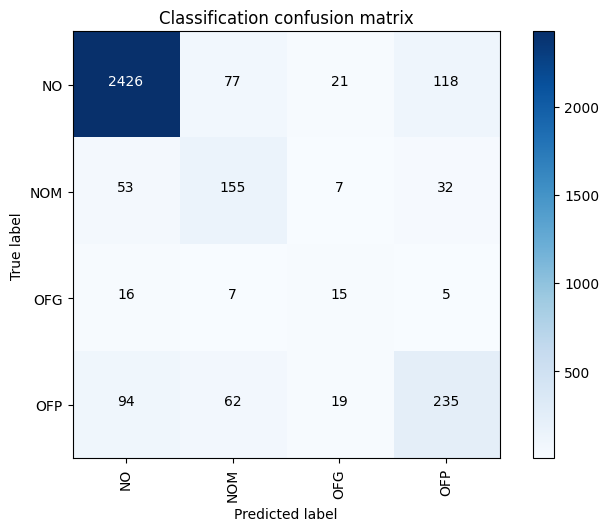


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.6062    0.6049    0.6055       453
     no_hate     0.9381    0.9384    0.9382      2889

    accuracy                         0.8932      3342
   macro avg     0.7721    0.7716    0.7719      3342
weighted avg     0.8931    0.8932    0.8931      3342



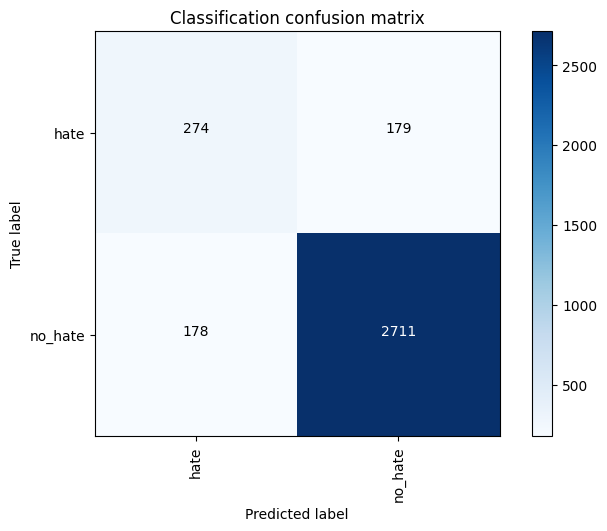

In [ ]:
print("MULTI-CLASS METRICS ===============================")
true_labels: list[str] = [t.label for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

print("\n BINARY-CLASS METRICS ===============================")
true_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in true_labels]
pred_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in pred_labels]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels_binary,
                                              pred_labels=pred_labels_binary)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

Misma conclusión que antes, obtenemos peores resultados al entrenar por más de una epoch que con una sola epoch.

**Entrenando con v5**

⚠️ Intenté repetir el entrenamiento pero utilizando `v5`, que es igual a `v4` pero aplicamos Random Over Sampling para balancear las clases. Sin embargo, inclusive con una instancia de L4 de Google Colab (la cual tiene 55GB de RAM), estoy pudiendo lograr cargar el dataset para luego entrenar.

Descarto por tanto este tipo de pruebas para modelos basados en el acercamiento de SetFit. Se ve que tenemos que entrenar con menos volumen de datos.

**Entrenando con v7**

Repetiremos algunas pruebas pero sobre `v7`, como para ver si el esfuerzo puesto en aumentar los datos mejora los resultados o no.

In [ ]:
dataset_folder: str = dataset_v7_folder
train_set_file_path: str = os.path.join(dataset_folder, "train.csv")
val_set_file_path: str = os.path.join(dataset_folder, "val.csv")
test_set_file_path: str = os.path.join(dataset_folder, "test.csv")

setfit_train_df: pd.DataFrame = pd.read_csv(train_set_file_path, quotechar='"', header=0, sep=",")
setfit_val_df: pd.DataFrame = pd.read_csv(val_set_file_path, quotechar='"', header=0, sep=",")
setfit_test_df: pd.DataFrame = pd.read_csv(test_set_file_path, quotechar='"', header=0, sep=",")

train_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                  _idx, row in setfit_train_df.iterrows()]
val_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                _idx, row in setfit_val_df.iterrows()]
test_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                 _idx, row in setfit_test_df.iterrows()]

config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        metric="accuracy",
        batch_size=16,
        num_iterations=2,
        num_epochs=1,
        add_early_stopping=False,
        early_stopping_patience=0
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...
Number of samples in training set: 11124
Number of samples in validation set: 3341


Map:   0%|          | 0/11124 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 44496
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 2781


  0%|          | 0/836 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 2781.
***** Running evaluation *****


Finished model training. Took 0:12:51.280371 seconds
Starting evaluation...


Accuracy on validation set: 0.8596
Done!


MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Inference done!.
              precision    recall  f1-score   support

          NO     0.9252    0.9451    0.9350      2642
         NOM     0.6577    0.5911    0.6226       247
         OFG     0.3200    0.3721    0.3441        43
         OFP     0.6631    0.6000    0.6300       410

    accuracy                         0.8692      3342
   macro avg     0.6415    0.6271    0.6329      3342
weighted avg     0.8654    0.8692    0.8669      3342



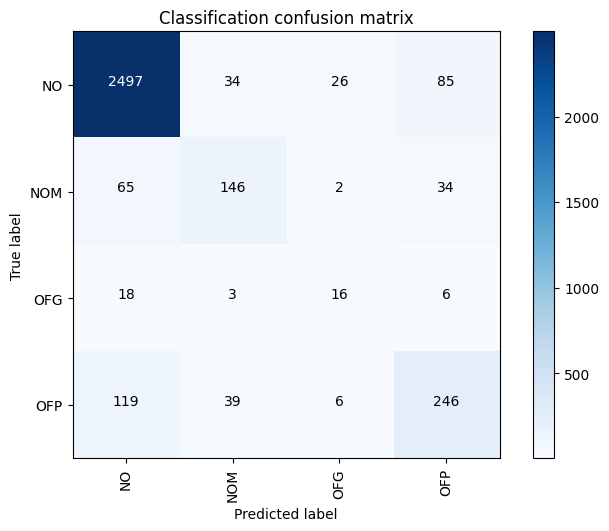


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.6508    0.6049    0.6270       453
     no_hate     0.9387    0.9491    0.9439      2889

    accuracy                         0.9025      3342
   macro avg     0.7948    0.7770    0.7854      3342
weighted avg     0.8997    0.9025    0.9009      3342



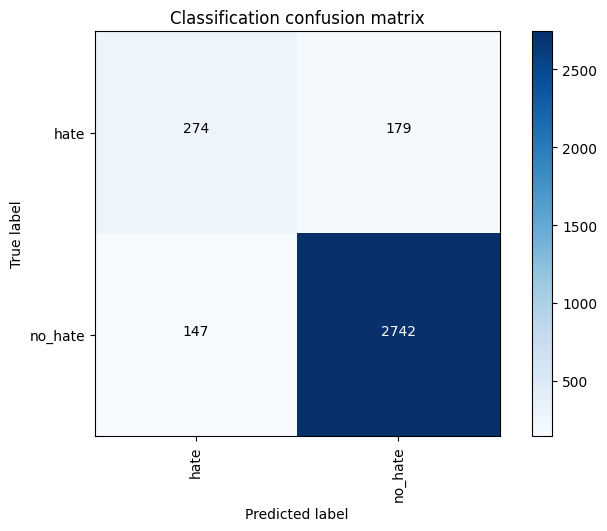

In [ ]:
print("MULTI-CLASS METRICS ===============================")
true_labels: list[str] = [t.label for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

print("\n BINARY-CLASS METRICS ===============================")
true_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in true_labels]
pred_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in pred_labels]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels_binary,
                                              pred_labels=pred_labels_binary)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

En este caso, obtenemos una **performance de 63.29% de macro-f1 (multi-class) y de 78.54% de macro-f1 (binary)**. Los mejores resultados para multi-class hasta el momento.

Veremos si podemos entrenar por más epochs y mejorar el rendimiento.

In [ ]:
# Dataset is not balanced, but we're including it in the LogisticRegression head
dataset_folder: str = dataset_v7_folder
train_set_file_path: str = os.path.join(dataset_folder, "train.csv")
val_set_file_path: str = os.path.join(dataset_folder, "val.csv")
test_set_file_path: str = os.path.join(dataset_folder, "test.csv")

setfit_train_df: pd.DataFrame = pd.read_csv(train_set_file_path, quotechar='"', header=0, sep=",")
setfit_val_df: pd.DataFrame = pd.read_csv(val_set_file_path, quotechar='"', header=0, sep=",")
setfit_test_df: pd.DataFrame = pd.read_csv(test_set_file_path, quotechar='"', header=0, sep=",")

train_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                  _idx, row in setfit_train_df.iterrows()]
val_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                _idx, row in setfit_val_df.iterrows()]
test_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                 _idx, row in setfit_test_df.iterrows()]

config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        metric="accuracy",
        batch_size=16,
        num_iterations=3,
        num_epochs=5,
        add_early_stopping=False,
        early_stopping_patience=0,
        balanced_class_weight=True,
        head_max_iter=3000
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...
Number of samples in training set: 11124
Number of samples in validation set: 3341


Map:   0%|          | 0/11124 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 66744
  Batch size = 16
  Num epochs = 5
  Total optimization steps = 20860


  0%|          | 0/1253 [00:00<?, ?it/s]

  0%|          | 0/1253 [00:00<?, ?it/s]

  0%|          | 0/1253 [00:00<?, ?it/s]

  0%|          | 0/1253 [00:00<?, ?it/s]

  0%|          | 0/1253 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 4172.
***** Running evaluation *****


Finished model training. Took 1:00:21.520617 seconds
Starting evaluation...
Accuracy on validation set: 0.8482
Done!


MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Inference done!.
              precision    recall  f1-score   support

          NO     0.9414    0.9175    0.9293      2642
         NOM     0.5342    0.6640    0.5921       247
         OFG     0.3182    0.3256    0.3218        43
         OFP     0.6226    0.6317    0.6271       410

    accuracy                         0.8561      3342
   macro avg     0.6041    0.6347    0.6176      3342
weighted avg     0.8641    0.8561    0.8595      3342



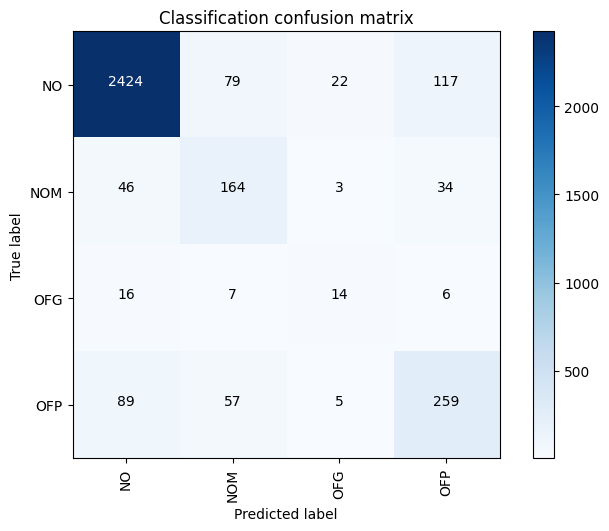


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.6174    0.6269    0.6221       453
     no_hate     0.9414    0.9391    0.9402      2889

    accuracy                         0.8968      3342
   macro avg     0.7794    0.7830    0.7812      3342
weighted avg     0.8974    0.8968    0.8971      3342



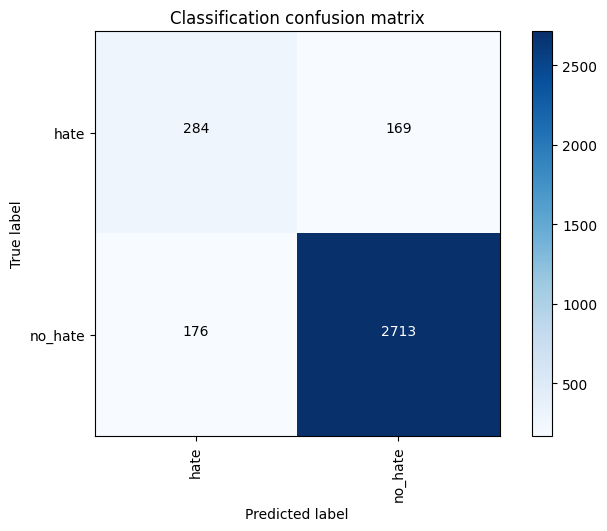

In [ ]:
print("MULTI-CLASS METRICS ===============================")
true_labels: list[str] = [t.label for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

print("\n BINARY-CLASS METRICS ===============================")
true_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in true_labels]
pred_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in pred_labels]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels_binary,
                                              pred_labels=pred_labels_binary)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

En este caso, vemos que obtenemos peores resultados al entrenar por menos epochs que por más, lo cual es curioso. La función de pérdida para los embeddings sube en vez de bajar.

Probaremos a continuación con una única epoch pero diverso número de `num_iterations`, es decir, el parámetro que controla cuántos positive y negative pairs se usan para cada ejemplo.

Num iterations run: 1


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...
Number of samples in training set: 11124
Number of samples in validation set: 3341


Map:   0%|          | 0/11124 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 22248
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 1391


  0%|          | 0/418 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 1391.
***** Running evaluation *****


Finished model training. Took 0:09:51.967936 seconds
Starting evaluation...
Accuracy on validation set: 0.8569
Done!
MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...
Inference done!.
              precision    recall  f1-score   support

          NO     0.9234    0.9497    0.9364      2642
         NOM     0.6432    0.5911    0.6160       247
         OFG     0.2667    0.3721    0.3107        43
         OFP     0.6716    0.5537    0.6070       410

    accuracy                         0.8671      3342
   macro avg     0.6262    0.6166    0.6175      3342
weighted avg     0.8634    0.8671    0.8642      3342



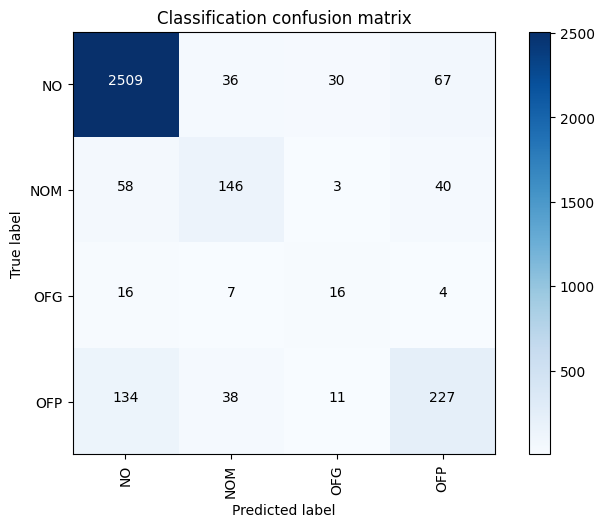


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.6482    0.5695    0.6063       453
     no_hate     0.9338    0.9515    0.9426      2889

    accuracy                         0.8998      3342
   macro avg     0.7910    0.7605    0.7745      3342
weighted avg     0.8951    0.8998    0.8970      3342



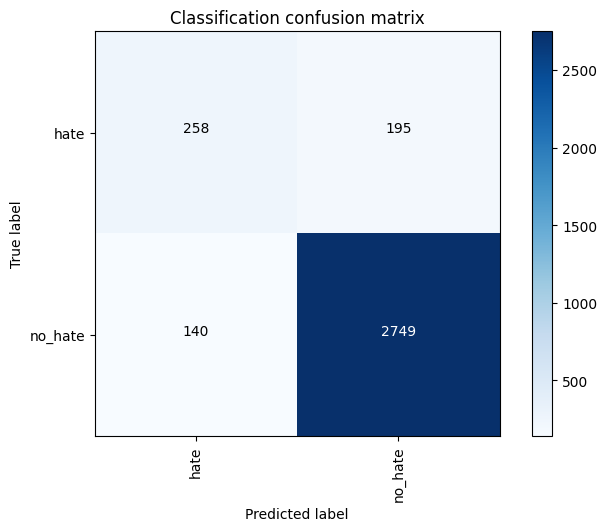





Num iterations run: 3


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...
Number of samples in training set: 11124
Number of samples in validation set: 3341


Map:   0%|          | 0/11124 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 66744
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 4172


  0%|          | 0/1253 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 4172.
***** Running evaluation *****


Finished model training. Took 0:15:31.636463 seconds
Starting evaluation...
Accuracy on validation set: 0.862
Done!
MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...
Inference done!.
              precision    recall  f1-score   support

          NO     0.9279    0.9353    0.9316      2642
         NOM     0.6214    0.6113    0.6163       247
         OFG     0.3556    0.3721    0.3636        43
         OFP     0.6394    0.6098    0.6242       410

    accuracy                         0.8642      3342
   macro avg     0.6361    0.6321    0.6339      3342
weighted avg     0.8625    0.8642    0.8633      3342



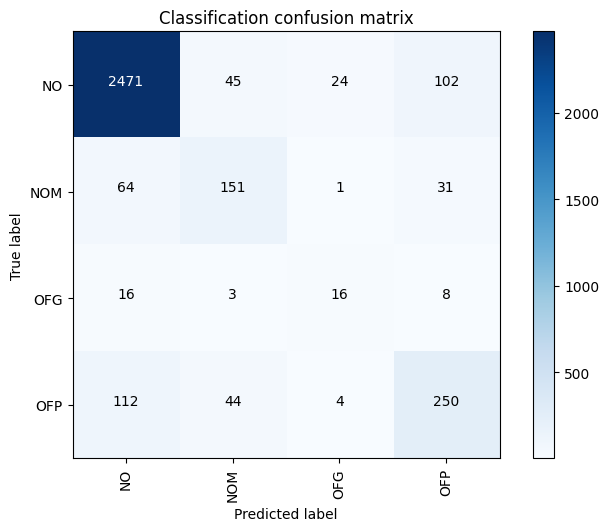


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.6376    0.6137    0.6254       453
     no_hate     0.9398    0.9453    0.9425      2889

    accuracy                         0.9004      3342
   macro avg     0.7887    0.7795    0.7840      3342
weighted avg     0.8988    0.9004    0.8996      3342



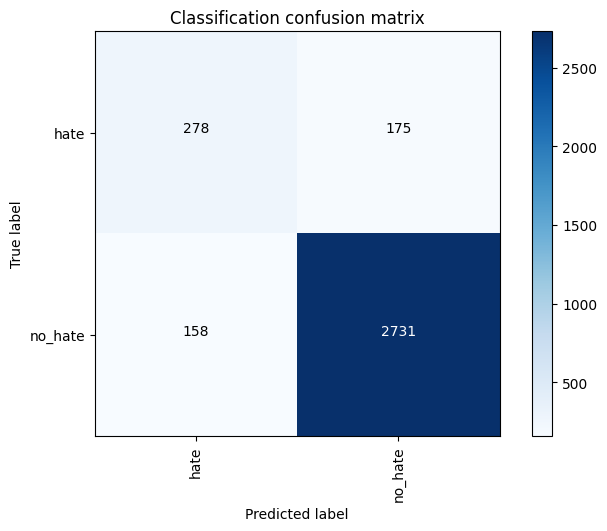





Num iterations run: 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...
Number of samples in training set: 11124
Number of samples in validation set: 3341


Map:   0%|          | 0/11124 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 111240
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 6953


  0%|          | 0/2089 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 6953.
***** Running evaluation *****


Finished model training. Took 0:23:16.410624 seconds
Starting evaluation...
Accuracy on validation set: 0.8593
Done!
MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...
Inference done!.
              precision    recall  f1-score   support

          NO     0.9361    0.9201    0.9280      2642
         NOM     0.5699    0.6437    0.6046       247
         OFG     0.4138    0.2791    0.3333        43
         OFP     0.6064    0.6463    0.6257       410

    accuracy                         0.8579      3342
   macro avg     0.6315    0.6223    0.6229      3342
weighted avg     0.8619    0.8579    0.8594      3342



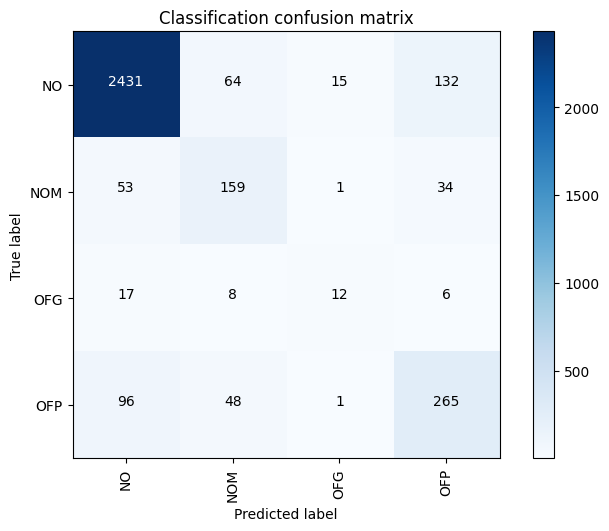


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.6094    0.6269    0.6181       453
     no_hate     0.9412    0.9370    0.9391      2889

    accuracy                         0.8950      3342
   macro avg     0.7753    0.7820    0.7786      3342
weighted avg     0.8963    0.8950    0.8956      3342



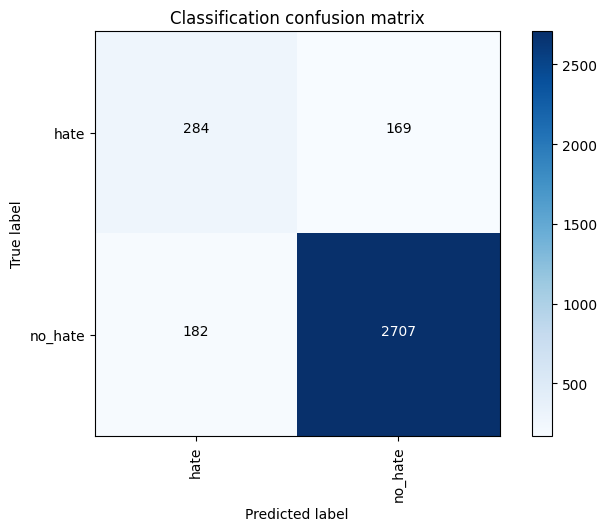

In [ ]:
for num_iterations in [1, 3, 5]:
    print(f"Num iterations run: {num_iterations}")

    dataset_folder: str = dataset_v7_folder
    train_set_file_path: str = os.path.join(dataset_folder, "train.csv")
    val_set_file_path: str = os.path.join(dataset_folder, "val.csv")
    test_set_file_path: str = os.path.join(dataset_folder, "test.csv")

    setfit_train_df: pd.DataFrame = pd.read_csv(train_set_file_path, quotechar='"', header=0, sep=",")
    setfit_val_df: pd.DataFrame = pd.read_csv(val_set_file_path, quotechar='"', header=0, sep=",")
    setfit_test_df: pd.DataFrame = pd.read_csv(test_set_file_path, quotechar='"', header=0, sep=",")

    train_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                      _idx, row in setfit_train_df.iterrows()]
    val_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                    _idx, row in setfit_val_df.iterrows()]
    test_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                     _idx, row in setfit_test_df.iterrows()]

    config = SetfitTrainerConfig(
        train_data=train_data,
        val_data=val_data,
        train_config=SetFitTrainingConfig(
            model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
            metric="accuracy",
            batch_size=16,
            num_iterations=num_iterations,
            num_epochs=1,
            add_early_stopping=False,
            early_stopping_patience=0
        )
    )

    runner = SetFitTrainer(config)
    runner.train()
    runner.eval()
    print("Done!")

    print("MULTI-CLASS METRICS ===============================")
    true_labels: list[str] = [t.label for t in test_data]
    pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
    metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                                  pred_labels=pred_labels)
    print(metrics_calculator.get_classification_report()[0])
    metrics_calculator.plot_confusion_matrix()

    print("\n BINARY-CLASS METRICS ===============================")
    true_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in true_labels]
    pred_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in pred_labels]
    metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels_binary,
                                                  pred_labels=pred_labels_binary)
    print(metrics_calculator.get_classification_report()[0])
    metrics_calculator.plot_confusion_matrix()

    print("\n\n\n")

Vemos que con num_iterations=3, logramos superar ligeramente la **macro-f1 para multi-class, obteniendo 63.39%**.

Repetiremos la misma prueba pero usando `class_weight="balanced"` en la cabeza de `LogisticRegression`.

Num iterations run: 1


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...
Number of samples in training set: 11124
Number of samples in validation set: 3341


Map:   0%|          | 0/11124 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 22248
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 1391


  0%|          | 0/418 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 1391.
***** Running evaluation *****


Finished model training. Took 0:08:43.450507 seconds
Starting evaluation...


Accuracy on validation set: 0.8129
Done!
MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...
Inference done!.
              precision    recall  f1-score   support

          NO     0.9498    0.8815    0.9144      2642
         NOM     0.5043    0.7045    0.5878       247
         OFG     0.2118    0.4186    0.2812        43
         OFP     0.5413    0.6073    0.5724       410

    accuracy                         0.8288      3342
   macro avg     0.5518    0.6530    0.5890      3342
weighted avg     0.8573    0.8288    0.8402      3342



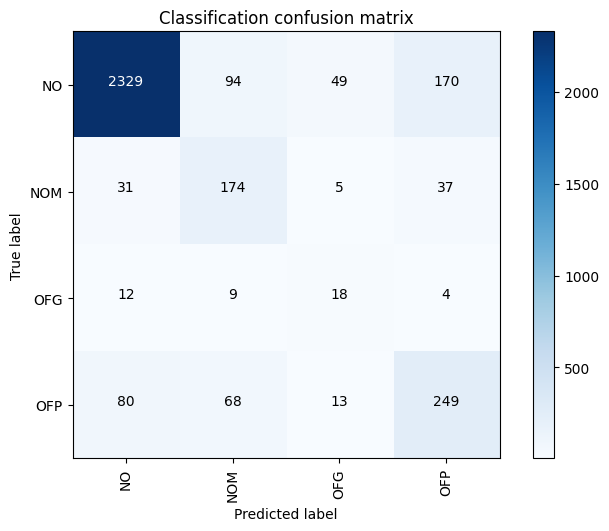


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.5211    0.6269    0.5691       453
     no_hate     0.9396    0.9097    0.9244      2889

    accuracy                         0.8713      3342
   macro avg     0.7303    0.7683    0.7468      3342
weighted avg     0.8829    0.8713    0.8762      3342



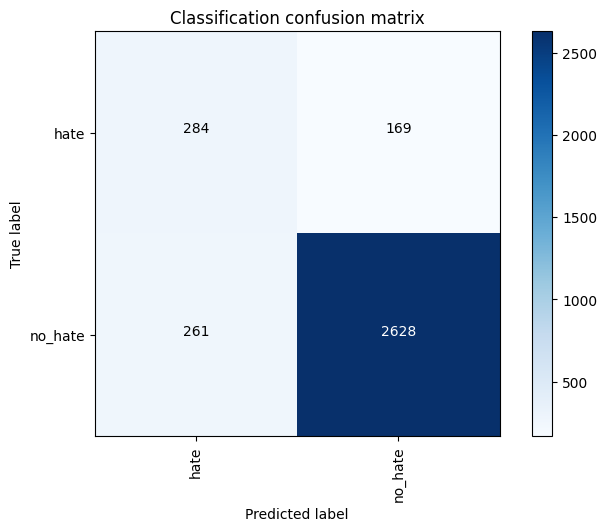





Num iterations run: 2


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...
Number of samples in training set: 11124
Number of samples in validation set: 3341


Map:   0%|          | 0/11124 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 44496
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 2781


  0%|          | 0/836 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 2781.
***** Running evaluation *****


Finished model training. Took 0:13:11.030505 seconds
Starting evaluation...
Accuracy on validation set: 0.8393
Done!
MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...
Inference done!.
              precision    recall  f1-score   support

          NO     0.9432    0.9111    0.9268      2642
         NOM     0.5719    0.6923    0.6264       247
         OFG     0.3148    0.3953    0.3505        43
         OFP     0.5789    0.6171    0.5974       410

    accuracy                         0.8522      3342
   macro avg     0.6022    0.6539    0.6253      3342
weighted avg     0.8630    0.8522    0.8568      3342



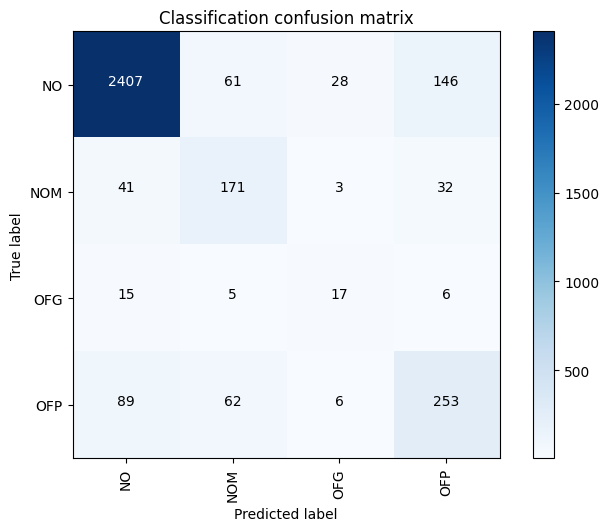


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.5743    0.6225    0.5975       453
     no_hate     0.9400    0.9277    0.9338      2889

    accuracy                         0.8863      3342
   macro avg     0.7572    0.7751    0.7656      3342
weighted avg     0.8905    0.8863    0.8882      3342



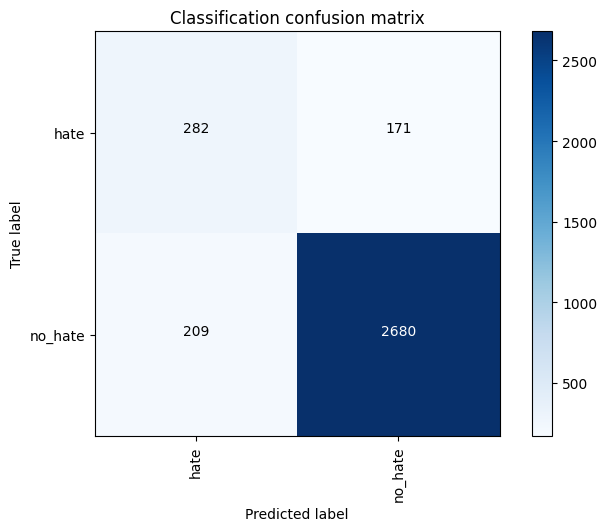





Num iterations run: 3


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...
Number of samples in training set: 11124
Number of samples in validation set: 3341


Map:   0%|          | 0/11124 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 66744
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 4172


  0%|          | 0/1253 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 4172.
***** Running evaluation *****


Finished model training. Took 0:15:33.563976 seconds
Starting evaluation...
Accuracy on validation set: 0.8432
Done!
MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...
Inference done!.
              precision    recall  f1-score   support

          NO     0.9384    0.9111    0.9245      2642
         NOM     0.5253    0.6721    0.5897       247
         OFG     0.3333    0.3488    0.3409        43
         OFP     0.5889    0.5976    0.5932       410

    accuracy                         0.8477      3342
   macro avg     0.5965    0.6324    0.6121      3342
weighted avg     0.8572    0.8477    0.8516      3342



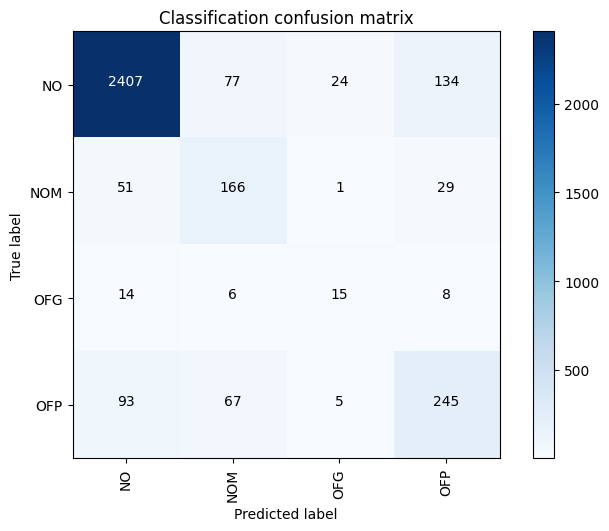


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.5922    0.6026    0.5974       453
     no_hate     0.9375    0.9349    0.9362      2889

    accuracy                         0.8899      3342
   macro avg     0.7649    0.7688    0.7668      3342
weighted avg     0.8907    0.8899    0.8903      3342



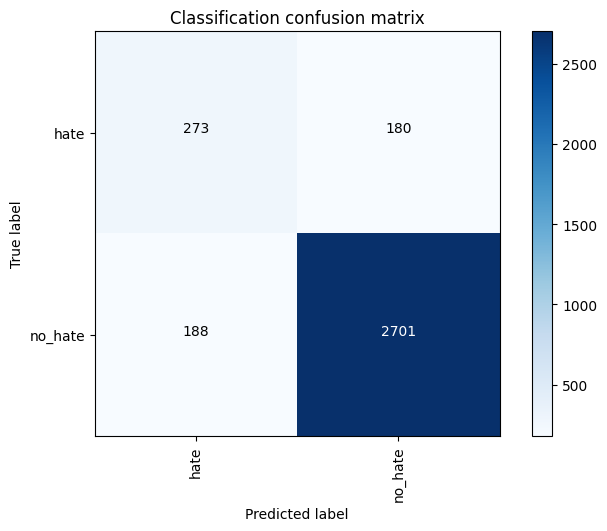





Num iterations run: 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...
Number of samples in training set: 11124
Number of samples in validation set: 3341


Map:   0%|          | 0/11124 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 111240
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 6953


  0%|          | 0/2089 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 6953.
***** Running evaluation *****


Finished model training. Took 0:23:24.962734 seconds
Starting evaluation...
Accuracy on validation set: 0.8411
Done!
MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...
Inference done!.
              precision    recall  f1-score   support

          NO     0.9404    0.9080    0.9239      2642
         NOM     0.5370    0.7045    0.6095       247
         OFG     0.3871    0.2791    0.3243        43
         OFP     0.5917    0.6293    0.6099       410

    accuracy                         0.8507      3342
   macro avg     0.6141    0.6302    0.6169      3342
weighted avg     0.8607    0.8507    0.8545      3342



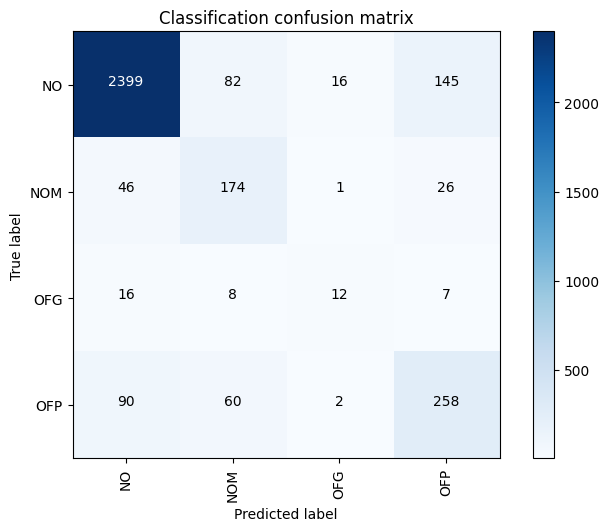


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.5974    0.6159    0.6065       453
     no_hate     0.9395    0.9349    0.9372      2889

    accuracy                         0.8917      3342
   macro avg     0.7685    0.7754    0.7719      3342
weighted avg     0.8931    0.8917    0.8924      3342



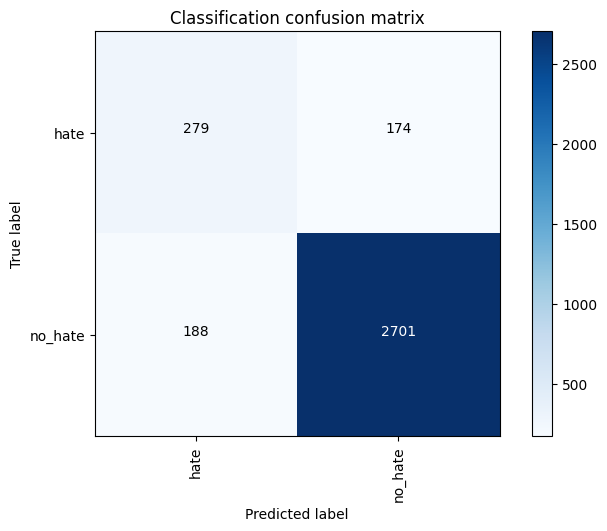

In [ ]:
for num_iterations in [1, 2, 3, 5]:
    print(f"Num iterations run: {num_iterations}")

    dataset_folder: str = dataset_v7_folder
    train_set_file_path: str = os.path.join(dataset_folder, "train.csv")
    val_set_file_path: str = os.path.join(dataset_folder, "val.csv")
    test_set_file_path: str = os.path.join(dataset_folder, "test.csv")

    setfit_train_df: pd.DataFrame = pd.read_csv(train_set_file_path, quotechar='"', header=0, sep=",")
    setfit_val_df: pd.DataFrame = pd.read_csv(val_set_file_path, quotechar='"', header=0, sep=",")
    setfit_test_df: pd.DataFrame = pd.read_csv(test_set_file_path, quotechar='"', header=0, sep=",")

    train_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                      _idx, row in setfit_train_df.iterrows()]
    val_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                    _idx, row in setfit_val_df.iterrows()]
    test_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                     _idx, row in setfit_test_df.iterrows()]

    config = SetfitTrainerConfig(
        train_data=train_data,
        val_data=val_data,
        train_config=SetFitTrainingConfig(
            model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
            metric="accuracy",
            batch_size=16,
            num_iterations=num_iterations,
            num_epochs=1,
            add_early_stopping=False,
            early_stopping_patience=0,
            balanced_class_weight=True,
            head_max_iter=3000
        )
    )

    runner = SetFitTrainer(config)
    runner.train()
    runner.eval()
    print("Done!")

    print("MULTI-CLASS METRICS ===============================")
    true_labels: list[str] = [t.label for t in test_data]
    pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
    metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                                  pred_labels=pred_labels)
    print(metrics_calculator.get_classification_report()[0])
    metrics_calculator.plot_confusion_matrix()

    print("\n BINARY-CLASS METRICS ===============================")
    true_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in true_labels]
    pred_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in pred_labels]
    metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels_binary,
                                                  pred_labels=pred_labels_binary)
    print(metrics_calculator.get_classification_report()[0])
    metrics_calculator.plot_confusion_matrix()

    print("\n\n\n")

Vemos que en este caso el valor óptimo lo obtenemos con num_iterations=2, que es lo que coincide con los resultados anteriores. Utilizar *class_weight="balanced"* no mejora nuestra performance.

#### [sentence-transformers/distiluse-base-multilingual-cased-v1](https://huggingface.co/sentence-transformers/distiluse-base-multilingual-cased-v1)

**Entrenando con v4**

In [ ]:
# Train for a single epoch to make sure it works
# Dataset is not balanced, for this test we don't care (we'll use a technique later)
v4_train_set_file_path: str = os.path.join(dataset_v4_folder, "train.csv")
v4_val_set_file_path: str = os.path.join(dataset_v4_folder, "val.csv")
v4_test_set_file_path: str = os.path.join(dataset_v4_folder, "test.csv")

setfit_train_df: pd.DataFrame = pd.read_csv(v4_train_set_file_path, quotechar='"', header=0, sep=",")
setfit_val_df: pd.DataFrame = pd.read_csv(v4_val_set_file_path, quotechar='"', header=0, sep=",")
setfit_test_df: pd.DataFrame = pd.read_csv(v4_test_set_file_path, quotechar='"', header=0, sep=",")

train_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                  _idx, row in setfit_train_df.iterrows()]
val_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                _idx, row in setfit_val_df.iterrows()]
test_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                 _idx, row in setfit_test_df.iterrows()]

config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/distiluse-base-multilingual-cased-v1",
        metric="accuracy",
        batch_size=16,
        num_iterations=2,
        num_epochs=1,
        add_early_stopping=False,
        early_stopping_patience=0,
        balanced_class_weight=True,
        head_max_iter=3000
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

Sentence transformer: sentence-transformers/distiluse-base-multilingual-cased-v1 loaded!
Loading datasets...
Number of samples in training set: 10025
Number of samples in validation set: 3341


Map:   0%|          | 0/10025 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 40100
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 2507


  0%|          | 0/836 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 2507.
***** Running evaluation *****


Finished model training. Took 0:13:55.383452 seconds
Starting evaluation...
Accuracy on validation set: 0.8656
Done!


MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Inference done!.
              precision    recall  f1-score   support

          NO     0.9317    0.9504    0.9410      2642
         NOM     0.6015    0.6478    0.6238       247
         OFG     0.3750    0.0698    0.1176        43
         OFP     0.6649    0.6049    0.6335       410

    accuracy                         0.8743      3342
   macro avg     0.6433    0.5682    0.5790      3342
weighted avg     0.8674    0.8743    0.8692      3342



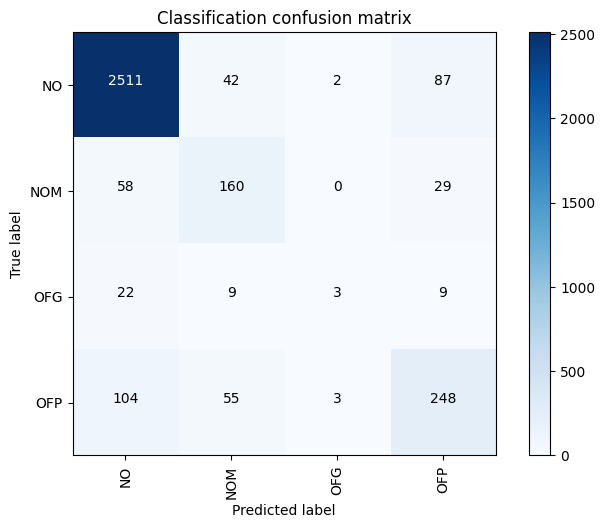


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.6903    0.5806    0.6307       453
     no_hate     0.9358    0.9592    0.9474      2889

    accuracy                         0.9078      3342
   macro avg     0.8131    0.7699    0.7890      3342
weighted avg     0.9025    0.9078    0.9044      3342



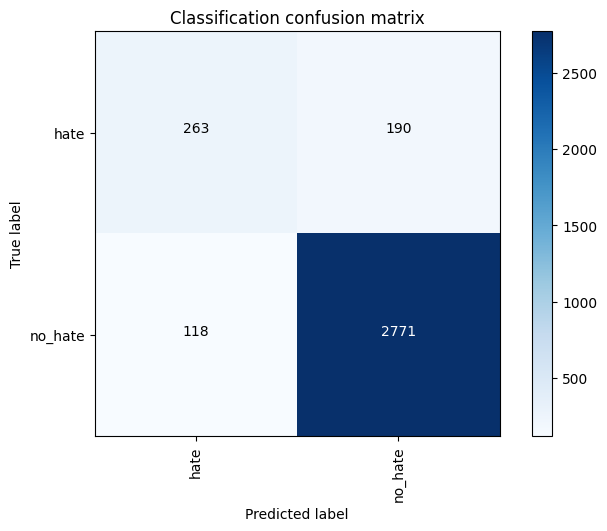

In [ ]:
print("MULTI-CLASS METRICS ===============================")
true_labels: list[str] = [t.label for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

print("\n BINARY-CLASS METRICS ===============================")
true_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in true_labels]
pred_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in pred_labels]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels_binary,
                                              pred_labels=pred_labels_binary)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

En este caso, **obtenemos una performance de 57.9% de macro-f1 (multi-class) y 78.9% de macro-f1 (binary)**.

Algo que quería probar y que no hicimos antes, es incrementar el parámetro de `num_iterations` de forma de ver si eso nos ayuda o no.

In [ ]:
# Train for a single epoch to make sure it works
# Dataset is not balanced, for this test we don't care (we'll use a technique later)
v4_train_set_file_path: str = os.path.join(dataset_v4_folder, "train.csv")
v4_val_set_file_path: str = os.path.join(dataset_v4_folder, "val.csv")
v4_test_set_file_path: str = os.path.join(dataset_v4_folder, "test.csv")

setfit_train_df: pd.DataFrame = pd.read_csv(v4_train_set_file_path, quotechar='"', header=0, sep=",")
setfit_val_df: pd.DataFrame = pd.read_csv(v4_val_set_file_path, quotechar='"', header=0, sep=",")
setfit_test_df: pd.DataFrame = pd.read_csv(v4_test_set_file_path, quotechar='"', header=0, sep=",")

train_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                  _idx, row in setfit_train_df.iterrows()]
val_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                _idx, row in setfit_val_df.iterrows()]
test_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                 _idx, row in setfit_test_df.iterrows()]

config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/distiluse-base-multilingual-cased-v1",
        metric="accuracy",
        batch_size=16,
        num_iterations=5,
        num_epochs=1,
        add_early_stopping=False,
        early_stopping_patience=0,
        balanced_class_weight=True,
        head_max_iter=3000
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: sentence-transformers/distiluse-base-multilingual-cased-v1 loaded!
Loading datasets...
Number of samples in training set: 10025
Number of samples in validation set: 3341


Map:   0%|          | 0/10025 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 100250
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 6266


  0%|          | 0/2089 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 6266.
***** Running evaluation *****


Finished model training. Took 0:26:08.581527 seconds
Starting evaluation...
Accuracy on validation set: 0.8156
Done!


MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Inference done!.
              precision    recall  f1-score   support

          NO     0.9472    0.8834    0.9142      2642
         NOM     0.4293    0.7004    0.5323       247
         OFG     0.1176    0.4186    0.1837        43
         OFP     0.6894    0.5415    0.6066       410

    accuracy                         0.8220      3342
   macro avg     0.5459    0.6360    0.5592      3342
weighted avg     0.8667    0.8220    0.8388      3342



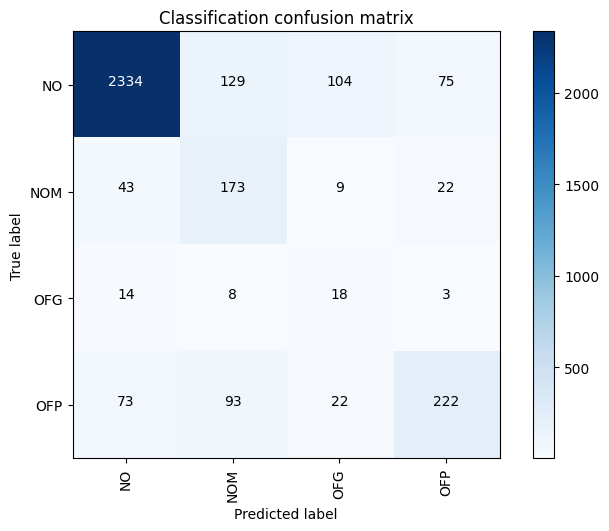


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.5579    0.5850    0.5711       453
     no_hate     0.9344    0.9273    0.9309      2889

    accuracy                         0.8809      3342
   macro avg     0.7462    0.7561    0.7510      3342
weighted avg     0.8834    0.8809    0.8821      3342



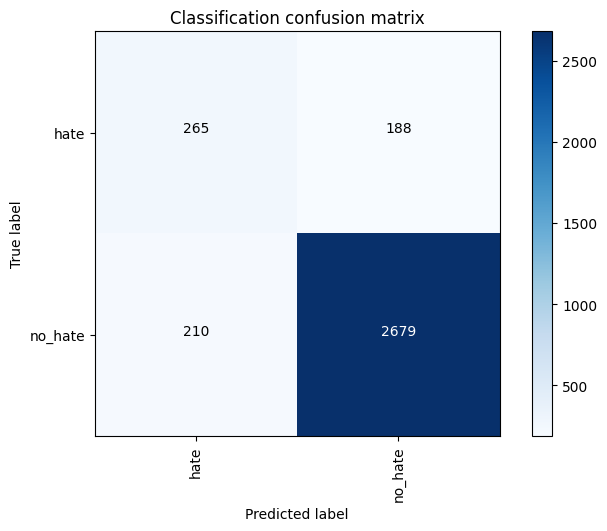

In [ ]:
print("MULTI-CLASS METRICS ===============================")
true_labels: list[str] = [t.label for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

print("\n BINARY-CLASS METRICS ===============================")
true_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in true_labels]
pred_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in pred_labels]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels_binary,
                                              pred_labels=pred_labels_binary)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

En este caso, los resultados son ligeramente peores al incluir más `num_iterations`. Veamos qué sucede si solo incluirmos 1.

In [ ]:
# Train for a single epoch to make sure it works
# Dataset is not balanced, for this test we don't care (we'll use a technique later)
v4_train_set_file_path: str = os.path.join(dataset_v4_folder, "train.csv")
v4_val_set_file_path: str = os.path.join(dataset_v4_folder, "val.csv")
v4_test_set_file_path: str = os.path.join(dataset_v4_folder, "test.csv")

setfit_train_df: pd.DataFrame = pd.read_csv(v4_train_set_file_path, quotechar='"', header=0, sep=",")
setfit_val_df: pd.DataFrame = pd.read_csv(v4_val_set_file_path, quotechar='"', header=0, sep=",")
setfit_test_df: pd.DataFrame = pd.read_csv(v4_test_set_file_path, quotechar='"', header=0, sep=",")

train_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                  _idx, row in setfit_train_df.iterrows()]
val_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                _idx, row in setfit_val_df.iterrows()]
test_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                 _idx, row in setfit_test_df.iterrows()]

config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/distiluse-base-multilingual-cased-v1",
        metric="accuracy",
        batch_size=16,
        num_iterations=1,
        num_epochs=1,
        add_early_stopping=False,
        early_stopping_patience=0,
        balanced_class_weight=True,
        head_max_iter=3000
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: sentence-transformers/distiluse-base-multilingual-cased-v1 loaded!
Loading datasets...
Number of samples in training set: 10025
Number of samples in validation set: 3341


Map:   0%|          | 0/10025 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 20050
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 1254


  0%|          | 0/418 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 1254.
***** Running evaluation *****


Finished model training. Took 0:10:21.796173 seconds
Starting evaluation...
Accuracy on validation set: 0.8321
Done!


MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Inference done!.
              precision    recall  f1-score   support

          NO     0.9551    0.8857    0.9191      2642
         NOM     0.5437    0.7814    0.6412       247
         OFG     0.1753    0.3953    0.2429        43
         OFP     0.5727    0.6146    0.5929       410

    accuracy                         0.8384      3342
   macro avg     0.5617    0.6693    0.5990      3342
weighted avg     0.8677    0.8384    0.8498      3342



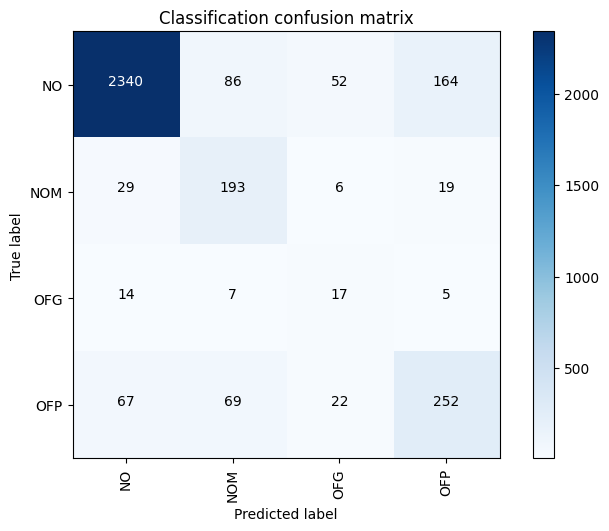


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.5512    0.6534    0.5980       453
     no_hate     0.9440    0.9166    0.9301      2889

    accuracy                         0.8809      3342
   macro avg     0.7476    0.7850    0.7640      3342
weighted avg     0.8908    0.8809    0.8851      3342



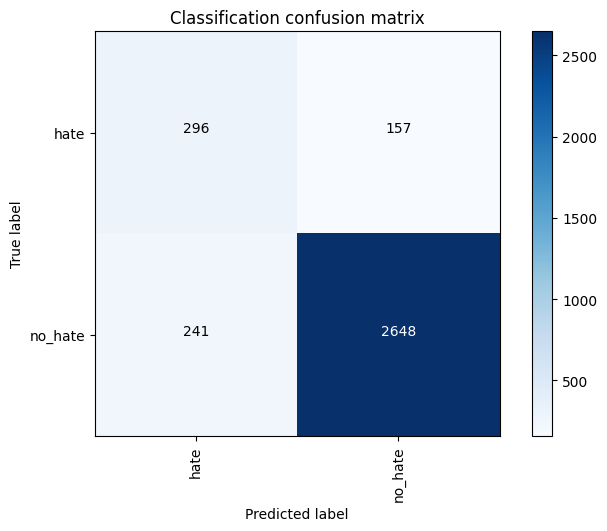

In [ ]:
print("MULTI-CLASS METRICS ===============================")
true_labels: list[str] = [t.label for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

print("\n BINARY-CLASS METRICS ===============================")
true_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in true_labels]
pred_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in pred_labels]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels_binary,
                                              pred_labels=pred_labels_binary)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

Increiblemente la perfromance es mejor cuando `num_iterations=1`. **Obtenemos una performance de 59.9% de macro-f1 (multi-class) y 76.4% de macro-f1 (binary).**

Repetiremos el mismo training, pero ahora sin el balancing, porque parece darnos mejores resultados sin esa estrategia.

In [ ]:
# Train for a single epoch to make sure it works
# Dataset is not balanced, for this test we don't care (we'll use a technique later)
v4_train_set_file_path: str = os.path.join(dataset_v4_folder, "train.csv")
v4_val_set_file_path: str = os.path.join(dataset_v4_folder, "val.csv")
v4_test_set_file_path: str = os.path.join(dataset_v4_folder, "test.csv")

setfit_train_df: pd.DataFrame = pd.read_csv(v4_train_set_file_path, quotechar='"', header=0, sep=",")
setfit_val_df: pd.DataFrame = pd.read_csv(v4_val_set_file_path, quotechar='"', header=0, sep=",")
setfit_test_df: pd.DataFrame = pd.read_csv(v4_test_set_file_path, quotechar='"', header=0, sep=",")

train_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                  _idx, row in setfit_train_df.iterrows()]
val_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                _idx, row in setfit_val_df.iterrows()]
test_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                 _idx, row in setfit_test_df.iterrows()]

config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/distiluse-base-multilingual-cased-v1",
        metric="accuracy",
        batch_size=16,
        num_iterations=1,
        num_epochs=1,
        add_early_stopping=False,
        early_stopping_patience=0,
        balanced_class_weight=False,
        head_max_iter=3000
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: sentence-transformers/distiluse-base-multilingual-cased-v1 loaded!
Loading datasets...
Number of samples in training set: 10025
Number of samples in validation set: 3341


Map:   0%|          | 0/10025 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 20050
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 1254


  0%|          | 0/418 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 1254.
***** Running evaluation *****


Finished model training. Took 0:10:01.372392 seconds
Starting evaluation...
Accuracy on validation set: 0.8737
Done!


MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Inference done!.
              precision    recall  f1-score   support

          NO     0.9284    0.9576    0.9428      2642
         NOM     0.6381    0.6640    0.6508       247
         OFG     0.6667    0.0465    0.0870        43
         OFP     0.6919    0.6024    0.6441       410

    accuracy                         0.8806      3342
   macro avg     0.7313    0.5676    0.5812      3342
weighted avg     0.8746    0.8806    0.8736      3342



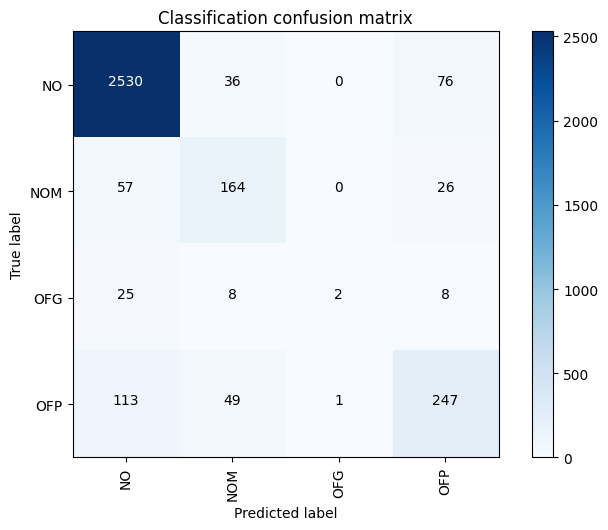


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.7167    0.5695    0.6347       453
     no_hate     0.9346    0.9647    0.9494      2889

    accuracy                         0.9111      3342
   macro avg     0.8256    0.7671    0.7920      3342
weighted avg     0.9051    0.9111    0.9068      3342



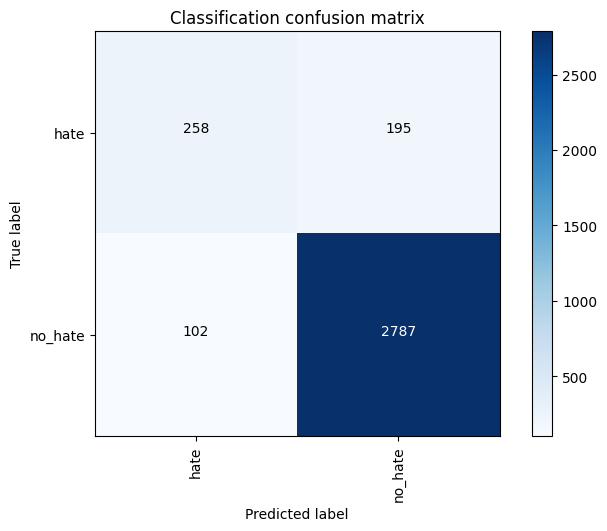

In [ ]:
print("MULTI-CLASS METRICS ===============================")
true_labels: list[str] = [t.label for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

print("\n BINARY-CLASS METRICS ===============================")
true_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in true_labels]
pred_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in pred_labels]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels_binary,
                                              pred_labels=pred_labels_binary)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Num iterations run: 2


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: sentence-transformers/distiluse-base-multilingual-cased-v1 loaded!
Loading datasets...
Number of samples in training set: 10025
Number of samples in validation set: 3341


Map:   0%|          | 0/10025 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 40100
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 2507


  0%|          | 0/836 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 2507.
***** Running evaluation *****


Finished model training. Took 0:13:33.771425 seconds
Starting evaluation...
Accuracy on validation set: 0.8656
Done!
MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...
Inference done!.
              precision    recall  f1-score   support

          NO     0.9317    0.9504    0.9410      2642
         NOM     0.6015    0.6478    0.6238       247
         OFG     0.3750    0.0698    0.1176        43
         OFP     0.6649    0.6049    0.6335       410

    accuracy                         0.8743      3342
   macro avg     0.6433    0.5682    0.5790      3342
weighted avg     0.8674    0.8743    0.8692      3342



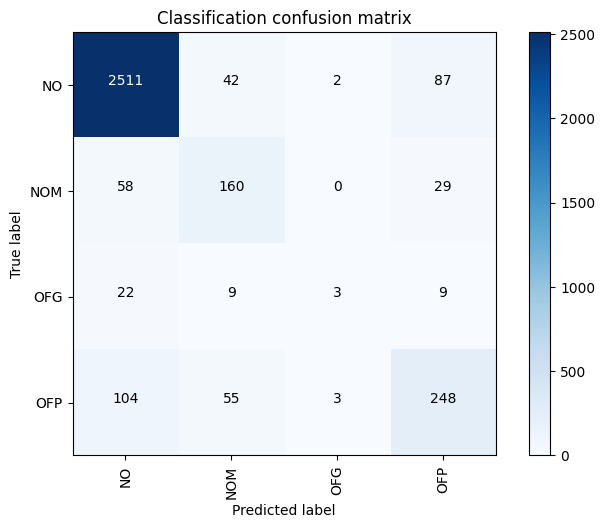


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.6903    0.5806    0.6307       453
     no_hate     0.9358    0.9592    0.9474      2889

    accuracy                         0.9078      3342
   macro avg     0.8131    0.7699    0.7890      3342
weighted avg     0.9025    0.9078    0.9044      3342



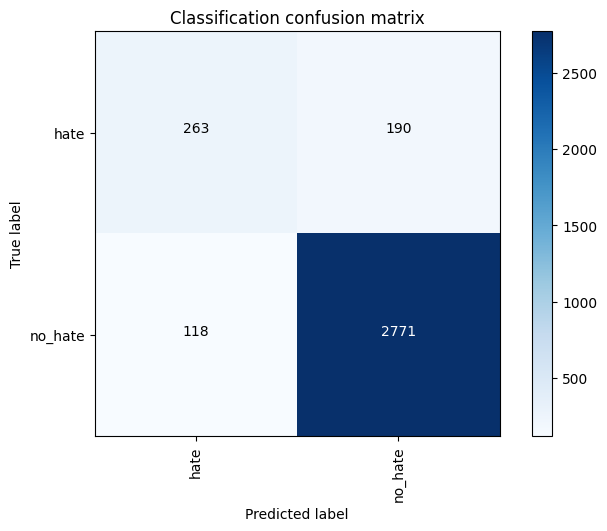





Num iterations run: 3


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: sentence-transformers/distiluse-base-multilingual-cased-v1 loaded!
Loading datasets...
Number of samples in training set: 10025
Number of samples in validation set: 3341


Map:   0%|          | 0/10025 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 60150
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 3760


  0%|          | 0/1253 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 3760.
***** Running evaluation *****


Finished model training. Took 0:18:29.430857 seconds
Starting evaluation...
Accuracy on validation set: 0.8545
Done!
MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...
Inference done!.
              precision    recall  f1-score   support

          NO     0.9335    0.9353    0.9344      2642
         NOM     0.5418    0.6559    0.5934       247
         OFG     0.3333    0.1860    0.2388        43
         OFP     0.6478    0.5878    0.6164       410

    accuracy                         0.8624      3342
   macro avg     0.6141    0.5912    0.5957      3342
weighted avg     0.8618    0.8624    0.8612      3342



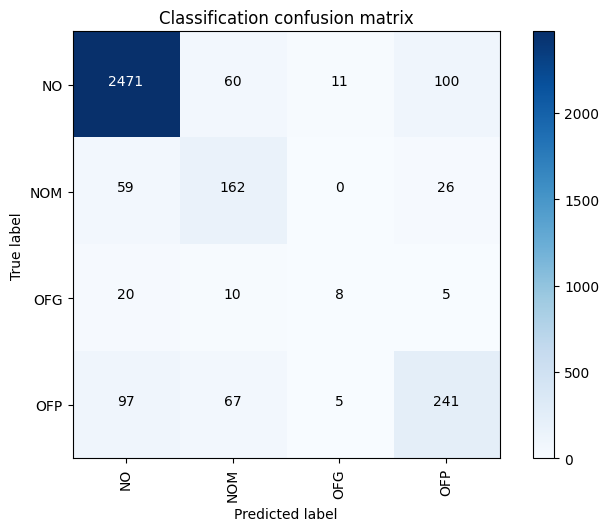


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.6540    0.5717    0.6101       453
     no_hate     0.9341    0.9526    0.9433      2889

    accuracy                         0.9010      3342
   macro avg     0.7941    0.7622    0.7767      3342
weighted avg     0.8962    0.9010    0.8981      3342



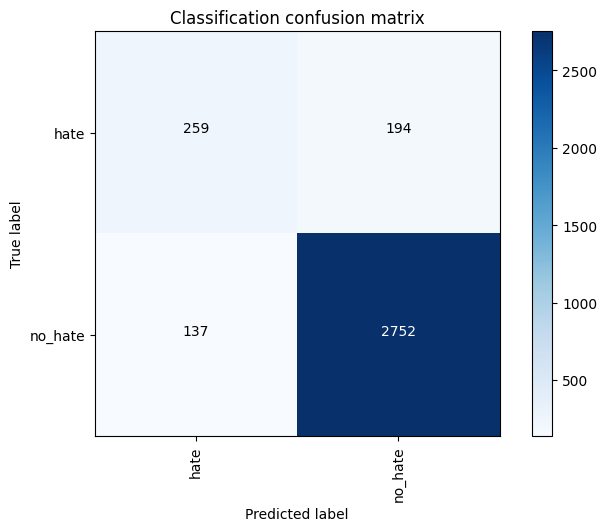





Num iterations run: 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: sentence-transformers/distiluse-base-multilingual-cased-v1 loaded!
Loading datasets...
Number of samples in training set: 10025
Number of samples in validation set: 3341


Map:   0%|          | 0/10025 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 100250
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 6266


  0%|          | 0/2089 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 6266.
***** Running evaluation *****


Finished model training. Took 0:26:18.193437 seconds
Starting evaluation...
Accuracy on validation set: 0.8494
Done!
MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...
Inference done!.
              precision    recall  f1-score   support

          NO     0.9370    0.9182    0.9275      2642
         NOM     0.5140    0.6680    0.5810       247
         OFG     0.2973    0.2558    0.2750        43
         OFP     0.6380    0.6146    0.6261       410

    accuracy                         0.8540      3342
   macro avg     0.5966    0.6142    0.6024      3342
weighted avg     0.8609    0.8540    0.8566      3342



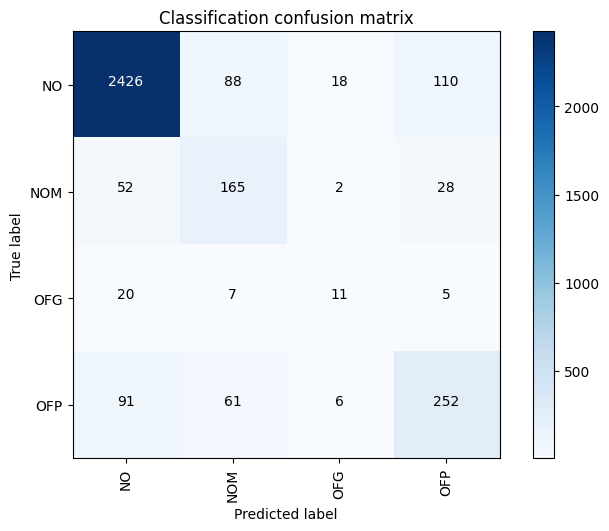


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.6343    0.6049    0.6192       453
     no_hate     0.9385    0.9453    0.9419      2889

    accuracy                         0.8992      3342
   macro avg     0.7864    0.7751    0.7805      3342
weighted avg     0.8973    0.8992    0.8981      3342



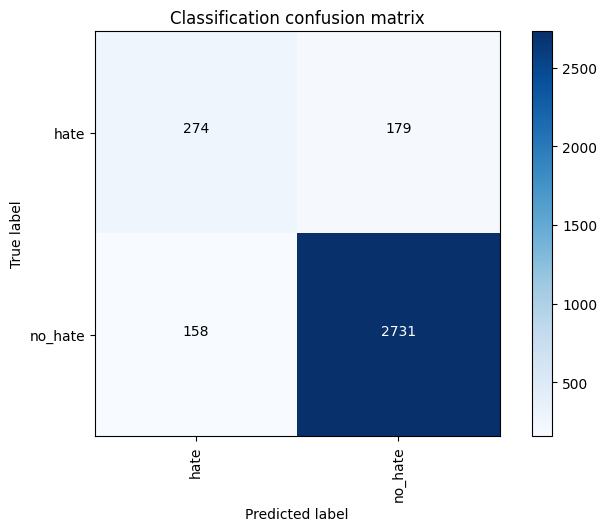

In [ ]:
for num_iterations in [2, 3, 5]:
    print(f"Num iterations run: {num_iterations}")
    # Train for a single epoch to make sure it works
    # Dataset is not balanced, for this test we don't care (we'll use a technique later)
    v4_train_set_file_path: str = os.path.join(dataset_v4_folder, "train.csv")
    v4_val_set_file_path: str = os.path.join(dataset_v4_folder, "val.csv")
    v4_test_set_file_path: str = os.path.join(dataset_v4_folder, "test.csv")

    setfit_train_df: pd.DataFrame = pd.read_csv(v4_train_set_file_path, quotechar='"', header=0, sep=",")
    setfit_val_df: pd.DataFrame = pd.read_csv(v4_val_set_file_path, quotechar='"', header=0, sep=",")
    setfit_test_df: pd.DataFrame = pd.read_csv(v4_test_set_file_path, quotechar='"', header=0, sep=",")

    train_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                      _idx, row in setfit_train_df.iterrows()]
    val_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                    _idx, row in setfit_val_df.iterrows()]
    test_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                     _idx, row in setfit_test_df.iterrows()]

    config = SetfitTrainerConfig(
        train_data=train_data,
        val_data=val_data,
        train_config=SetFitTrainingConfig(
            model="sentence-transformers/distiluse-base-multilingual-cased-v1",
            metric="accuracy",
            batch_size=16,
            num_iterations=num_iterations,
            num_epochs=1,
            add_early_stopping=False,
            early_stopping_patience=0,
            balanced_class_weight=False,
            head_max_iter=3000
        )
    )
    runner = SetFitTrainer(config)
    runner.train()
    runner.eval()
    print("Done!")

    print("MULTI-CLASS METRICS ===============================")
    true_labels: list[str] = [t.label for t in test_data]
    pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
    metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                                  pred_labels=pred_labels)
    print(metrics_calculator.get_classification_report()[0])
    metrics_calculator.plot_confusion_matrix()

    print("\n BINARY-CLASS METRICS ===============================")
    true_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in true_labels]
    pred_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in pred_labels]
    metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels_binary,
                                                  pred_labels=pred_labels_binary)
    print(metrics_calculator.get_classification_report()[0])
    metrics_calculator.plot_confusion_matrix()

    print("\n\n\n")

En este caso, logramos superar la performance anterior pero por muy poco. **Obtenemos un 60.24% de macro-f1 (multi-class) y 78.05% de macro-f1 (binary)** usando `num_iterations=5`.

De momento, el mejor resultado lo seguimos obteniendo con el modelo anterior, es decir: `sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2`. Por otro lado, no logramos ganar performance al usar `class_weight="balanced"` en la cabeza de clasificación.

Dejaremos un training en ejecución para ver si nos pasa lo mismo que con el otro modelo, la incapacidad de poder entrenarlo más de una epoch.

In [ ]:
v4_train_set_file_path: str = os.path.join(dataset_v4_folder, "train.csv")
v4_val_set_file_path: str = os.path.join(dataset_v4_folder, "val.csv")
v4_test_set_file_path: str = os.path.join(dataset_v4_folder, "test.csv")

setfit_train_df: pd.DataFrame = pd.read_csv(v4_train_set_file_path, quotechar='"', header=0, sep=",")
setfit_val_df: pd.DataFrame = pd.read_csv(v4_val_set_file_path, quotechar='"', header=0, sep=",")
setfit_test_df: pd.DataFrame = pd.read_csv(v4_test_set_file_path, quotechar='"', header=0, sep=",")

train_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                  _idx, row in setfit_train_df.iterrows()]
val_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                _idx, row in setfit_val_df.iterrows()]
test_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                 _idx, row in setfit_test_df.iterrows()]

config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/distiluse-base-multilingual-cased-v1",
        metric="accuracy",
        batch_size=16,
        num_iterations=5,
        num_epochs=7,
        add_early_stopping=True,
        early_stopping_patience=1,
        balanced_class_weight=False,
        head_max_iter=3000
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: sentence-transformers/distiluse-base-multilingual-cased-v1 loaded!
Loading datasets...
Number of samples in training set: 10025
Number of samples in validation set: 3341


Map:   0%|          | 0/10025 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 100250
  Batch size = 16
  Num epochs = 7
  Total optimization steps = 43862


  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 6266.
***** Running evaluation *****


Finished model training. Took 0:46:58.107484 seconds
Starting evaluation...
Accuracy on validation set: 0.8611
Done!


MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...
Inference done!.
              precision    recall  f1-score   support

          NO     0.9221    0.9410    0.9314      2642
         NOM     0.5505    0.6397    0.5918       247
         OFG     0.3889    0.1628    0.2295        43
         OFP     0.6510    0.5415    0.5912       410

    accuracy                         0.8597      3342
   macro avg     0.6281    0.5712    0.5860      3342
weighted avg     0.8545    0.8597    0.8556      3342



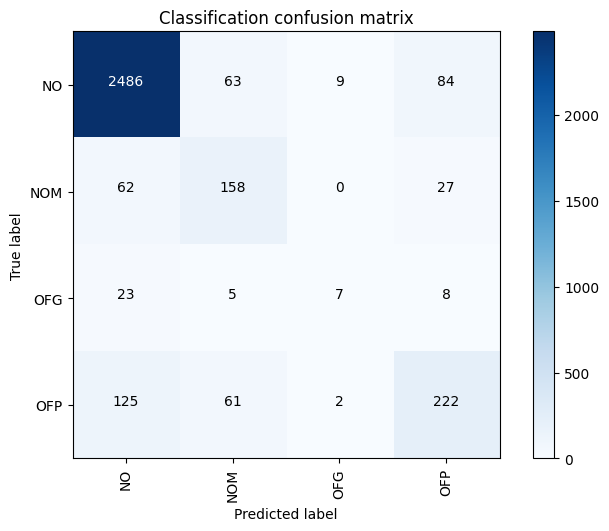


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.6657    0.5276    0.5887       453
     no_hate     0.9283    0.9585    0.9431      2889

    accuracy                         0.9001      3342
   macro avg     0.7970    0.7430    0.7659      3342
weighted avg     0.8927    0.9001    0.8951      3342



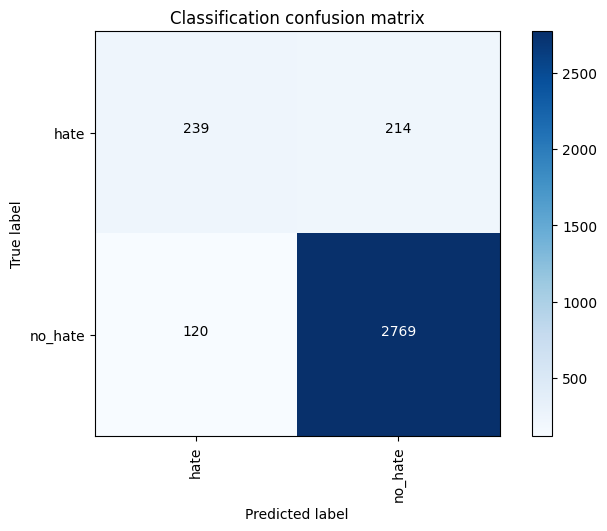

In [ ]:
print("MULTI-CLASS METRICS ===============================")
true_labels: list[str] = [t.label for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

print("\n BINARY-CLASS METRICS ===============================")
true_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in true_labels]
pred_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in pred_labels]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels_binary,
                                              pred_labels=pred_labels_binary)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

**Entrenando con v7**

Repetiremos algunas pruebas pero sobre `v7`, como para ver si el esfuerzo puesto en aumentar los datos mejora los resultados o no.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Num iterations run: 1


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

Sentence transformer: sentence-transformers/distiluse-base-multilingual-cased-v1 loaded!
Loading datasets...
Number of samples in training set: 11124
Number of samples in validation set: 3341


Map:   0%|          | 0/11124 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 22248
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 1391


  0%|          | 0/418 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 1391.
***** Running evaluation *****


Finished model training. Took 0:10:53.407091 seconds
Starting evaluation...
Accuracy on validation set: 0.8596
Done!
MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...
Inference done!.
              precision    recall  f1-score   support

          NO     0.9281    0.9485    0.9382      2642
         NOM     0.6639    0.6397    0.6515       247
         OFG     0.2143    0.2791    0.2424        43
         OFP     0.6925    0.5878    0.6359       410

    accuracy                         0.8728      3342
   macro avg     0.6247    0.6138    0.6170      3342
weighted avg     0.8705    0.8728    0.8710      3342



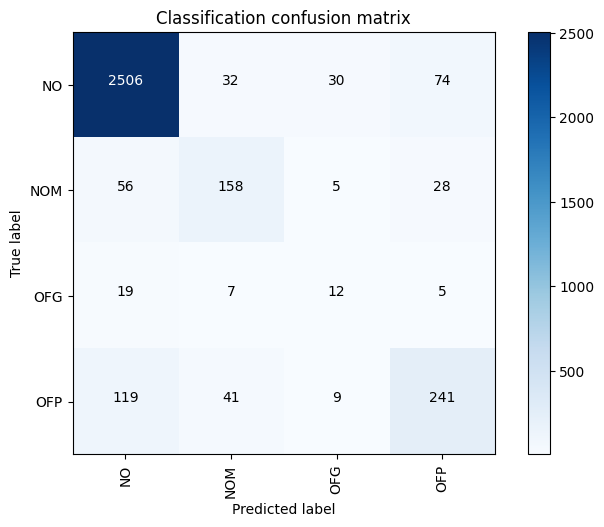


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.6609    0.5894    0.6231       453
     no_hate     0.9367    0.9526    0.9446      2889

    accuracy                         0.9034      3342
   macro avg     0.7988    0.7710    0.7838      3342
weighted avg     0.8993    0.9034    0.9010      3342



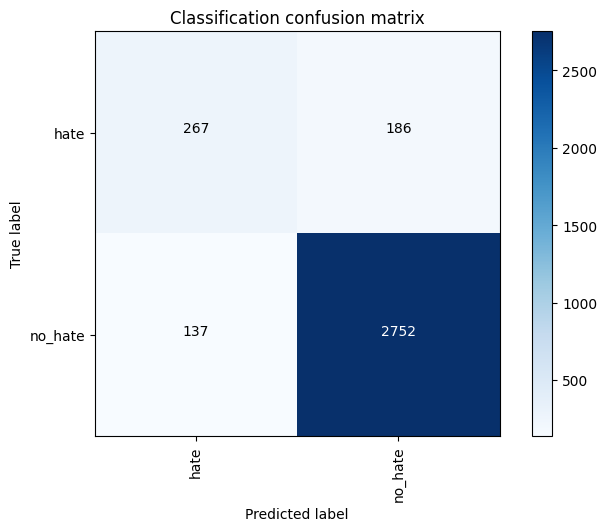





Num iterations run: 2


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: sentence-transformers/distiluse-base-multilingual-cased-v1 loaded!
Loading datasets...
Number of samples in training set: 11124
Number of samples in validation set: 3341


Map:   0%|          | 0/11124 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 44496
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 2781


  0%|          | 0/836 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 2781.
***** Running evaluation *****


Finished model training. Took 0:14:51.799240 seconds
Starting evaluation...
Accuracy on validation set: 0.8575
Done!
MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...
Inference done!.
              precision    recall  f1-score   support

          NO     0.9340    0.9425    0.9382      2642
         NOM     0.6488    0.6356    0.6421       247
         OFG     0.2500    0.2326    0.2410        43
         OFP     0.6675    0.6415    0.6542       410

    accuracy                         0.8737      3342
   macro avg     0.6251    0.6130    0.6189      3342
weighted avg     0.8714    0.8737    0.8725      3342



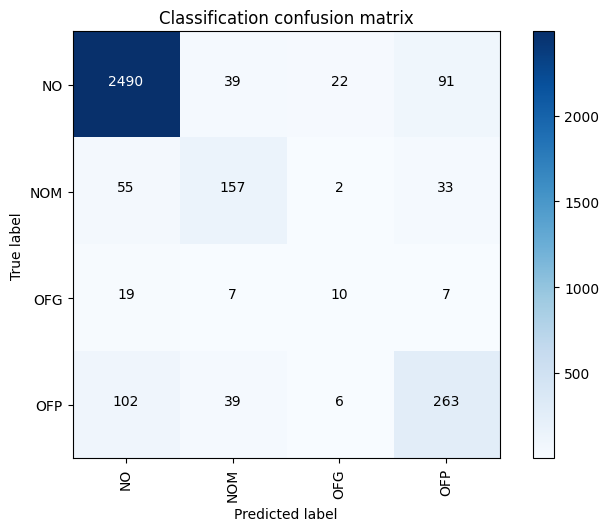


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.6590    0.6313    0.6449       453
     no_hate     0.9426    0.9488    0.9457      2889

    accuracy                         0.9057      3342
   macro avg     0.8008    0.7901    0.7953      3342
weighted avg     0.9041    0.9057    0.9049      3342



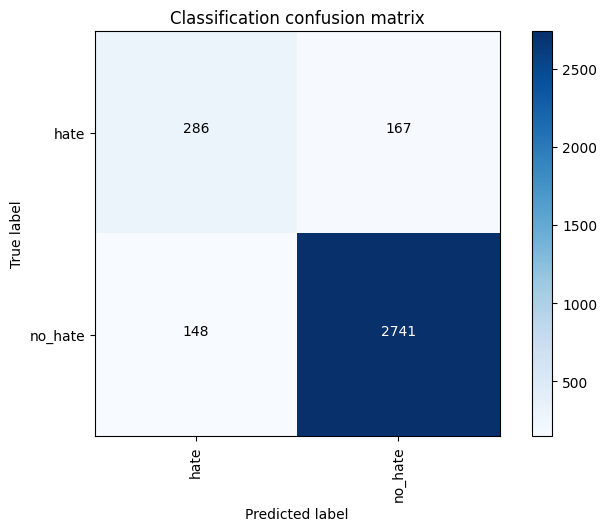





Num iterations run: 3


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: sentence-transformers/distiluse-base-multilingual-cased-v1 loaded!
Loading datasets...
Number of samples in training set: 11124
Number of samples in validation set: 3341


Map:   0%|          | 0/11124 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 66744
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 4172


  0%|          | 0/1253 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 4172.
***** Running evaluation *****


Finished model training. Took 0:20:30.451945 seconds
Starting evaluation...
Accuracy on validation set: 0.8497
Done!
MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...
Inference done!.
              precision    recall  f1-score   support

          NO     0.9376    0.9266    0.9320      2642
         NOM     0.5780    0.6599    0.6163       247
         OFG     0.2381    0.2326    0.2353        43
         OFP     0.6314    0.6268    0.6291       410

    accuracy                         0.8612      3342
   macro avg     0.5963    0.6115    0.6032      3342
weighted avg     0.8644    0.8612    0.8626      3342



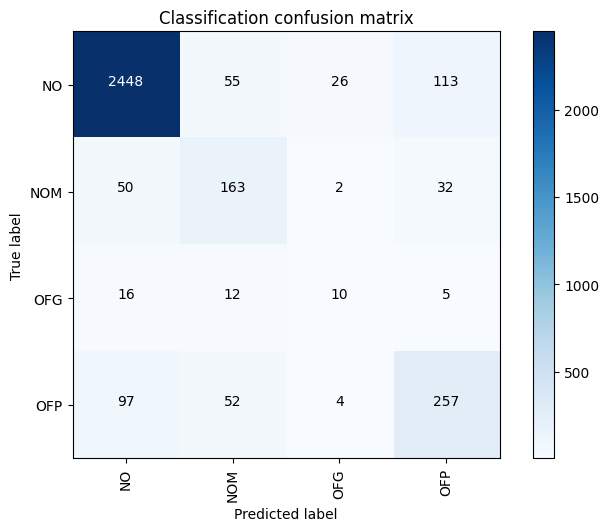


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.6147    0.6093    0.6120       453
     no_hate     0.9388    0.9401    0.9395      2889

    accuracy                         0.8953      3342
   macro avg     0.7768    0.7747    0.7757      3342
weighted avg     0.8949    0.8953    0.8951      3342



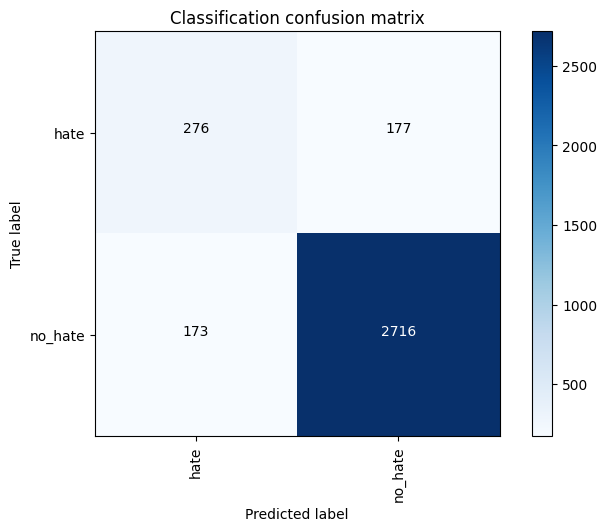





Num iterations run: 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: sentence-transformers/distiluse-base-multilingual-cased-v1 loaded!
Loading datasets...
Number of samples in training set: 11124
Number of samples in validation set: 3341


Map:   0%|          | 0/11124 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 111240
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 6953


  0%|          | 0/2089 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 6953.
***** Running evaluation *****


Finished model training. Took 0:29:02.766438 seconds
Starting evaluation...
Accuracy on validation set: 0.8417
Done!
MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...
Inference done!.
              precision    recall  f1-score   support

          NO     0.9334    0.9179    0.9256      2642
         NOM     0.5314    0.6842    0.5982       247
         OFG     0.2581    0.1860    0.2162        43
         OFP     0.6354    0.6122    0.6236       410

    accuracy                         0.8537      3342
   macro avg     0.5896    0.6001    0.5909      3342
weighted avg     0.8585    0.8537    0.8552      3342



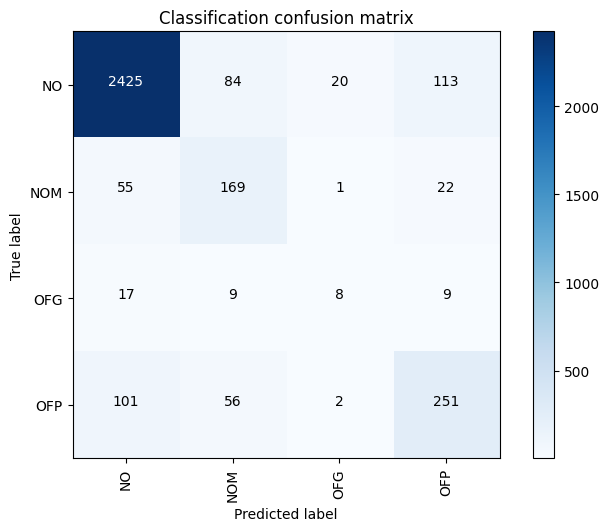


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.6338    0.5960    0.6143       453
     no_hate     0.9372    0.9460    0.9416      2889

    accuracy                         0.8986      3342
   macro avg     0.7855    0.7710    0.7780      3342
weighted avg     0.8961    0.8986    0.8972      3342



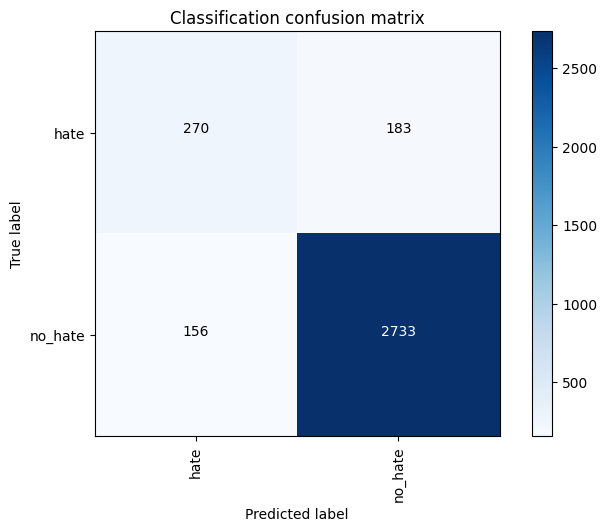

In [ ]:
for num_iterations in [1, 2, 3, 5]:
    print(f"Num iterations run: {num_iterations}")
    dataset_folder: str = dataset_v7_folder
    train_set_file_path: str = os.path.join(dataset_folder, "train.csv")
    val_set_file_path: str = os.path.join(dataset_folder, "val.csv")
    test_set_file_path: str = os.path.join(dataset_folder, "test.csv")

    setfit_train_df: pd.DataFrame = pd.read_csv(train_set_file_path, quotechar='"', header=0, sep=",")
    setfit_val_df: pd.DataFrame = pd.read_csv(val_set_file_path, quotechar='"', header=0, sep=",")
    setfit_test_df: pd.DataFrame = pd.read_csv(test_set_file_path, quotechar='"', header=0, sep=",")

    train_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                      _idx, row in setfit_train_df.iterrows()]
    val_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                    _idx, row in setfit_val_df.iterrows()]
    test_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                     _idx, row in setfit_test_df.iterrows()]

    config = SetfitTrainerConfig(
        train_data=train_data,
        val_data=val_data,
        train_config=SetFitTrainingConfig(
            model="sentence-transformers/distiluse-base-multilingual-cased-v1",
            metric="accuracy",
            batch_size=16,
            num_iterations=num_iterations,
            num_epochs=1,
            add_early_stopping=False,
            early_stopping_patience=0,
            balanced_class_weight=False
        )
    )
    runner = SetFitTrainer(config)
    runner.train()
    runner.eval()
    print("Done!")

    print("MULTI-CLASS METRICS ===============================")
    true_labels: list[str] = [t.label for t in test_data]
    pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
    metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                                  pred_labels=pred_labels)
    print(metrics_calculator.get_classification_report()[0])
    metrics_calculator.plot_confusion_matrix()

    print("\n BINARY-CLASS METRICS ===============================")
    true_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in true_labels]
    pred_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in pred_labels]
    metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels_binary,
                                                  pred_labels=pred_labels_binary)
    print(metrics_calculator.get_classification_report()[0])
    metrics_calculator.plot_confusion_matrix()

    print("\n\n\n")

Al igual que antes, comprobamos que usar `v7` nos permite obtener los mejores resultados. En este caso, **alcanzamos un 61.89% de macro-f1 (MULTI-CLASS) y 79.53% de macro-f1 (BINARY-CLASS).**

Num iterations run: 1


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: sentence-transformers/distiluse-base-multilingual-cased-v1 loaded!
Loading datasets...
Number of samples in training set: 11124
Number of samples in validation set: 3341


Map:   0%|          | 0/11124 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 22248
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 1391


  0%|          | 0/418 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 1391.
***** Running evaluation *****


Finished model training. Took 0:09:55.734808 seconds
Starting evaluation...
Accuracy on validation set: 0.8303
Done!
MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...
Inference done!.
              precision    recall  f1-score   support

          NO     0.9523    0.8762    0.9127      2642
         NOM     0.5056    0.7328    0.5983       247
         OFG     0.1692    0.2558    0.2037        43
         OFP     0.5389    0.6415    0.5857       410

    accuracy                         0.8288      3342
   macro avg     0.5415    0.6266    0.5751      3342
weighted avg     0.8585    0.8288    0.8402      3342



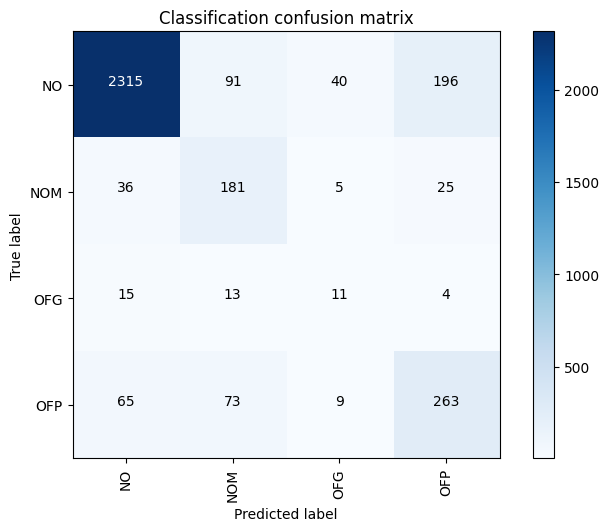


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.5190    0.6336    0.5706       453
     no_hate     0.9405    0.9079    0.9239      2889

    accuracy                         0.8707      3342
   macro avg     0.7297    0.7707    0.7472      3342
weighted avg     0.8833    0.8707    0.8760      3342



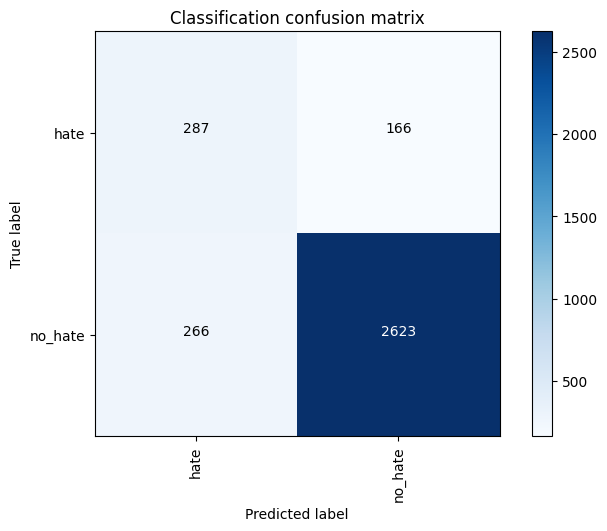





Num iterations run: 2


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: sentence-transformers/distiluse-base-multilingual-cased-v1 loaded!
Loading datasets...
Number of samples in training set: 11124
Number of samples in validation set: 3341


Map:   0%|          | 0/11124 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 44496
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 2781


  0%|          | 0/836 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 2781.
***** Running evaluation *****


Finished model training. Took 0:14:34.777575 seconds
Starting evaluation...
Accuracy on validation set: 0.8387
Done!
MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...
Inference done!.
              precision    recall  f1-score   support

          NO     0.9493    0.8993    0.9236      2642
         NOM     0.5113    0.7328    0.6023       247
         OFG     0.2750    0.2558    0.2651        43
         OFP     0.5820    0.6317    0.6058       410

    accuracy                         0.8459      3342
   macro avg     0.5794    0.6299    0.5992      3342
weighted avg     0.8632    0.8459    0.8524      3342



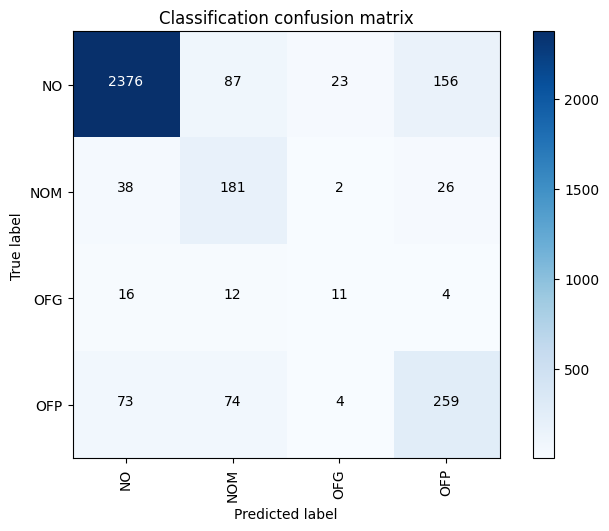


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.5732    0.6137    0.5928       453
     no_hate     0.9387    0.9283    0.9335      2889

    accuracy                         0.8857      3342
   macro avg     0.7560    0.7710    0.7631      3342
weighted avg     0.8892    0.8857    0.8873      3342



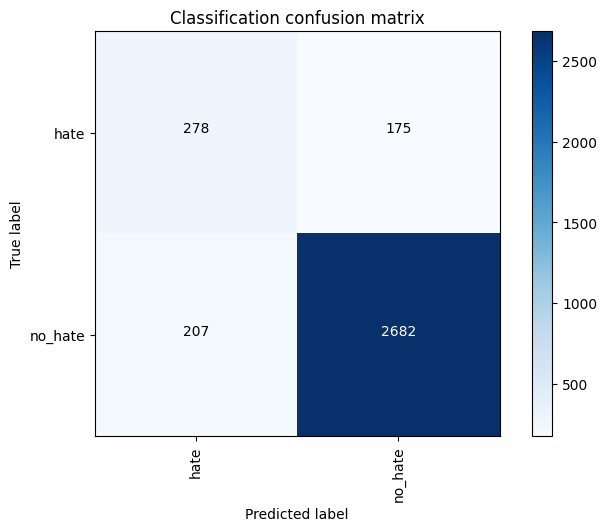





Num iterations run: 3


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: sentence-transformers/distiluse-base-multilingual-cased-v1 loaded!
Loading datasets...
Number of samples in training set: 11124
Number of samples in validation set: 3341


Map:   0%|          | 0/11124 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 66744
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 4172


  0%|          | 0/1253 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 4172.
***** Running evaluation *****


Finished model training. Took 0:19:43.962790 seconds
Starting evaluation...
Accuracy on validation set: 0.8321
Done!
MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...
Inference done!.
              precision    recall  f1-score   support

          NO     0.9473    0.8910    0.9183      2642
         NOM     0.4932    0.7368    0.5909       247
         OFG     0.2500    0.2093    0.2278        43
         OFP     0.5708    0.6293    0.5986       410

    accuracy                         0.8387      3342
   macro avg     0.5653    0.6166    0.5839      3342
weighted avg     0.8586    0.8387    0.8460      3342



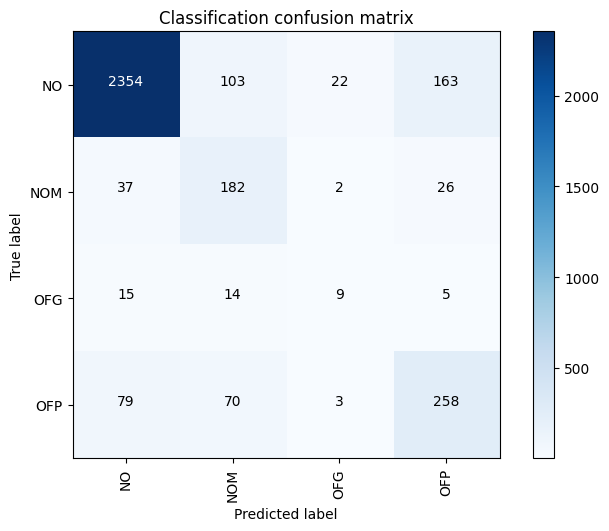


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.5635    0.6071    0.5845       453
     no_hate     0.9376    0.9263    0.9319      2889

    accuracy                         0.8830      3342
   macro avg     0.7506    0.7667    0.7582      3342
weighted avg     0.8869    0.8830    0.8848      3342



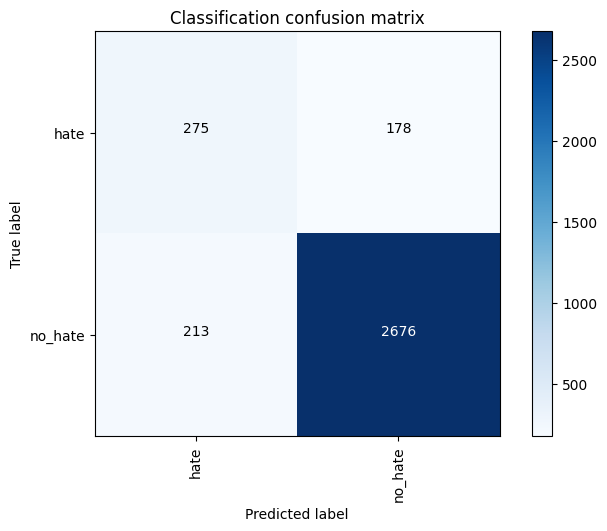





Num iterations run: 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: sentence-transformers/distiluse-base-multilingual-cased-v1 loaded!
Loading datasets...
Number of samples in training set: 11124
Number of samples in validation set: 3341


Map:   0%|          | 0/11124 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 111240
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 6953


  0%|          | 0/2089 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 6953.
***** Running evaluation *****


Finished model training. Took 0:29:03.530199 seconds
Starting evaluation...
Accuracy on validation set: 0.8312
Done!
MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...
Inference done!.
              precision    recall  f1-score   support

          NO     0.9375    0.8967    0.9166      2642
         NOM     0.4439    0.7045    0.5446       247
         OFG     0.2800    0.1628    0.2059        43
         OFP     0.6281    0.6098    0.6188       410

    accuracy                         0.8378      3342
   macro avg     0.5724    0.5934    0.5715      3342
weighted avg     0.8546    0.8378    0.8434      3342



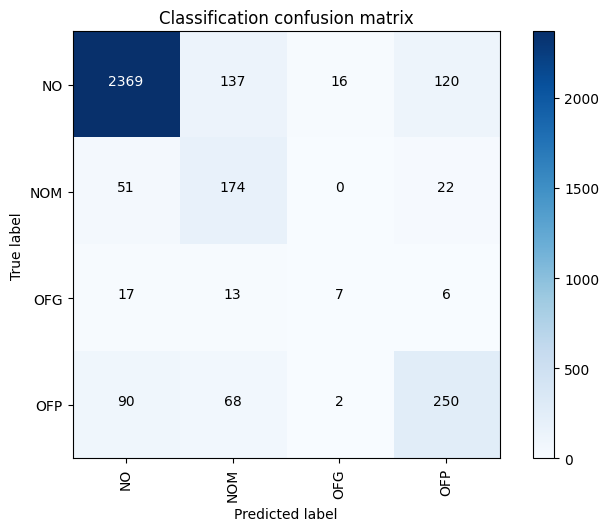


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.6265    0.5850    0.6050       453
     no_hate     0.9356    0.9453    0.9404      2889

    accuracy                         0.8965      3342
   macro avg     0.7810    0.7651    0.7727      3342
weighted avg     0.8937    0.8965    0.8950      3342



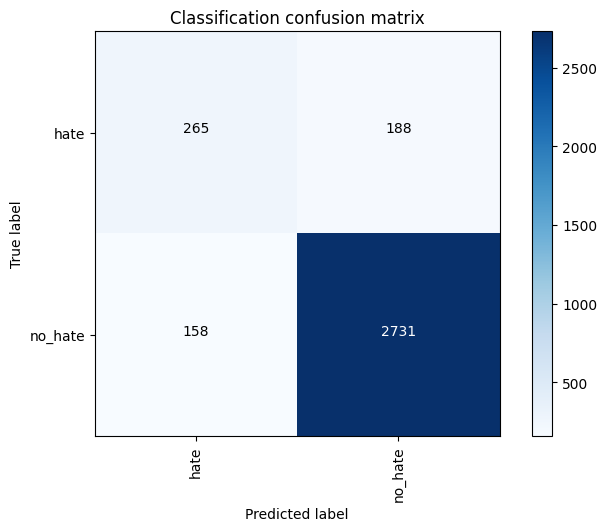

In [ ]:
for num_iterations in [1, 2, 3, 5]:
    print(f"Num iterations run: {num_iterations}")
    dataset_folder: str = dataset_v7_folder
    train_set_file_path: str = os.path.join(dataset_folder, "train.csv")
    val_set_file_path: str = os.path.join(dataset_folder, "val.csv")
    test_set_file_path: str = os.path.join(dataset_folder, "test.csv")

    setfit_train_df: pd.DataFrame = pd.read_csv(train_set_file_path, quotechar='"', header=0, sep=",")
    setfit_val_df: pd.DataFrame = pd.read_csv(val_set_file_path, quotechar='"', header=0, sep=",")
    setfit_test_df: pd.DataFrame = pd.read_csv(test_set_file_path, quotechar='"', header=0, sep=",")

    train_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                      _idx, row in setfit_train_df.iterrows()]
    val_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                    _idx, row in setfit_val_df.iterrows()]
    test_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                     _idx, row in setfit_test_df.iterrows()]

    config = SetfitTrainerConfig(
        train_data=train_data,
        val_data=val_data,
        train_config=SetFitTrainingConfig(
            model="sentence-transformers/distiluse-base-multilingual-cased-v1",
            metric="accuracy",
            batch_size=16,
            num_iterations=num_iterations,
            num_epochs=1,
            add_early_stopping=False,
            early_stopping_patience=0,
            balanced_class_weight=True,
            head_max_iter=3000
        )
    )
    runner = SetFitTrainer(config)
    runner.train()
    runner.eval()
    print("Done!")

    print("MULTI-CLASS METRICS ===============================")
    true_labels: list[str] = [t.label for t in test_data]
    pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
    metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                                  pred_labels=pred_labels)
    print(metrics_calculator.get_classification_report()[0])
    metrics_calculator.plot_confusion_matrix()

    print("\n BINARY-CLASS METRICS ===============================")
    true_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in true_labels]
    pred_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in pred_labels]
    metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels_binary,
                                                  pred_labels=pred_labels_binary)
    print(metrics_calculator.get_classification_report()[0])
    metrics_calculator.plot_confusion_matrix()

    print("\n\n\n")

Al igual que antes, no logramos mejorar los resultados al usar `class_weight=True`.

#### [sentence-transformers/LaBSE](https://huggingface.co/sentence-transformers/LaBSE)

Debido a las prueba que hicimos antes, entrenaremos directamente este modelo con `v7`.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Num iterations run: 2


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.22k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Sentence transformer: sentence-transformers/LaBSE loaded!
Loading datasets...
Number of samples in training set: 11124
Number of samples in validation set: 3341


Map:   0%|          | 0/11124 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 44496
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 2781


  0%|          | 0/836 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 2781.
***** Running evaluation *****


Finished model training. Took 0:31:27.381666 seconds
Starting evaluation...


Accuracy on validation set: 0.8686
Done!
MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...
Inference done!.
              precision    recall  f1-score   support

          NO     0.9379    0.9315    0.9347      2642
         NOM     0.6142    0.6316    0.6228       247
         OFG     0.3208    0.3953    0.3542        43
         OFP     0.6496    0.6512    0.6504       410

    accuracy                         0.8680      3342
   macro avg     0.6306    0.6524    0.6405      3342
weighted avg     0.8707    0.8680    0.8693      3342



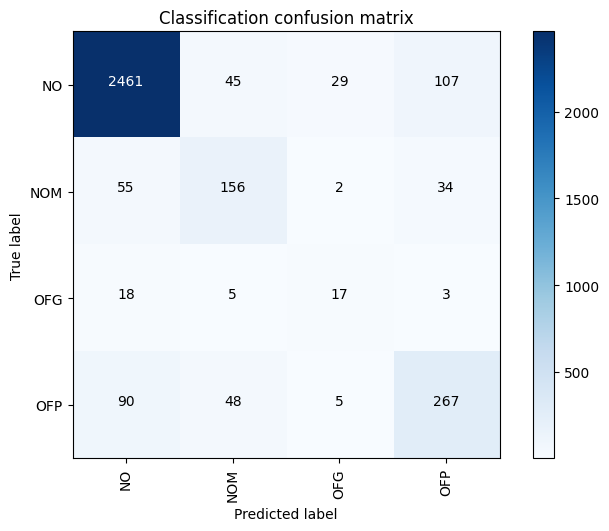


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.6293    0.6446    0.6369       453
     no_hate     0.9441    0.9405    0.9423      2889

    accuracy                         0.9004      3342
   macro avg     0.7867    0.7925    0.7896      3342
weighted avg     0.9014    0.9004    0.9009      3342



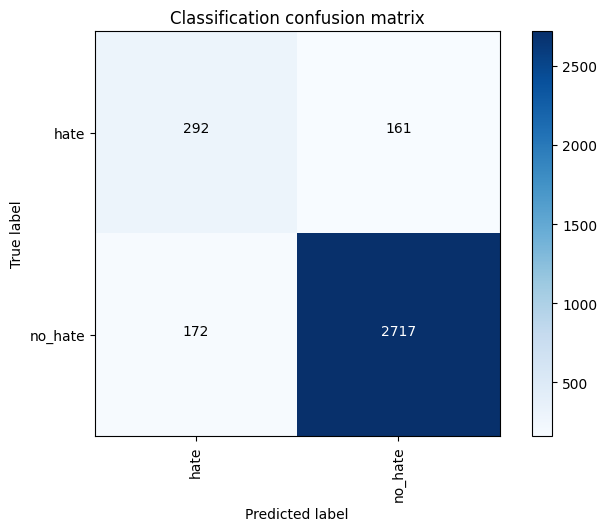

In [ ]:
for num_iterations in [2]:
    print(f"Num iterations run: {num_iterations}")
    dataset_folder: str = dataset_v7_folder
    train_set_file_path: str = os.path.join(dataset_folder, "train.csv")
    val_set_file_path: str = os.path.join(dataset_folder, "val.csv")
    test_set_file_path: str = os.path.join(dataset_folder, "test.csv")

    setfit_train_df: pd.DataFrame = pd.read_csv(train_set_file_path, quotechar='"', header=0, sep=",")
    setfit_val_df: pd.DataFrame = pd.read_csv(val_set_file_path, quotechar='"', header=0, sep=",")
    setfit_test_df: pd.DataFrame = pd.read_csv(test_set_file_path, quotechar='"', header=0, sep=",")

    train_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                      _idx, row in setfit_train_df.iterrows()]
    val_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                    _idx, row in setfit_val_df.iterrows()]
    test_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                     _idx, row in setfit_test_df.iterrows()]

    config = SetfitTrainerConfig(
        train_data=train_data,
        val_data=val_data,
        train_config=SetFitTrainingConfig(
            model="sentence-transformers/LaBSE",
            metric="accuracy",
            batch_size=16,
            num_iterations=num_iterations,
            num_epochs=1,
            add_early_stopping=False,
            early_stopping_patience=0,
            balanced_class_weight=False,
            #head_max_iter=3000
        )
    )
    runner = SetFitTrainer(config)
    runner.train()
    runner.eval()
    print("Done!")

    print("MULTI-CLASS METRICS ===============================")
    true_labels: list[str] = [t.label for t in test_data]
    pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
    metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                                  pred_labels=pred_labels)
    print(metrics_calculator.get_classification_report()[0])
    metrics_calculator.plot_confusion_matrix()

    print("\n BINARY-CLASS METRICS ===============================")
    true_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in true_labels]
    pred_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in pred_labels]
    metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels_binary,
                                                  pred_labels=pred_labels_binary)
    print(metrics_calculator.get_classification_report()[0])
    metrics_calculator.plot_confusion_matrix()

    print("\n\n\n")

Obtenemos en nuestra primera prueba una performance que ya supera a la obtenida por los modelos anteriores. **Hablamos de un 64.05% de macro-f1 (multi-class) y 78.96% de macro-f1 (binary class)**. Quizás podíamos esperarlo, debido a que LaBSE es considerablemente más grande.

Num iterations run: 2


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: sentence-transformers/LaBSE loaded!
Loading datasets...
Number of samples in training set: 11124
Number of samples in validation set: 3341


Map:   0%|          | 0/11124 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 44496
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 2781


  0%|          | 0/836 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 2781.
***** Running evaluation *****


Finished model training. Took 0:32:08.917965 seconds
Starting evaluation...
Accuracy on validation set: 0.8536
Done!
MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...
Inference done!.
              precision    recall  f1-score   support

          NO     0.9495    0.9118    0.9303      2642
         NOM     0.5289    0.7045    0.6042       247
         OFG     0.3400    0.3953    0.3656        43
         OFP     0.6268    0.6512    0.6388       410

    accuracy                         0.8579      3342
   macro avg     0.6113    0.6657    0.6347      3342
weighted avg     0.8710    0.8579    0.8632      3342



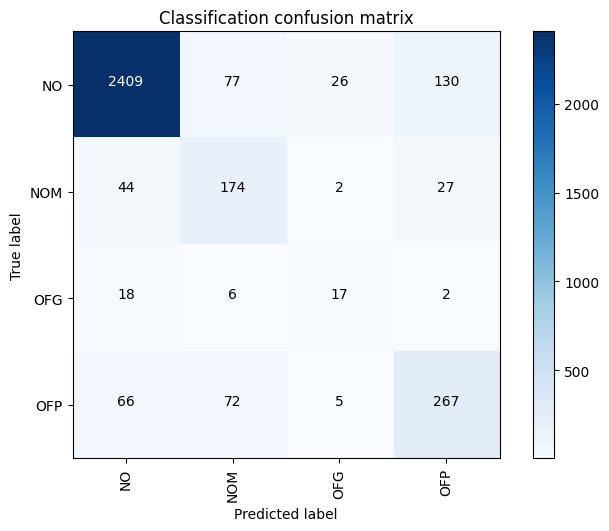


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.6113    0.6424    0.6265       453
     no_hate     0.9435    0.9360    0.9397      2889

    accuracy                         0.8962      3342
   macro avg     0.7774    0.7892    0.7831      3342
weighted avg     0.8985    0.8962    0.8972      3342



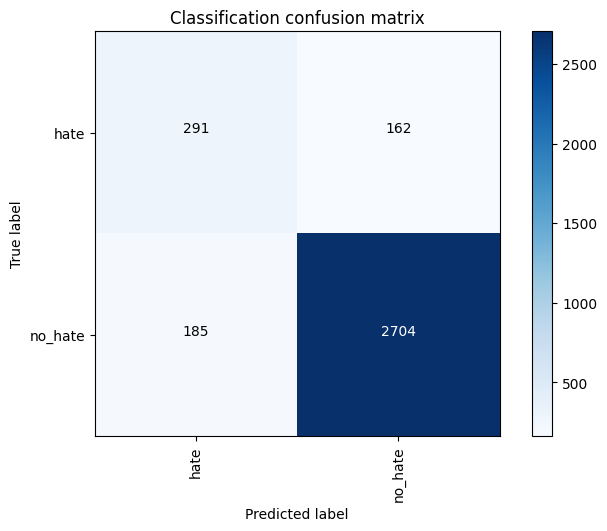

In [ ]:
for num_iterations in [2]:
    print(f"Num iterations run: {num_iterations}")
    dataset_folder: str = dataset_v7_folder
    train_set_file_path: str = os.path.join(dataset_folder, "train.csv")
    val_set_file_path: str = os.path.join(dataset_folder, "val.csv")
    test_set_file_path: str = os.path.join(dataset_folder, "test.csv")

    setfit_train_df: pd.DataFrame = pd.read_csv(train_set_file_path, quotechar='"', header=0, sep=",")
    setfit_val_df: pd.DataFrame = pd.read_csv(val_set_file_path, quotechar='"', header=0, sep=",")
    setfit_test_df: pd.DataFrame = pd.read_csv(test_set_file_path, quotechar='"', header=0, sep=",")

    train_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                      _idx, row in setfit_train_df.iterrows()]
    val_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                    _idx, row in setfit_val_df.iterrows()]
    test_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                     _idx, row in setfit_test_df.iterrows()]

    config = SetfitTrainerConfig(
        train_data=train_data,
        val_data=val_data,
        train_config=SetFitTrainingConfig(
            model="sentence-transformers/LaBSE",
            metric="accuracy",
            batch_size=16,
            num_iterations=num_iterations,
            num_epochs=1,
            add_early_stopping=False,
            early_stopping_patience=0,
            balanced_class_weight=True,
            #head_max_iter=3000
        )
    )
    runner = SetFitTrainer(config)
    runner.train()
    runner.eval()
    print("Done!")

    print("MULTI-CLASS METRICS ===============================")
    true_labels: list[str] = [t.label for t in test_data]
    pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
    metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                                  pred_labels=pred_labels)
    print(metrics_calculator.get_classification_report()[0])
    metrics_calculator.plot_confusion_matrix()

    print("\n BINARY-CLASS METRICS ===============================")
    true_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in true_labels]
    pred_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in pred_labels]
    metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels_binary,
                                                  pred_labels=pred_labels_binary)
    print(metrics_calculator.get_classification_report()[0])
    metrics_calculator.plot_confusion_matrix()

    print("\n\n\n")

Al igual que antes, comprobamos que usar `class_weight="balanced"` tampoco mejora nuestros resultados.

Num iterations run: 2


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: sentence-transformers/LaBSE loaded!
Loading datasets...
Number of samples in training set: 11124
Number of samples in validation set: 3341


Map:   0%|          | 0/11124 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 44496
  Batch size = 16
  Num epochs = 3
  Total optimization steps = 8343


  0%|          | 0/836 [00:00<?, ?it/s]

  0%|          | 0/836 [00:00<?, ?it/s]

  0%|          | 0/836 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 2781.
***** Running evaluation *****


Finished model training. Took 1:24:13.604628 seconds
Starting evaluation...
Accuracy on validation set: 0.8773
Done!
MULTI-CLASS METRICS ===============================
Starting to do inference over trained model...
Inference done!.
              precision    recall  f1-score   support

          NO     0.9255    0.9595    0.9422      2642
         NOM     0.6637    0.6073    0.6342       247
         OFG     0.4815    0.3023    0.3714        43
         OFP     0.7057    0.6024    0.6500       410

    accuracy                         0.8812      3342
   macro avg     0.6941    0.6179    0.6495      3342
weighted avg     0.8735    0.8812    0.8763      3342



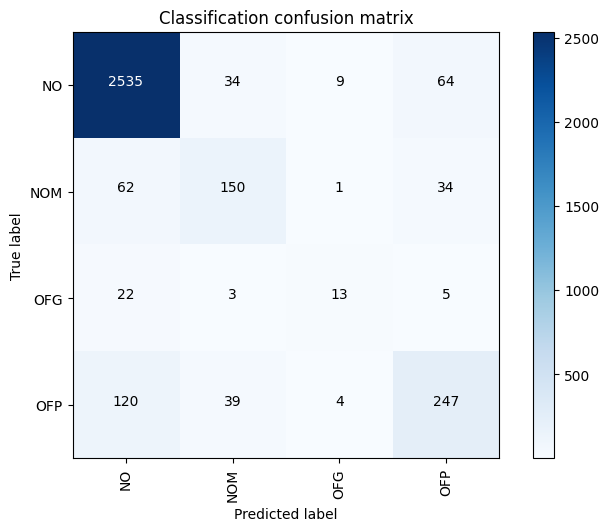


 BINARY-CLASS METRICS ===============================
              precision    recall  f1-score   support

        hate     0.7135    0.5938    0.6482       453
     no_hate     0.9379    0.9626    0.9501      2889

    accuracy                         0.9126      3342
   macro avg     0.8257    0.7782    0.7992      3342
weighted avg     0.9075    0.9126    0.9092      3342



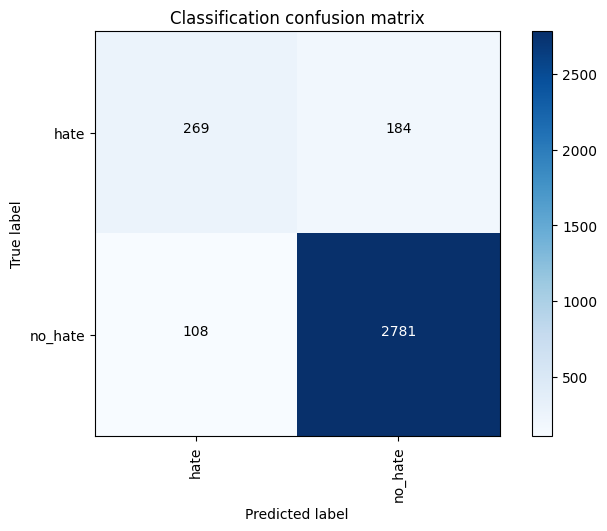

In [ ]:
for num_iterations in [2]:
    print(f"Num iterations run: {num_iterations}")
    dataset_folder: str = dataset_v7_folder
    train_set_file_path: str = os.path.join(dataset_folder, "train.csv")
    val_set_file_path: str = os.path.join(dataset_folder, "val.csv")
    test_set_file_path: str = os.path.join(dataset_folder, "test.csv")

    setfit_train_df: pd.DataFrame = pd.read_csv(train_set_file_path, quotechar='"', header=0, sep=",")
    setfit_val_df: pd.DataFrame = pd.read_csv(val_set_file_path, quotechar='"', header=0, sep=",")
    setfit_test_df: pd.DataFrame = pd.read_csv(test_set_file_path, quotechar='"', header=0, sep=",")

    train_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                      _idx, row in setfit_train_df.iterrows()]
    val_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                    _idx, row in setfit_val_df.iterrows()]
    test_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                     _idx, row in setfit_test_df.iterrows()]

    config = SetfitTrainerConfig(
        train_data=train_data,
        val_data=val_data,
        train_config=SetFitTrainingConfig(
            model="sentence-transformers/LaBSE",
            metric="accuracy",
            batch_size=16,
            num_iterations=num_iterations,
            num_epochs=3,
            add_early_stopping=False,
            early_stopping_patience=0,
            balanced_class_weight=False,
            #head_max_iter=3000
        )
    )
    runner = SetFitTrainer(config)
    runner.train()
    runner.eval()
    print("Done!")

    print("MULTI-CLASS METRICS ===============================")
    true_labels: list[str] = [t.label for t in test_data]
    pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
    metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                                  pred_labels=pred_labels)
    print(metrics_calculator.get_classification_report()[0])
    metrics_calculator.plot_confusion_matrix()

    print("\n BINARY-CLASS METRICS ===============================")
    true_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in true_labels]
    pred_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in pred_labels]
    metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels_binary,
                                                  pred_labels=pred_labels_binary)
    print(metrics_calculator.get_classification_report()[0])
    metrics_calculator.plot_confusion_matrix()

    print("\n\n\n")

En este caso, y a diferencia de los modelos anteriores, vemos que logramos una mejora al entrenar por unas pocas epochs. **Hablamos de un 64.95% de macro-f1 (multi-class) y 79.92% de macro-f1 (binary-class)**.

Podríamos continuar intentando optimizar este entrenamiento, el cual de momento es el más prometedor que hemos tenido. Sin embargo, estas pruebas son costosas, no tanto en tiempo, pero sí en el hardware que necesitamos utilizar en Google Colab. Por tanto, decidiré parar aquí. Cosas que hubiese estado bueno probar:
- Reducir el learning rate, ya que SetFit lo permite.
- Probar de freezear el encoder que estemos usando, en lugar de fine-tunearlo, que es lo que pasa en los trainings hechos hasta el momento.

#### [BAAI/bge-m3](https://huggingface.co/BAAI/bge-m3/blob/ecf34d3096437e53f2c163f370b4135980d2e024/README.md)

In [ ]:
for num_iterations in [2]:
    print(f"Num iterations run: {num_iterations}")
    dataset_folder: str = dataset_v7_folder
    train_set_file_path: str = os.path.join(dataset_folder, "train.csv")
    val_set_file_path: str = os.path.join(dataset_folder, "val.csv")
    test_set_file_path: str = os.path.join(dataset_folder, "test.csv")

    setfit_train_df: pd.DataFrame = pd.read_csv(train_set_file_path, quotechar='"', header=0, sep=",")
    setfit_val_df: pd.DataFrame = pd.read_csv(val_set_file_path, quotechar='"', header=0, sep=",")
    setfit_test_df: pd.DataFrame = pd.read_csv(test_set_file_path, quotechar='"', header=0, sep=",")

    train_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                      _idx, row in setfit_train_df.iterrows()]
    val_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                    _idx, row in setfit_val_df.iterrows()]
    test_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                     _idx, row in setfit_test_df.iterrows()]

    config = SetfitTrainerConfig(
        train_data=train_data,
        val_data=val_data,
        train_config=SetFitTrainingConfig(
            model="BAAI/bge-m3",
            metric="accuracy",
            batch_size=16,
            num_iterations=num_iterations,
            num_epochs=1,
            add_early_stopping=False,
            early_stopping_patience=0,
            balanced_class_weight=False,
            #head_max_iter=3000
        )
    )
    runner = SetFitTrainer(config)
    runner.train()
    runner.eval()
    print("Done!")

    print("MULTI-CLASS METRICS ===============================")
    true_labels: list[str] = [t.label for t in test_data]
    pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
    metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                                  pred_labels=pred_labels)
    print(metrics_calculator.get_classification_report()[0])
    metrics_calculator.plot_confusion_matrix()

    print("\n BINARY-CLASS METRICS ===============================")
    true_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in true_labels]
    pred_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in pred_labels]
    metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels_binary,
                                                  pred_labels=pred_labels_binary)
    print(metrics_calculator.get_classification_report()[0])
    metrics_calculator.plot_confusion_matrix()

    print("\n\n\n")

Num iterations run: 2


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence transformer: BAAI/bge-m3 loaded!
Loading datasets...
Number of samples in training set: 11124
Number of samples in validation set: 3341


Map:   0%|          | 0/11124 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 44496
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 2781


OutOfMemoryError: CUDA out of memory. Tried to allocate 978.00 MiB. GPU 

Lamentablemente, inclusive con 22.5GB de GPU RAM, no pudimos entrenar este modelo para ver su performance. Suena a que no está optimizado para ser entrenado con SetFit o a que su tamaño es demasiado grande como para fitearlo en la GPU que tenemos. Intentaremos reducir el batch_size a la mitad, a ver si tenemos suerte.

In [10]:
for num_iterations in [2]:
    print(f"Num iterations run: {num_iterations}")
    dataset_folder: str = dataset_v7_folder
    train_set_file_path: str = os.path.join(dataset_folder, "train.csv")
    val_set_file_path: str = os.path.join(dataset_folder, "val.csv")
    test_set_file_path: str = os.path.join(dataset_folder, "test.csv")

    setfit_train_df: pd.DataFrame = pd.read_csv(train_set_file_path, quotechar='"', header=0, sep=",")
    setfit_val_df: pd.DataFrame = pd.read_csv(val_set_file_path, quotechar='"', header=0, sep=",")
    setfit_test_df: pd.DataFrame = pd.read_csv(test_set_file_path, quotechar='"', header=0, sep=",")

    train_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                      _idx, row in setfit_train_df.iterrows()]
    val_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                    _idx, row in setfit_val_df.iterrows()]
    test_data: list[TrainingItem] = [TrainingItem(id=row["comment_id"], text=row["comment"], label=row["label"]) for
                                     _idx, row in setfit_test_df.iterrows()]

    config = SetfitTrainerConfig(
        train_data=train_data,
        val_data=val_data,
        train_config=SetFitTrainingConfig(
            model="BAAI/bge-m3",
            metric="accuracy",
            batch_size=8,
            num_iterations=num_iterations,
            num_epochs=1,
            add_early_stopping=False,
            early_stopping_patience=0,
            balanced_class_weight=False,
            #head_max_iter=3000
        )
    )
    runner = SetFitTrainer(config)
    runner.train()
    runner.eval()
    print("Done!")

    print("MULTI-CLASS METRICS ===============================")
    true_labels: list[str] = [t.label for t in test_data]
    pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
    metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                                  pred_labels=pred_labels)
    print(metrics_calculator.get_classification_report()[0])
    metrics_calculator.plot_confusion_matrix()

    print("\n BINARY-CLASS METRICS ===============================")
    true_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in true_labels]
    pred_labels_binary: list[str] = [hs_config.map_to_binary_label(l) for l in pred_labels]
    metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels_binary,
                                                  pred_labels=pred_labels_binary)
    print(metrics_calculator.get_classification_report()[0])
    metrics_calculator.plot_confusion_matrix()

    print("\n\n\n")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Num iterations run: 2


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.0k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Sentence transformer: BAAI/bge-m3 loaded!
Loading datasets...
Number of samples in training set: 11124
Number of samples in validation set: 3341


Map:   0%|          | 0/11124 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 44496
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 5562


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.74 GiB. GPU 

Inclusive reduciendo el `batch_size`, no logramos fitear el modelo para que pueda ser entrenado.

Como detalle de color, para averiguar la la cantidad de tokens en el vocabulario que cada tokenizador para cada modelo tiene, se puede usar el siguiente código

In [8]:
from transformers import AutoTokenizer


def compute_vocab_size(hf_model_name: str) -> int:
    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(hf_model_name)
    # Get the vocabulary size
    vocab_size = len(tokenizer)

    return vocab_size

In [9]:
for model_name in ["MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7", "pysentimiento/robertuito-hate-speech",
                   "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
                   "sentence-transformers/distiluse-base-multilingual-cased-v1",
                   "sentence-transformers/LaBSE"]:
    vocab_size: int = compute_vocab_size(model_name)
    print(f"Vocabulary Size for '{model_name}': {vocab_size}")

Vocabulary Size for 'MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7': 250102


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Vocabulary Size for 'pysentimiento/robertuito-hate-speech': 30002
Vocabulary Size for 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2': 250002
Vocabulary Size for 'sentence-transformers/distiluse-base-multilingual-cased-v1': 119547
Vocabulary Size for 'sentence-transformers/LaBSE': 501153


# Conclusiones y Resultados

Realizamos varias pruebas con distintos modelos contextuales más complejos. Exploramos la performance de los LLMs state-of-the-art como ChatGPT y GPT-4 y su desempeño zero-shot, así como también algunos modelos pre-entrenados para esta tarea. Pasamos luego a entrenar clasificadores usando el framework de SetFit y enfocándonos en sentence-transformers que pensamos que podían ser los mejores para esta tarea y que fuesen multilingues, ya que los datos están en español.

Respecto a las pruebas, comenzamos utilizando versiones del dataset como `v1` y `v4` y notamos que los modelos tenian su performance un poco más degradada debido a la limpieza de los datos y por tanto pérdida de información. Para los clasificadores entrenados con SetFit, utilizamos directamente el dataset `v7`, el cual tiene un cleanup extremadamente ligero, de forma de mantener la mayor cantidad posible de información para que estos modelos puedan utilizarla para predecir. En estas pruebas, utilizar `class_weight="balanced"` no nos dio mejores resultados. Tampoco logramos poder entrenar con SetFit por múltiples épocas, ya que la función de pérdida no disminuia.

Como conclusiones adicionales:
- 🏅 Modelos SetFit generalmente superan al resto de los modelos. Esto tiene sentido, pues son fine-tuneados con nuestros datos.
- 🏅 **LaBSE SetFit**, con 64.95% de macro-f1 para MULTI-CLASS y 79.92% de macro-f1 BINARY-CLASS es el mejor modelo overall. Lo sigue `paraphrase-multilingual-MiniLM-L12-v2 SetFit` con 63.39% de macro-f1 para MULTI-CLASS y 78.40% de macro-f1 BINARY-CLASS.
- Si la velocidad de inferencia en producción fuese un factor crítico, podríamos ir con `paraphrase-multilingual-MiniLM-L12-v2 SetFit`, pues tiene una performance relativamente parecida a `LaBSE Setfit` con casi 350M de parámetros menos.

El resumen de los mejores resultados se presenta en la siguiente tabla. _Notar que `MC` significa `MULTI-CLASS` y `BC` hace referencia a la performance para `BINARY-CLASS`_.

<br>

| Model                                                                                                                                      | Model Size | Dataset  | Representation                                              | macro-precision (MC) | macro-recall (MC) | macro-F1 (MC)  | macro-precision (BC) | macro-recall (BC) | macro-F1 (BC)  | Config highlights                                                                                    |
| ------------------------------------------------------------------------------------------------------------------------------------------ | ---------- | -------- | ----------------------------------------------------------- |----------------------|---------------|------------|----------------------|---------------|------------| ---------------------------------------------------------------------------------------------------- |
| [GPT 3.5 turbo](https://openai.com/blog/chatgpt) Zero Shot                                                                                 | 175B       | original | Tokenizer<br>Vocab: ~50k tokens<br>Max Input: 4096 tokens   | 0.3811               | 0.5195        | 0.3560     | 0.6322               | 0.7451        | 0.7816     |                                                                                                      |
| [GPT-4](https://openai.com/research/gpt-4) Zero Shot                                                                                       | 1.75T      | v4       | Tokenizer<br>Vocab: ~100k tokens<br>Max Input: 8192 tokens  | 0.4857               | 0.6398        | 0.5255     | 0.7099               | 0.8532        | 0.7419     |                                                                                                      |
| [mDeBERTa-v3-base-xnli-multilingual-nli-2mil7](https://huggingface.co/MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7) Zero Shot | 279M       | v4       | Tokenizer<br>Vocab: ~ 30522 tokens<br>Max Input: 512 tokens | 0.3261               | 0.3511        | 0.2500     | 0.6355               | 0.7218        | 0.6522     |                                                                                                      |
| [robertuito-hate-speech](https://huggingface.co/pysentimiento/robertuito-hate-speech)                                                      | ~114M      | v4       | Tokenizer<br>Vocab: ~ 30k tokens<br>Max Input: 512 tokens   | \-                   | \-            | \-         | 0.6858               | 0.6584        | 0.6702     |                                                                                                      |
| [paraphrase-multilingual-MiniLM-L12-v2](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2) Setfit         | 118M       | v7       | Tokenizer<br>Vocab: ~ 250k tokens<br>Max Input: 128 tokens  | 0.6361               | 0.6321        | 0.6339     | 0.7887               | 0.7795        | 0.7840     | (batch_size=16, num_iterations=3, num_epochs=1, add_early_stopping=False, early_stopping_patience=0) |
| [distiluse-base-multilingual-cased-v1](https://huggingface.co/sentence-transformers/distiluse-base-multilingual-cased-v1) Setfit           | 135M       | v7       | Tokenizer<br>Vocab: ~ 120k tokens<br>Max Input: 128 tokens  | 0.6251               | 0.6130        | 0.6189     | 0.8008               | 0.7901        | 0.7953     | (batch_size=16, num_iterations=2, num_epochs=1, add_early_stopping=False, early_stopping_patience=0) |
| [LaBSE](https://huggingface.co/sentence-transformers/LaBSE) Setfit                                                                         | 471M       | v7       | Tokenizer<br>Vocab: ~ 501k tokens<br>Max Input: 256 tokens  | 0.6941               | 0.6179        | **0.6495** | 0.8257               | 0.7782        | **0.7992** | (batch_size=16, num_iterations=2, num_epochs=3, add_early_stopping=False, early_stopping_patience=0) |

<br>


_Los resultados de este notebook y del resto, pueden visualizarse en el siguiente [Google Spreadsheet](https://docs.google.com/spreadsheets/d/1mzY6YMFSP3kXgH3qgbJnX1w0f463ZQ06n32tLGgqOos/edit?usp=sharing). Para más información, dirigirse a `5_results_and_conclusions.ipynb`, la cual también los muestra y concluye nuestra práctica._

